# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/[2024-2025] AN2DL HW2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1z5t8kqLSNnsGWmeDMitEc48VDF9xBUOx/[2024-2025] AN2DL HW2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Loading the cleaned dataset
data = np.load("mars_cleaned_dataset.npz")
X = data["X_train"]
y = data["y_train"]
X_final_test = data["X_test"]
print(X.shape)
print(y.shape)
print(X_final_test.shape)

#Splitting
test_size = 0.15
adjusted_val_size = 0.176
X_trainval, X_test, y_trainval, y_test = train_test_split( X, y, test_size=test_size, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split( X_trainval, y_trainval, test_size=adjusted_val_size, random_state=seed)

#Turning np dataset in tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices(X_final_test)

(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)


In [ ]:
def tile_dataset(dataset, image_shape, label_shape):
    """
    Tiles each image and segmentation label in the dataset into two halves along the width.

    Args:
    - dataset (tf.data.Dataset): A dataset of (image, label) pairs.
    - image_shape (tuple): The shape of each image (height, width, channels).
    - label_shape (tuple): The shape of each segmentation label (height, width, channels).

    Returns:
    - tf.data.Dataset: A new dataset with tiled images and labels.
    """
    def tile_image_label(image, label):
        # Split the image and label along the width (axis=1)
        image_tile1, image_tile2 = tf.split(image, num_or_size_splits=2, axis=1)
        label_tile1, label_tile2 = tf.split(label, num_or_size_splits=2, axis=1)

        # Combine the tiles into two new (image, label) pairs
        tiled1 = (image_tile1, label_tile1)
        tiled2 = (image_tile2, label_tile2)
        return tf.data.Dataset.from_tensors(tiled1).concatenate(tf.data.Dataset.from_tensors(tiled2))

    # Map the tile operation over the dataset
    tiled_dataset = dataset.flat_map(lambda image, label: tile_image_label(image, label))

    return tiled_dataset


train_dataset = tile_dataset(train_dataset, (64, 64, 1), (64, 64, 1))
val_dataset = tile_dataset(val_dataset, (64, 64, 1), (64, 64, 1))
test_dataset = tile_dataset(test_dataset, (64, 64, 1), (64, 64, 1))



In [ ]:
# Define class labels for better readability
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Ensure input is a 1D array of integers
y_vector = np.ravel(y_train).astype(int)

# Calculate class counts
class_counts = np.bincount(y_vector, minlength=len(class_labels))

# Calculate frequency percentages
class_frequencies = class_counts / np.sum(class_counts) * 100

# Display class counts and percentages
print("Class Distribution:\n")
for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
    print(f"Class {i} ({class_labels[i]}):")
    print(f"    Pixels: {count}")
    print(f"    Frequency: {freq:.2f}%")

# Calculate raw weights as the inverse of the frequencies
raw_weights = {cls: 1.0 / freq for cls, freq in zip(range(len(class_frequencies)), class_frequencies)}

# Normalize the weights so that their sum equals the number of classes
sum_of_raw_weights = sum(raw_weights.values())
num_classes = len(class_labels)

normalized_weights = {cls: (weight / sum_of_raw_weights) * num_classes for cls, weight in raw_weights.items()}

# Display results
print("Class Frequencies:", class_frequencies)
print("Raw Weights:", raw_weights)
print("Normalized Weights:", normalized_weights)

Class Distribution:

Class 0 (Background):
    Pixels: 3512496
    Frequency: 24.45%
Class 1 (Soil):
    Pixels: 4863886
    Frequency: 33.85%
Class 2 (Bedrock):
    Pixels: 3498998
    Frequency: 24.35%
Class 3 (Sand):
    Pixels: 2473313
    Frequency: 17.21%
Class 4 (Big Rock):
    Pixels: 20075
    Frequency: 0.14%
Class Frequencies: [24.44535259 33.85040388 24.35141273 17.21311806  0.13971274]
Raw Weights: {0: 0.04090757114029454, 1: 0.029541745016227763, 2: 0.0410653792885849, 3: 0.05809522692841545, 4: 7.157543212951432}
Normalized Weights: {0: 0.027915051306267202, 1: 0.02015908803229728, 2: 0.02802273852487435, 3: 0.0396437919717635, 4: 4.884259330164797}


In [ ]:
#define loss function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)
    return loss_fn

def standard_loss():
  return tf.keras.losses.SparseCategoricalCrossentropy()

def weighted_cross_entropy_loss(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)  # Avoid log(0)
        y_true_one_hot = tf.one_hot(y_true, depth=len(weights))
        weights_tensor = tf.constant(list(weights.values()), dtype=tf.float32)  # Use list to extract values from dictionary
        weighted_cross_entropy = tf.reduce_sum(weights_tensor * y_true_one_hot * tf.math.log(y_pred), axis=-1)
        return -tf.reduce_mean(weighted_cross_entropy)
    return loss

def dice_loss(smooth = 1e-6):
  def loss(y_true, y_pred):
      y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
      y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)  # Ensure numerical stability
      intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
      union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
      dice = (2. * intersection + smooth) / (union + smooth)
      return 1 - tf.reduce_mean(dice)
  return loss

def combined_loss(weights, alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        wce_loss = weighted_cross_entropy_loss(weights)(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        return alpha * dice + beta * wce_loss
    return loss

In [ ]:
#augmentation, applied to train, validation and test
augment_geometrical = True
augment_noise = True
augment_texture = False

#balancing technique
balance = True #if true the rock class is oversampled based on rock_overaampling
rock_oversampling = 2 #values in [1,n]. 1 means no oversampling

#complexity parameters
STACK = 3 #the unet block stack
ADD_L = 0 #number of additional layers

#training parameters
BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 1)
NUM_CLASSES = 5
LEARNING_RATE = 1e-5
EPOCHS = 50
PATIENCE = 5

#loss will be the model's loss
loss = focal_loss()

In [ ]:
def rock_oversample(dataset, oversampling_ratio=1):
    """
    Oversample elements in the dataset where the label contains the class 'Big Rock' (class label 4).

    Parameters:
    dataset: tf.data.Dataset - The input dataset containing (image, label) pairs
    oversampling_ratio: int - The number of times to duplicate elements with 'Big Rock'

    Returns:
    tf.data.Dataset - The oversampled dataset
    """
    def contains_big_rock(image, label):
        """
        Check if the label contains the undersampled class 'Big Rock' (class label 4).
        """
        return tf.reduce_any(label == 4)

    def oversample_fn(image, label):
        """
        Duplicate the (image, label) pair if it contains 'Big Rock'.
        """
        # If contains 'Big Rock', repeat the element 'oversampling_ratio' times
        return tf.cond(
            contains_big_rock(image, label),
            lambda: tf.data.Dataset.from_tensors((image, label)).repeat(oversampling_ratio),
            lambda: tf.data.Dataset.from_tensors((image, label))
        )

    # Apply the oversampling logic to each element using flat_map
    oversampled_dataset = dataset.flat_map(oversample_fn)

    # Shuffle the oversampled dataset to mix the duplicates with the original data
    oversampled_dataset = oversampled_dataset.shuffle(buffer_size=1000)

    return oversampled_dataset

if balance:
  # training oversample
  print("Oversampling dataset...")
  train_dataset = rock_oversample(
      dataset=train_dataset,
      oversampling_ratio=rock_oversampling
  )

Oversampling dataset...


Print shapes

In [ ]:
for image, label in train_dataset.take(1):  # Take one batch to inspect the shape
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

# To get the number of elements in the dataset
num_images = sum(1 for _ in train_dataset)
print(f"Number of images in the train dataset: {num_images}")

for image, label in val_dataset.take(1):  # Take one batch to inspect the shape
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

# To get the number of elements in the dataset
num_images = sum(1 for _ in val_dataset)
print(f"Number of images in the val dataset: {num_images}")

for image, label in test_dataset.take(1):  # Take one batch to inspect the shape
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

# To get the number of elements in the dataset
num_images = sum(1 for _ in test_dataset)
print(f"Number of images in the test dataset: {num_images}")

Image shape: (64, 64)
Label shape: (64, 64)
Number of images in the train dataset: 3584
Image shape: (64, 64)
Label shape: (64, 64)
Number of images in the val dataset: 750
Image shape: (64, 64)
Label shape: (64, 64)
Number of images in the test dataset: 752


Define augmentations and perform augmentations on the dataset

In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np

# Define augmentation functions

@tf.function
def random_flip(image, label, seed=None):
    """Consistently applies random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)


    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistently applies random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)


    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


import tensorflow as tf

@tf.function
def random_rescale(image, label, min_scale=1, max_scale=1.4, seed=None):

    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    # Get the original image size
    original_height, original_width = tf.shape(image)[0], tf.shape(image)[1]

    # Generate a random scaling factor
    scale = tf.random.uniform([], minval=min_scale, maxval=max_scale, seed=seed)

    # Compute the new dimensions
    new_height = tf.cast(scale * tf.cast(original_height, tf.float32), tf.int32)
    new_width = tf.cast(scale * tf.cast(original_width, tf.float32), tf.int32)

    # Resize the image and label
    image_resized = tf.image.resize(image, [new_height, new_width], method='bilinear')
    label_resized = tf.image.resize(label, [new_height, new_width], method='nearest')  # Nearest neighbor for labels

    # Crop back to the original size (center crop)
    image_rescaled = tf.image.resize_with_crop_or_pad(image_resized, original_height, original_width)
    label_rescaled = tf.image.resize_with_crop_or_pad(label_resized, original_height, original_width)
    #rebring to 2d image
    # Add a channel dimension
    image_rescaled = tf.squeeze(image_rescaled, axis=-1)
    label_rescaled = tf.squeeze(label_rescaled, axis=-1)

    return image_rescaled, label_rescaled

def random_rotation(image, label, max_angle=30, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Generate a random angle in degrees
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, seed=seed)
    angle_rad = angle * (3.14159265359 / 180)  # Convert degrees to radians

    # Add a channel dimension if the image is 2D
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
        label = tf.expand_dims(label, axis=-1)

    # Rotate image and label
    image_rotated = tf.image.rot90(image, k=tf.cast(angle_rad // 90, tf.int32))
    label_rotated = tf.image.rot90(label, k=tf.cast(angle_rad // 90, tf.int32))

    # Remove the channel dimension if it was added
    if len(image.shape) == 3 and image.shape[-1] == 1:
        image_rotated = tf.squeeze(image_rotated, axis=-1)
        label_rotated = tf.squeeze(label_rotated, axis=-1)

    return image_rotated, label_rotated


@tf.function
def random_gaussian_noise(image, label, mean=0.0, stddev=1.0, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image is one-channel and in float32 for noise addition
    image = tf.cast(image, tf.float32)

    # Generate Gaussian noise with the same shape as the image
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, seed=seed)

    # Add noise to the image
    noisy_image = image + noise

    # Clip values to maintain valid range [0, 255]
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)

    # Cast the noisy image to float64 (64-bit)
    noisy_image = tf.cast(noisy_image, tf.float64)

    return noisy_image, label




@tf.function
def random_brightness(image, label, max_delta=30, seed=None):
    """Adjusts the brightness of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    adjusted_image = tf.image.random_brightness(image, max_delta=max_delta)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)

    return adjusted_image, label


@tf.function
def random_contrast(image, label, lower=0.5, upper=1.5, seed=None):
    """Adjusts the contrast of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    contrast_factor = tf.random.uniform([], lower, upper)
    adjusted_image = tf.image.adjust_contrast(image, contrast_factor)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)
    # Remove the channel dimension
    adjusted_image = tf.squeeze(adjusted_image, axis=-1)

    return adjusted_image, label

def augment_and_concat(image, label, augment_geometrical=False, augment_noise=False, augment_texture=False, seed=None):
    """Apply augmentation and concatenate augmented version with original."""
    augmented_images = [image]
    augmented_labels = [label]

    if augment_geometrical:
        image_flip, label_flip = random_flip(image, label, seed=seed)
        image_vertical_flip, label_vertical_flip = random_vertical_flip(image, label, seed=seed)
        image_rotation, label_rotation = random_rotation(image, label, seed=seed)
        augmented_images.extend([ image_flip, image_vertical_flip, image_rotation])
        augmented_labels.extend([ label_flip, label_vertical_flip, label_rotation])

    if augment_noise:
        image_noise, _ = random_gaussian_noise(image, label, seed=seed)
        augmented_images.append(image_noise)
        augmented_labels.append(label)

    if augment_texture:
        image_brightness, _ = random_brightness(image, label, seed=seed)
        image_contrast, _ = random_contrast(image, label, seed=seed)

        augmented_images.extend([image_brightness, image_contrast])
        augmented_labels.extend([label, label])

    return augmented_images, augmented_labels

def make_dataset(dataset, augment_geometrical=False, augment_noise=False, augment_texture=False, batch_size=64,batching=True  ,seed=None):
    """
    Applies augment_and_concat to each (image, segmentation_label) pair in a dataset
    and returns a new dataset containing all augmented versions.

    Args:
    - dataset: tf.data.Dataset, a dataset of (image, segmentation_label) pairs.
    - augment_geometrical: Whether to apply geometrical augmentations (flip, rotate, etc.).
    - augment_noise: Whether to apply noise augmentations (Gaussian noise).
    - augment_texture: Whether to apply texture augmentations (brightness, contrast).
    - seed: Seed for reproducibility.

    Returns:
    - tf.data.Dataset: A new dataset containing all original and augmented versions.
    """
    def process_image_label(image, label):
        # Apply augmentations and get the augmented images and labels
        augmented_images, augmented_labels = augment_and_concat(
            image, label,
            augment_geometrical=augment_geometrical,
            augment_noise=augment_noise,
            augment_texture=augment_texture,
            seed=seed
        )

        # Stack augmented images and labels into a dataset
        augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
        return augmented_dataset

    def augment_and_flat_map(image, label):
        # Process each (image, label) and return the resulting dataset
        return process_image_label(image, label)

    # Apply augment_and_flat_map to each (image, label) in the dataset and flatten the result
    augmented_dataset = dataset.flat_map(augment_and_flat_map)
    augmented_dataset = augmented_dataset.shuffle(buffer_size=50000).batch(batch_size)
    return augmented_dataset

# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )

val_dataset = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)
test_dataset = make_dataset(
    dataset=test_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

print("Datasets created!")

Creating datasets...
Datasets created!


Normalize dataset

In [ ]:
#Dataset normalization
def normalize_dataset(dataset):
    return dataset.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

def normalize_dataset_no_label(dataset):
    return dataset.map(lambda image: tf.cast(image, tf.float32) / 255.0)

train_dataset = normalize_dataset(train_dataset)
val_dataset = normalize_dataset(val_dataset)
test_dataset = normalize_dataset(test_dataset)
final_test_dataset = normalize_dataset_no_label(final_test_dataset)

In [ ]:
# Extract images (X_train) and labels (y_train) from the dataset
def to_np(dataset):
  # Initialize an empty list to store images
  X_np = []
  for x in dataset.as_numpy_iterator():
      X_np.append(x)
  # Convert lists to NumPy arrays
  X_np = np.array(X_np)
  print("X_train_np shape:", X_np.shape)
  return X_np

X_final_test = to_np(final_test_dataset)

X_train_np shape: (10022, 64, 128)


Check dataset shapes

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callbacks
lr_reduction = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=PATIENCE,
    min_lr=1e-6,
    factor=0.2,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=EPOCHS,
    restore_best_weights=True
)
callbacks = [lr_reduction, early_stopping]

# Blocks

In [ ]:
import json
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

# Define U-Net block
def unet_block(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=STACK, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    # Return the transformed tensor
    return x

#Define bottlenech U-net block
def unet_block_bottleneck(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=STACK, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{i}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{i}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{i}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{i}')([x, se])
    # Return the transformed tensor
    return x

def residual_block(input_tensor, filters, kernel_size=3, name=''):
    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + '_conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + '_bn1')(x)
    x = tfkl.Activation('relu', name=name + '_relu1')(x)

    x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + '_conv2')(x)
    x = tfkl.BatchNormalization(name=name + '_bn2')(x)

    shortcut = tfkl.Conv2D(filters, 1, padding='same', name=name + '_shortcut')(input_tensor)
    x = tfkl.Add(name=name + '_add')([x, shortcut])
    return tfkl.Activation('relu', name=name + '_relu2')(x)

def attention_gate(skip, upsampled, filters, name):
    """
    Attention gate with additive attention.
    """
    gating = tfkl.Conv2D(filters, 1, padding='same', name=name + '_gate_conv')(upsampled)
    skip_transformed = tfkl.Conv2D(filters, 1, padding='same', name=name + '_skip_conv')(skip)
    combined = tfkl.Add(name=name + '_add')([gating, skip_transformed])
    attention = tfkl.Activation('sigmoid', name=name + '_sigmoid')(combined)
    return tfkl.Multiply(name=name + '_multiply')([skip, attention])

def gated_skip_connection(skip, upsampled, filters, name):
    """
    Gated skip connection with sigmoid activation.
    """
    gating = tfkl.Conv2D(filters, 1, padding='same', name=name + '_gate_conv')(upsampled)
    skip_transformed = tfkl.Conv2D(filters, 1, padding='same', name=name + '_skip_conv')(skip)
    combined = tfkl.Add(name=name + '_add')([gating, skip_transformed])
    gated = tfkl.Activation('sigmoid', name=name + '_sigmoid')(combined)
    return tfkl.Multiply(name=name + '_multiply')([skip, gated])

In [ ]:
def train_unet(model, loss_fn, train_dataset, val_dataset, model_name='UNet'):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, callbacks

    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]

    # Compile the model
    model.compile(
        loss=[loss_fn, loss_fn, loss_fn],
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[metrics, metrics, metrics]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Save the model with the accuracy in the filename
    model_filename = f'{model_name}_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras'
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file
    history_filename = f"history_{model_name}_{loss_fn.__class__.__name__}_{timestamp}.json"
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history, model_filename

In [ ]:
def plot_history(history, loss_fn):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn (str): The loss function used in the training (e.g., 'SparseCategoricalCrossentropy').
    """
    metrics = {
        "Loss (" + loss_fn.__class__.__name__ + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(18, 3))
        plt.plot(history[train_key], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels and colormap
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

def plot_triptychs(dataset, model, num_samples=1, seed=42):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    seed: int - Random seed for shuffling the dataset
    """
    # Shuffle the dataset and then take `num_samples` random samples
    shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    samples = shuffled_dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0], cmap='gray')  # Assuming grayscale images
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        axes[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        im = axes[2].imshow(pred[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[2].axis('off')

        # Add a color legend for the segmentation classes
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.022, pad=0.04)
        cbar.set_ticks(range(len(CLASS_LABELS)))
        cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

        plt.tight_layout()
        plt.show()
        plt.close()

## Deep Supervision

Just three identical heads to see how model performance would chnage. Errors in the notebook, only due to the fact that the plot functions do not take three inputs as parameters but only one. Still meaningful.

In [ ]:
def unet_trial3(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block_bottleneck(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Deep supervision outputs
    output_main = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_main')(u2)
    output_aux1 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_aux1')(u1)
    output_aux2 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_aux2')(bottleneck)

    model = tf.keras.Model(inputs=input_layer, outputs=[output_main, output_aux1, output_aux2], name='UNet_Trial3')
    return model

In [ ]:
training, model_filename = train_unet(
    model=unet_trial3(),
    loss_fn=loss,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name='deep_supervision'
)

Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 76s 109ms/step - loss: 0.2703 - output_main_accuracy: 0.3437 - output_main_mean_iou: 0.1446 - val_loss: 0.4377 - val_output_main_accuracy: 0.2671 - val_output_main_mean_iou: 0.0889 - learning_rate: 1.0000e-05
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - loss: 0.1688 - output_main_accuracy: 0.5569 - output_main_mean_iou: 0.2885 - val_loss: 0.1487 - val_output_main_accuracy: 0.6244 - val_output_main_mean_iou: 0.3555 - learning_rate: 1.0000e-05
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - loss: 0.1456 - output_main_accuracy: 0.6027 - output_main_mean_iou: 0.3263 - val_loss: 0.1294 - val_output_main_accuracy: 0.6530 - val_output_main_mean_iou: 0.3815 - learning_rate: 1.0000e-05
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - loss: 0.1348 - output_main_accuracy: 0.6227 - output_main_mean_iou: 0.3416 - val_loss: 0.1249 - val_output_main_accuracy: 0.6571 - val_output_main_mean_iou: 0.3794 - learning_rate: 1.0000e-05
Epoch 5

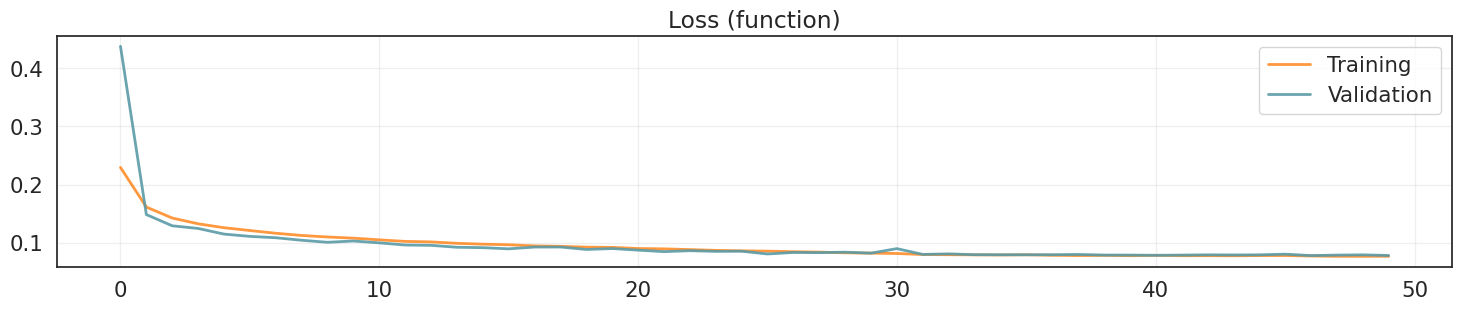

KeyError: 'accuracy'

<Figure size 1800x300 with 0 Axes>

In [ ]:
plot_history(training, loss)

In [ ]:
# Load model
model = tfk.models.load_model(model_filename, compile=False)
metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=[loss, loss, loss],
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=[metrics, metrics, metrics]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(train_dataset, model, num_samples=30)

Test Accuracy: 0.7229
Test Mean Intersection over Union: 0.428


ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
#compute predictions
preds = model.predict(X_final_test)
preds = preds[0]
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step


In [ ]:
#to pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Residual Connections

In [ ]:
def unet_trial4(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = residual_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = residual_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = residual_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = residual_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = residual_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_Trial4')
    return model

In [ ]:
training, model_filename = train_unet(
    model=unet_trial4(),
    loss_fn=loss,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name='residual_connections'
)

Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.2970 - loss: 0.3450 - mean_iou: 0.1450 - val_accuracy: 0.2245 - val_loss: 0.3079 - val_mean_iou: 0.0649 - learning_rate: 1.0000e-05
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.4715 - loss: 0.1779 - mean_iou: 0.2426 - val_accuracy: 0.5379 - val_loss: 0.1537 - val_mean_iou: 0.2880 - learning_rate: 1.0000e-05
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.5234 - loss: 0.1527 - mean_iou: 0.2704 - val_accuracy: 0.5720 - val_loss: 0.1400 - val_mean_iou: 0.3054 - learning_rate: 1.0000e-05
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.5492 - loss: 0.1413 - mean_iou: 0.2853 - val_accuracy: 0.5953 - val_loss: 0.1300 - val_mean_iou: 0.3230 - learning_rate: 1.0000e-05
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.5649 - loss: 0.1352 - mean_iou: 0.2958 - val_accuracy: 0.6070 - val_loss: 0.1243 - val_mean_iou: 0.3298 - learning_rate: 1.0000e-05


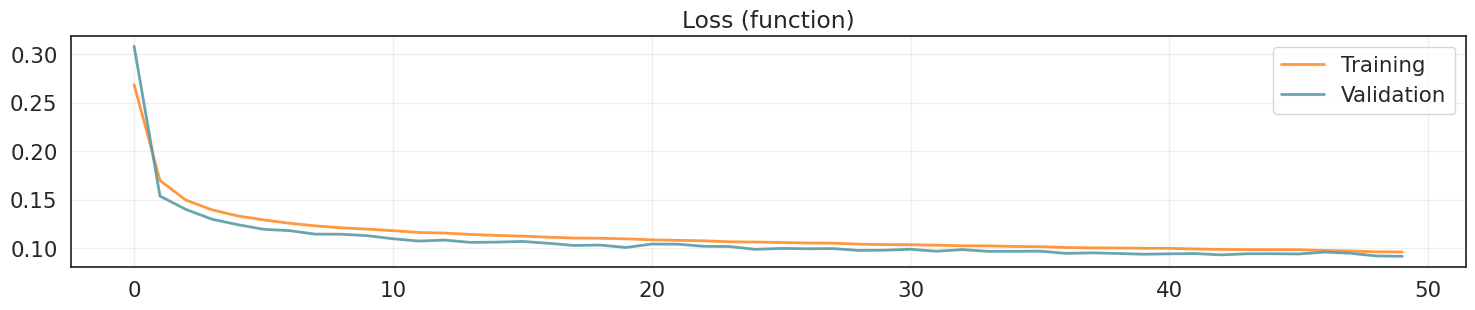

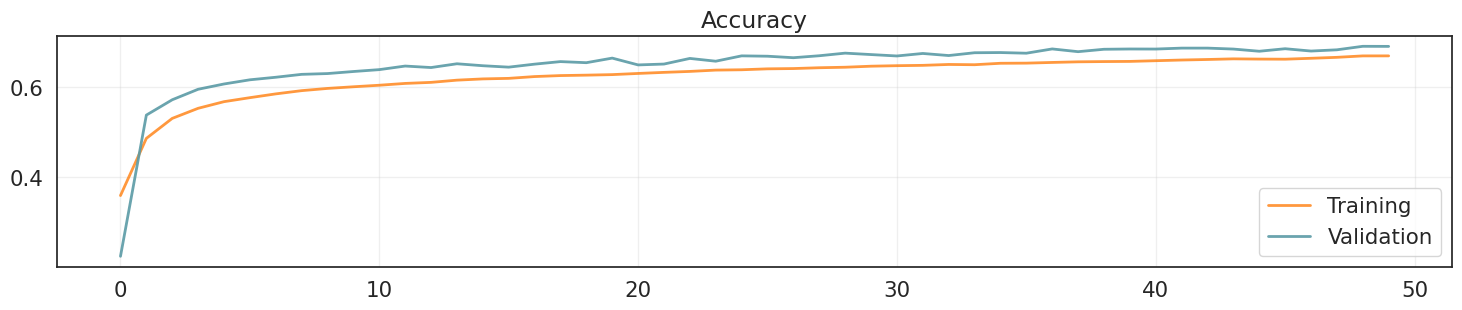

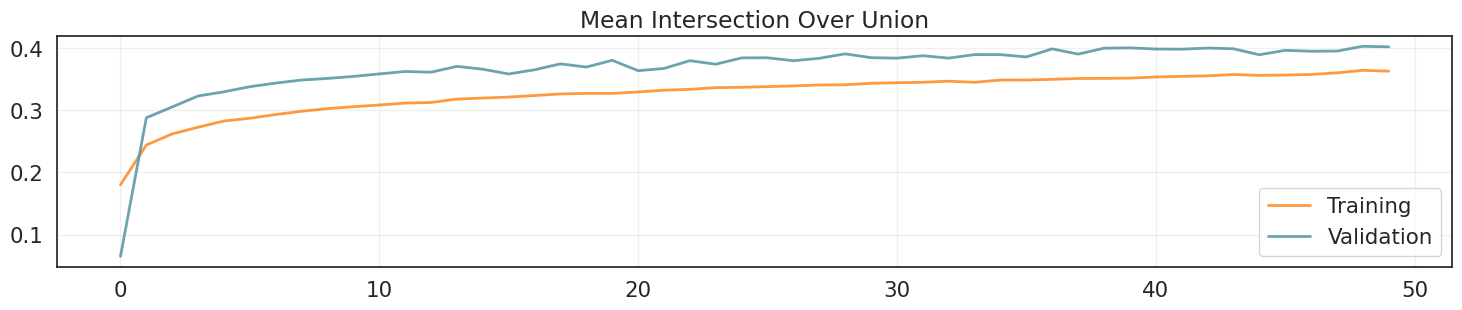

In [ ]:
plot_history(training, loss)

Test Accuracy: 0.6784
Test Mean Intersection over Union: 0.3901


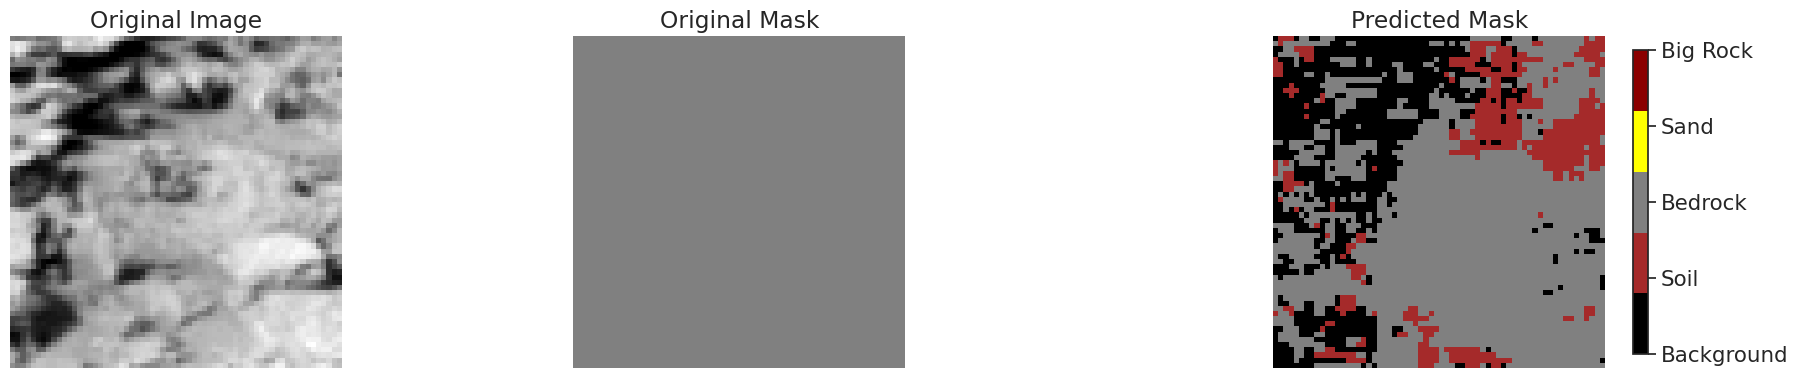

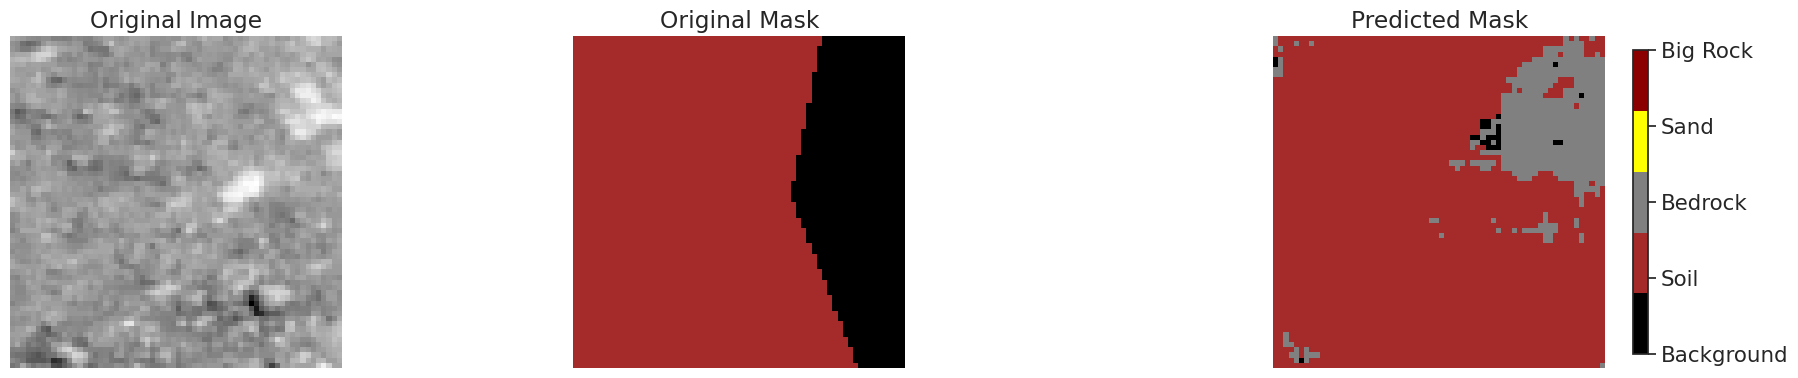

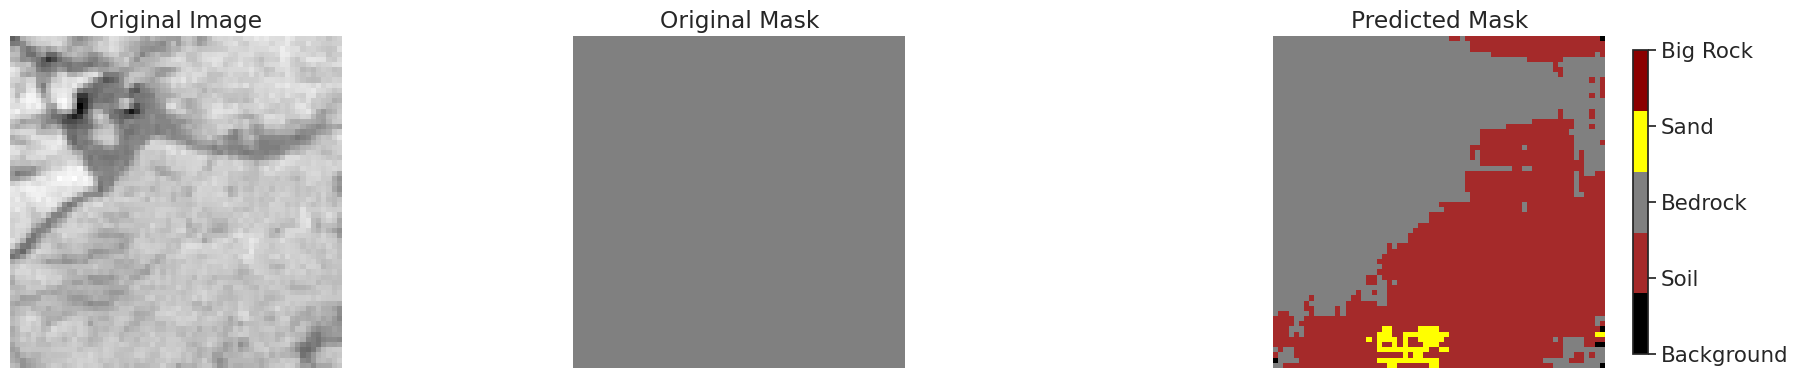

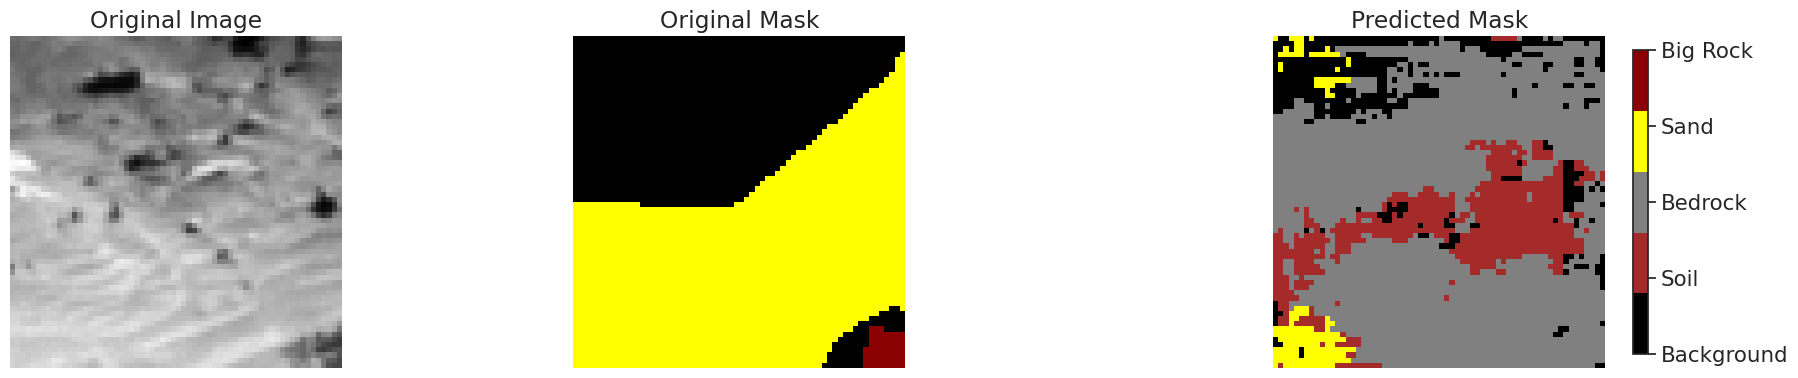

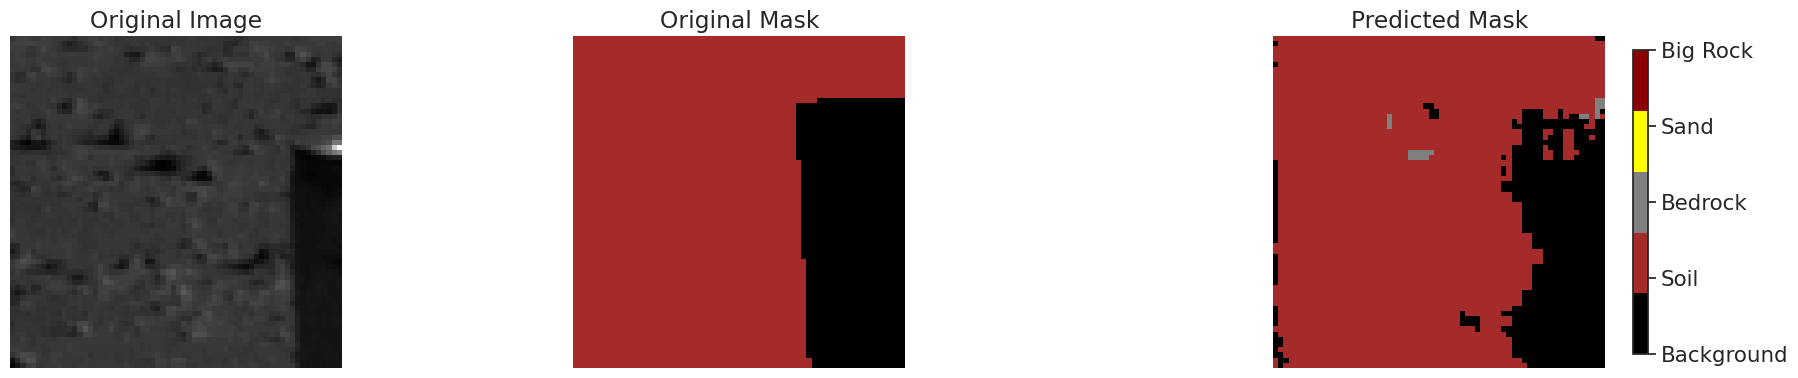

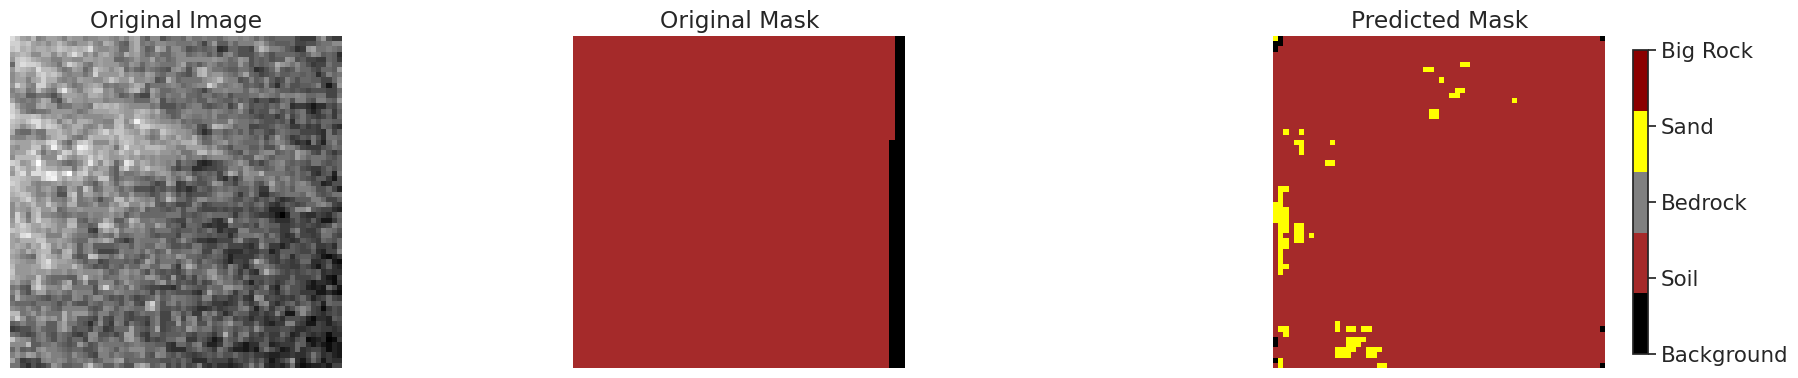

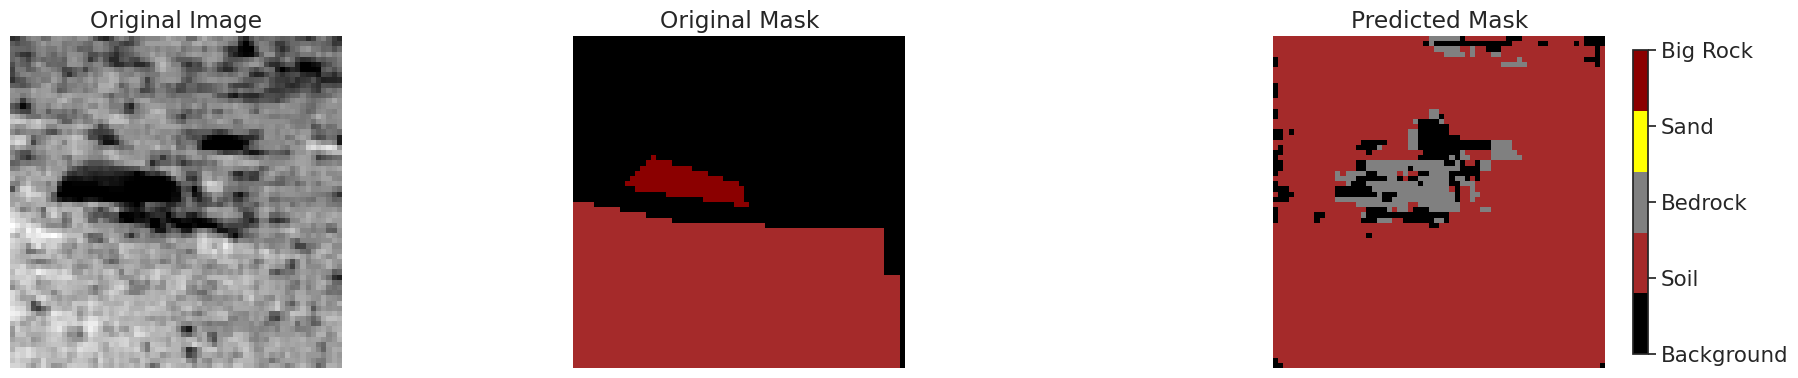

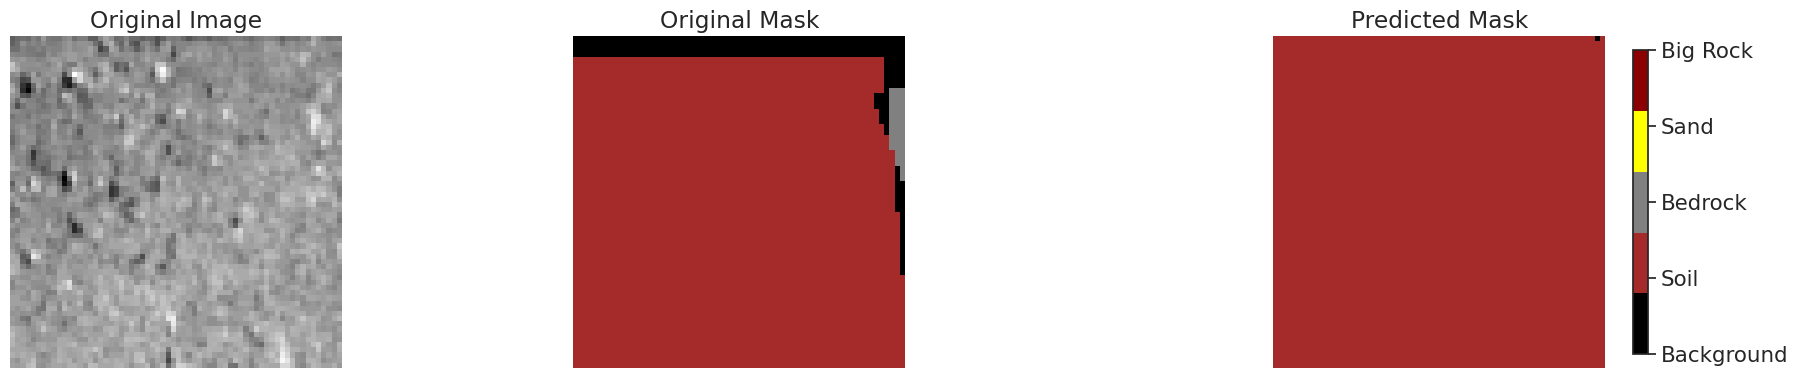

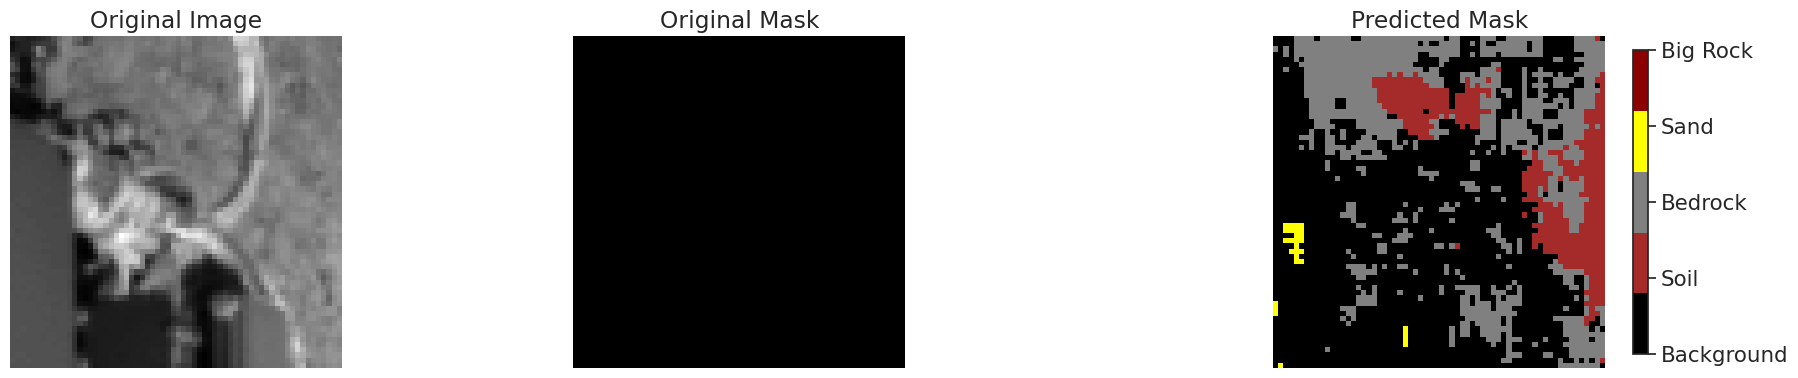

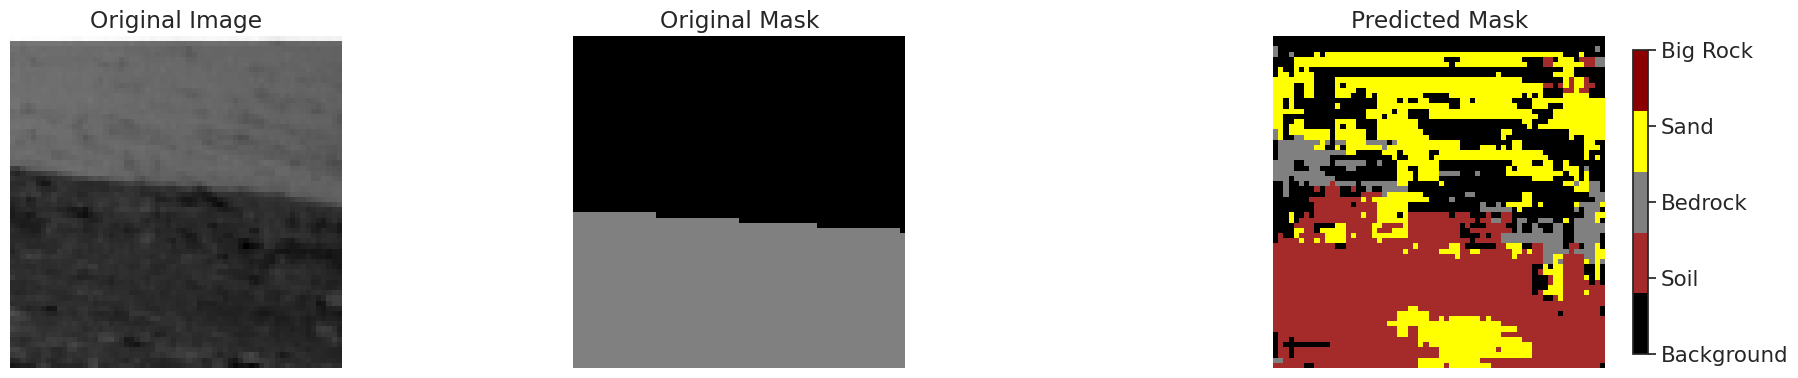

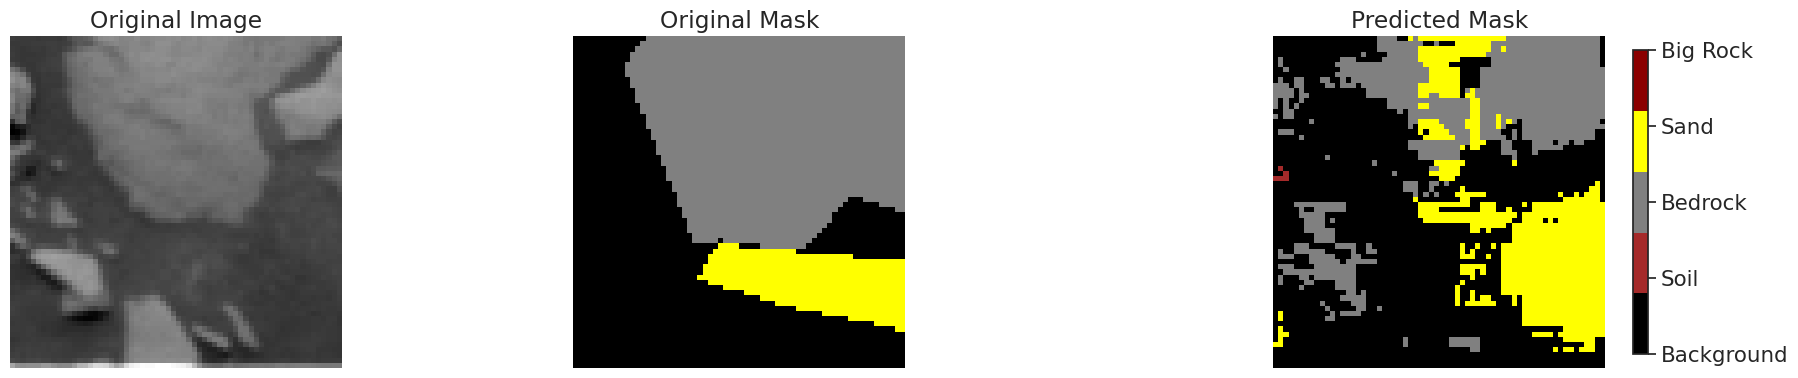

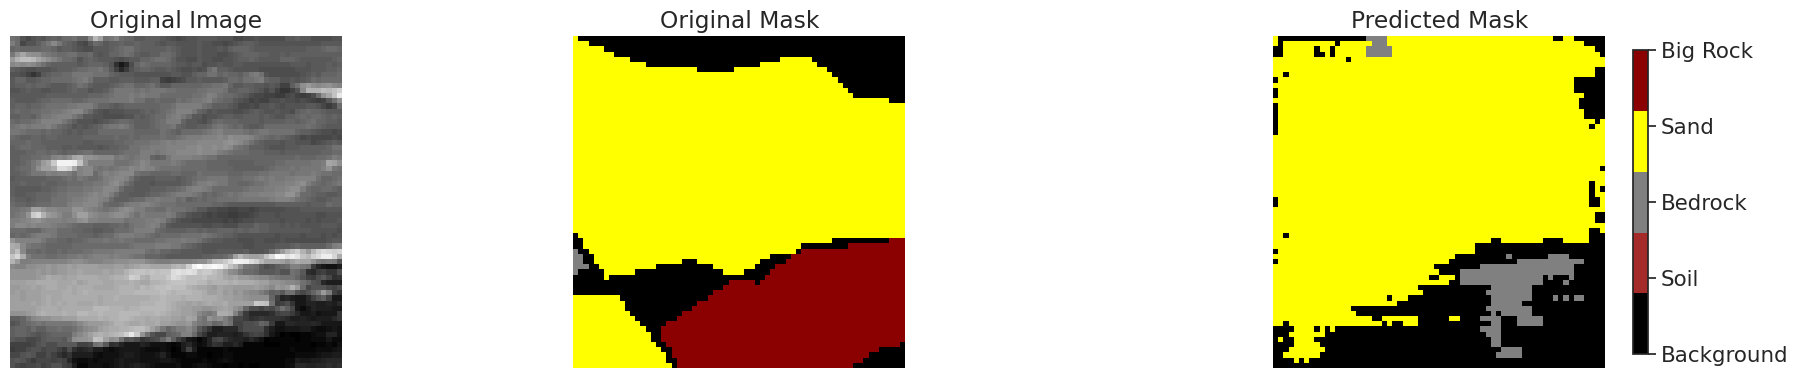

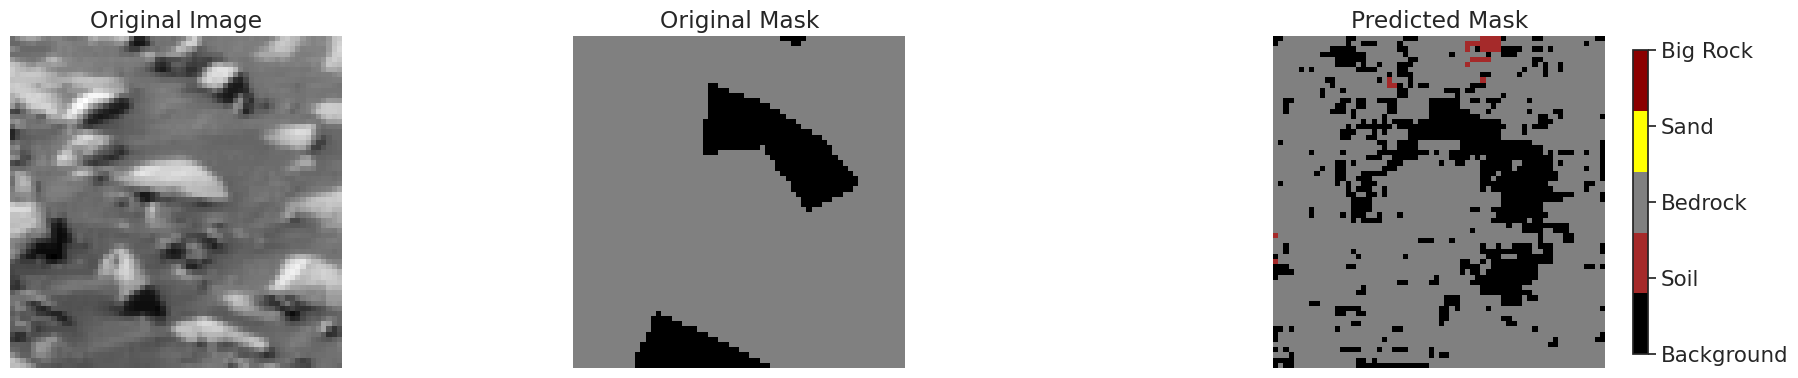

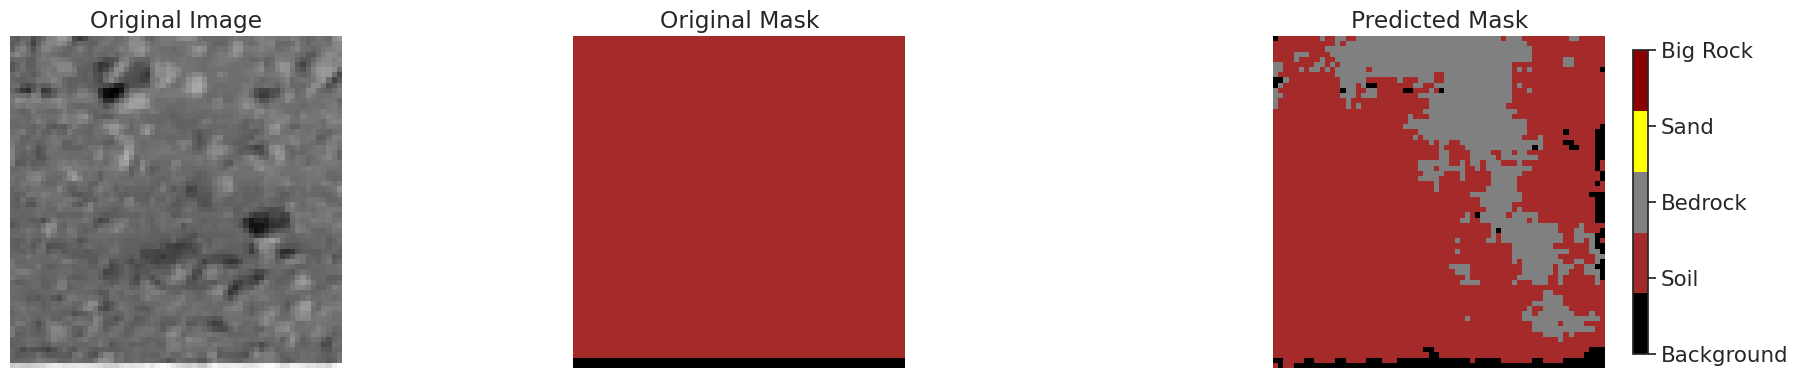

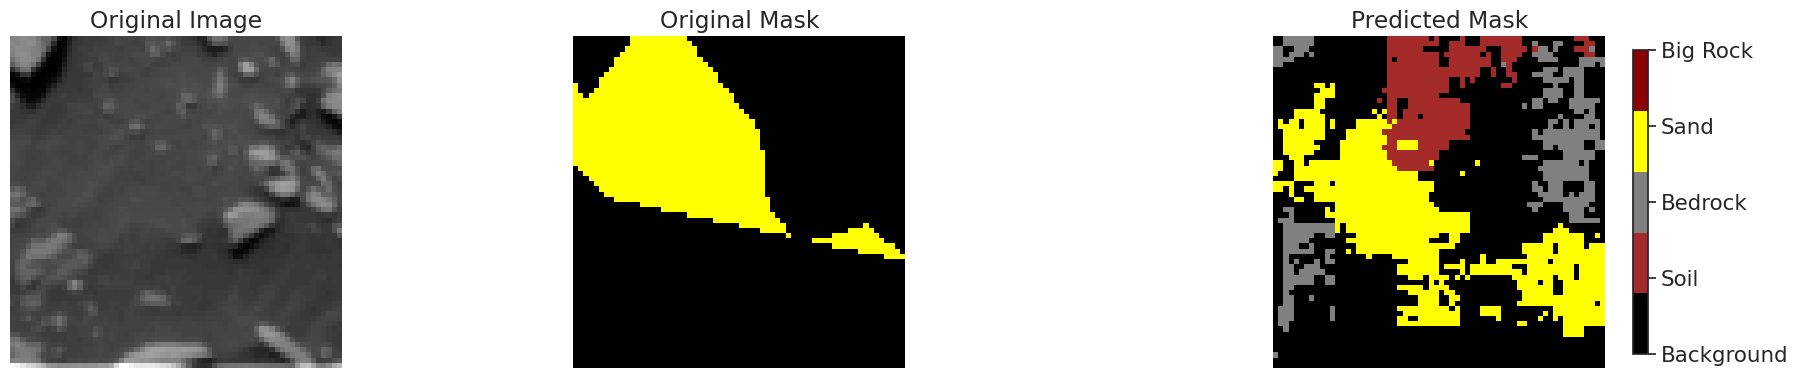

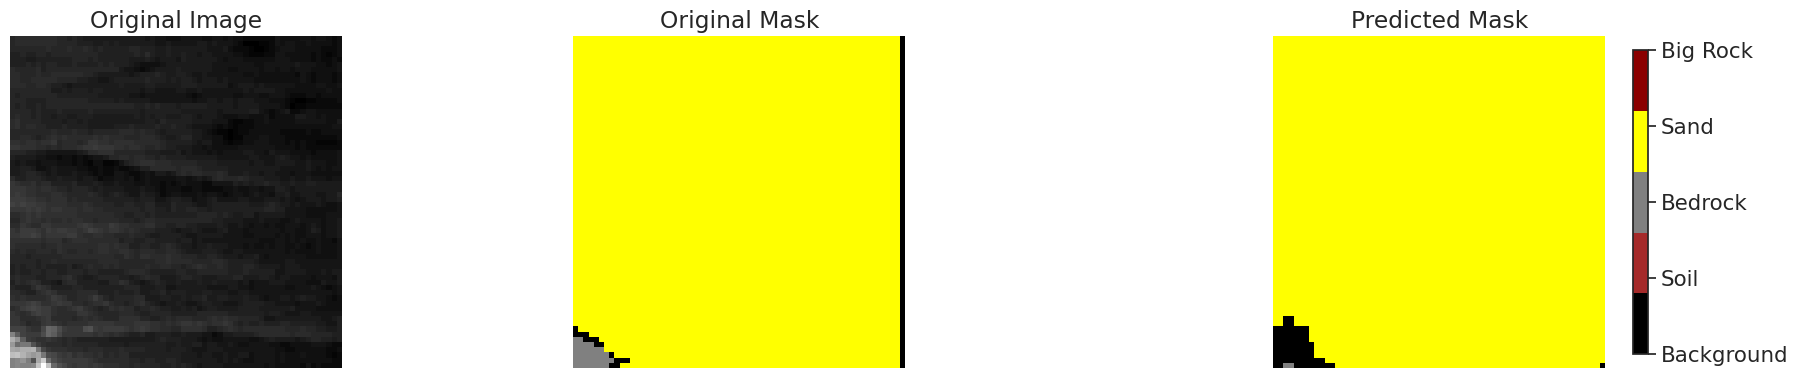

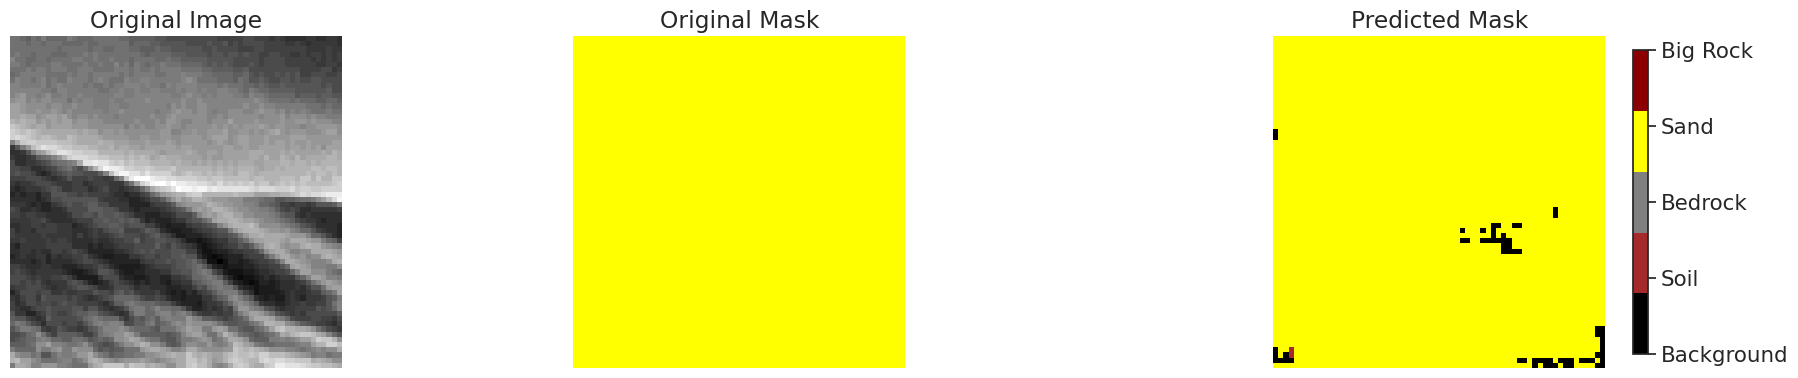

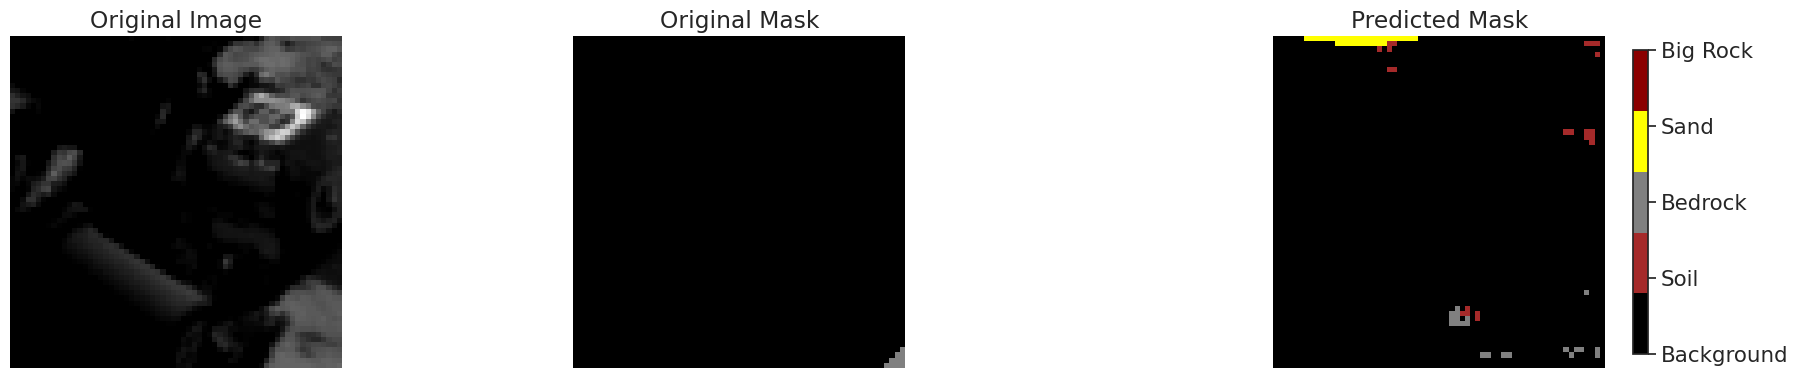

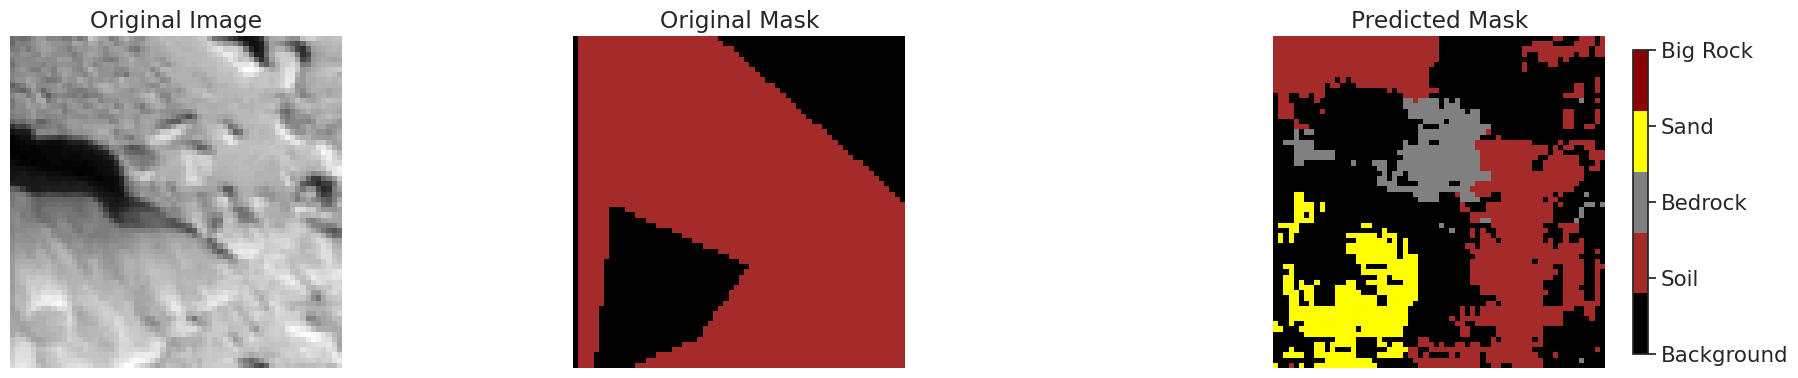

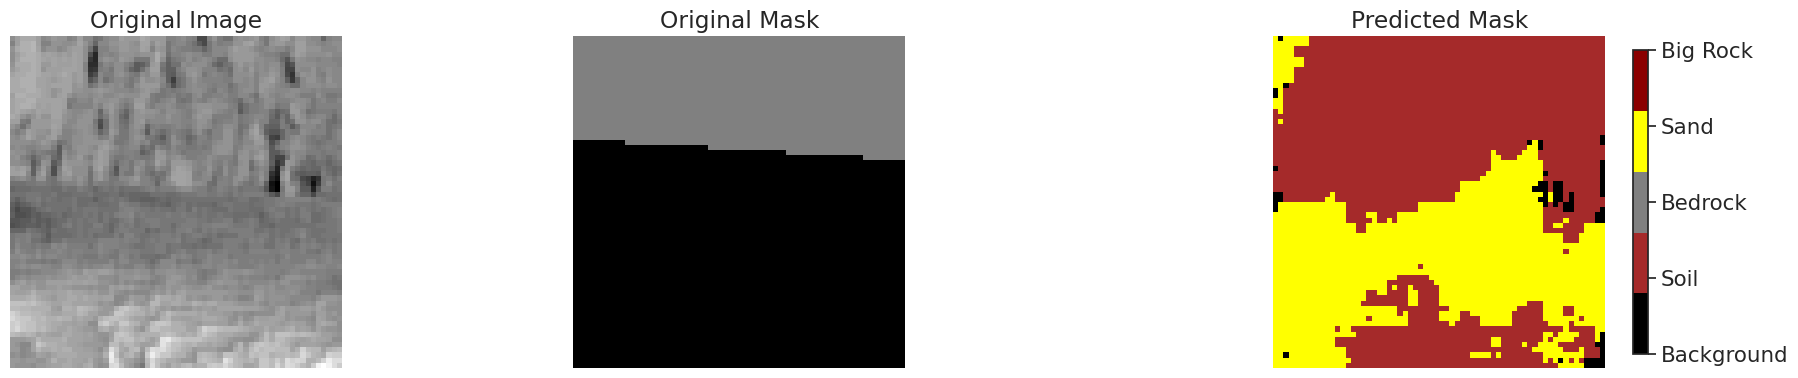

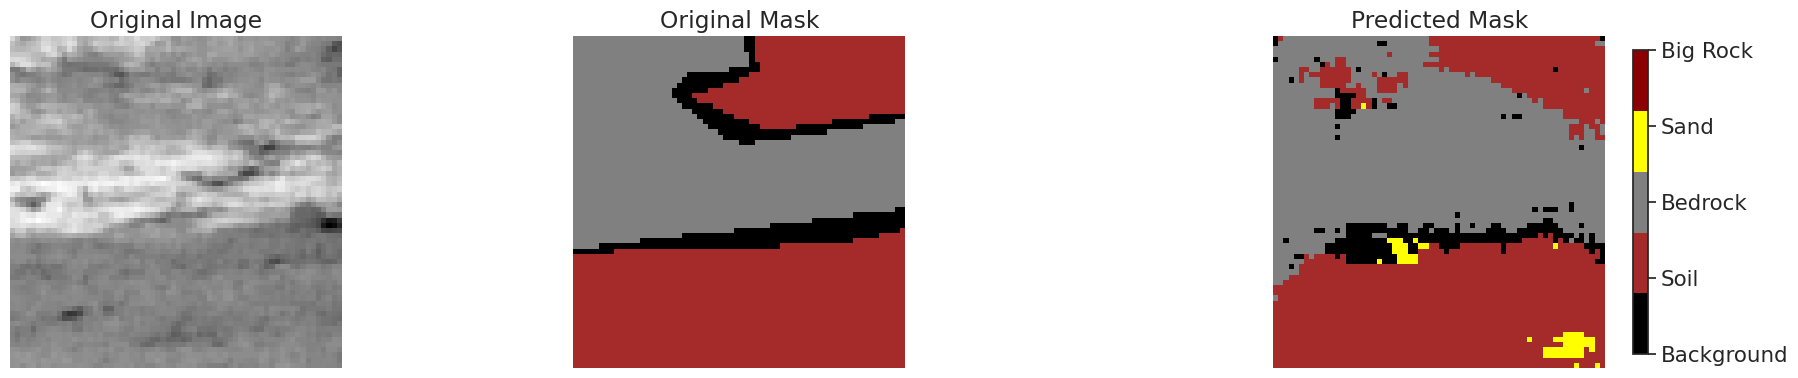

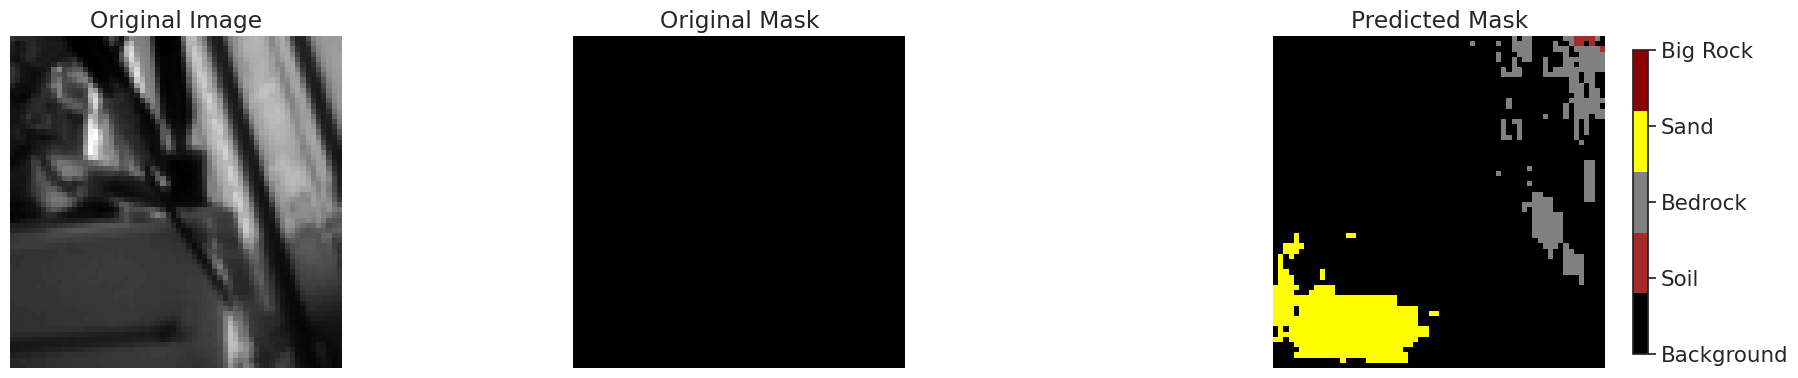

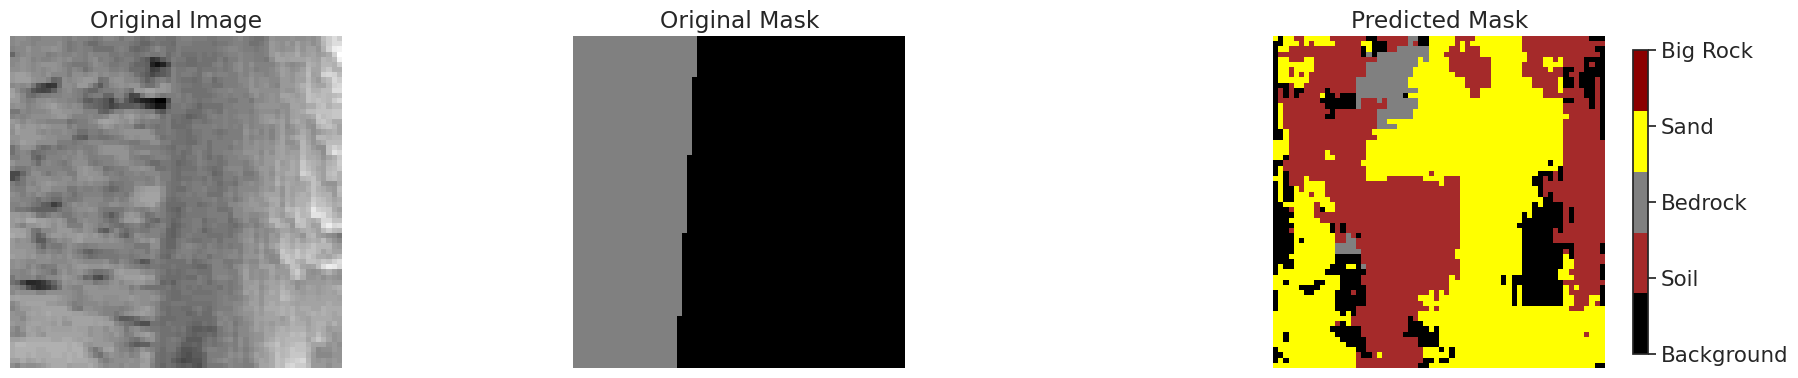

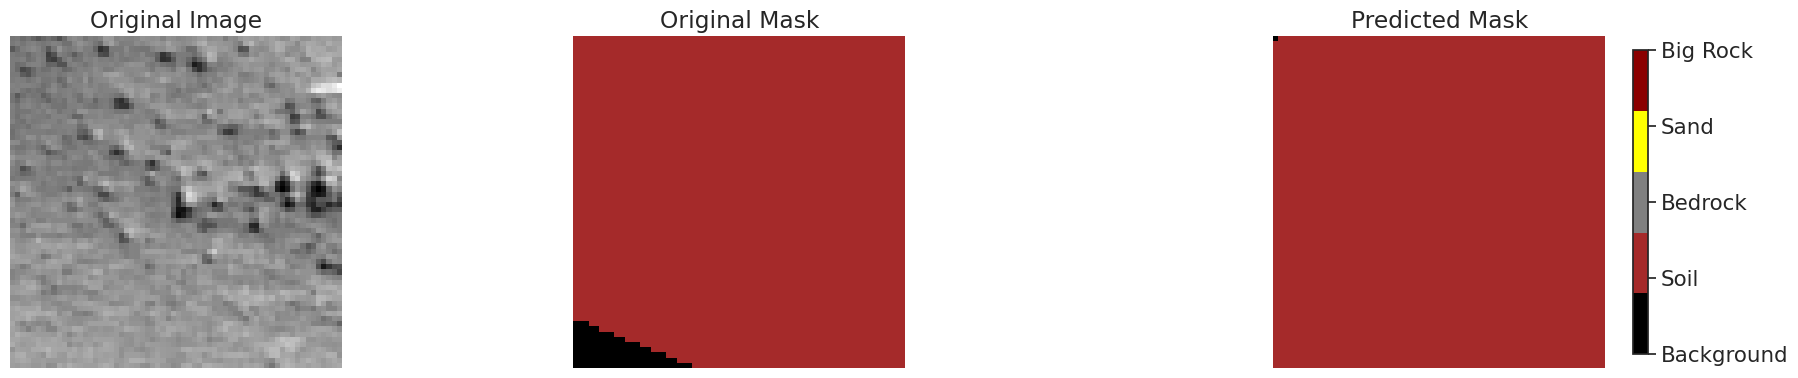

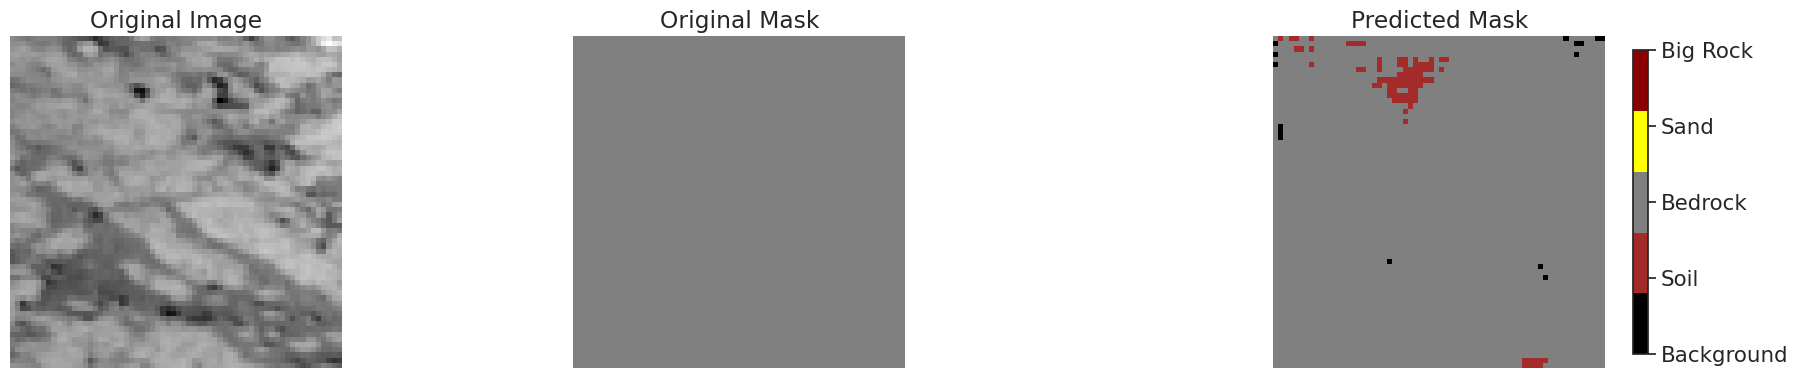

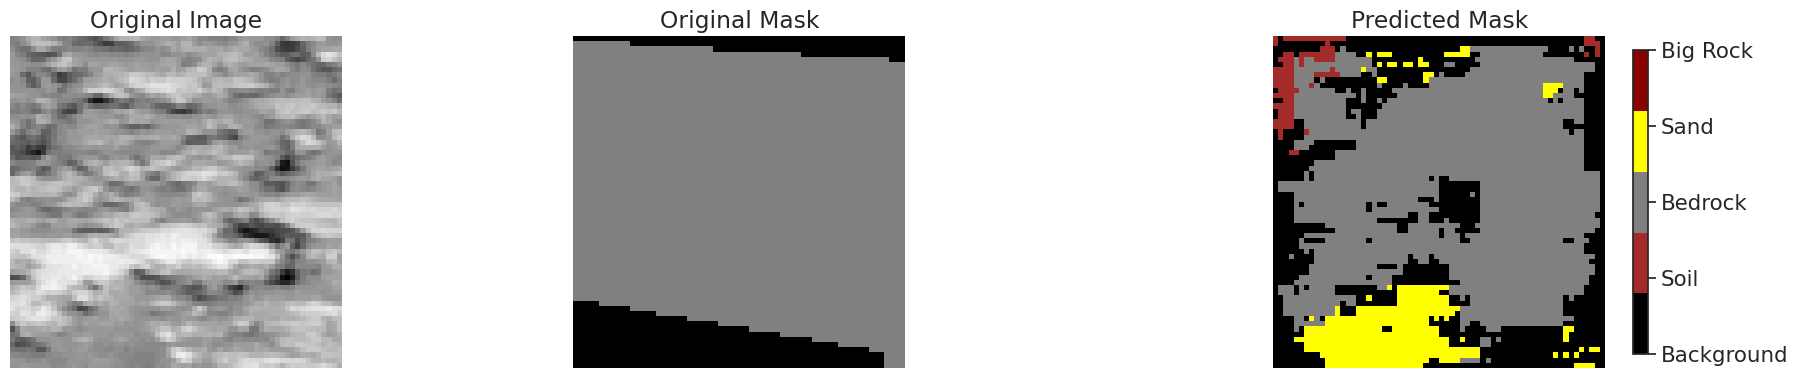

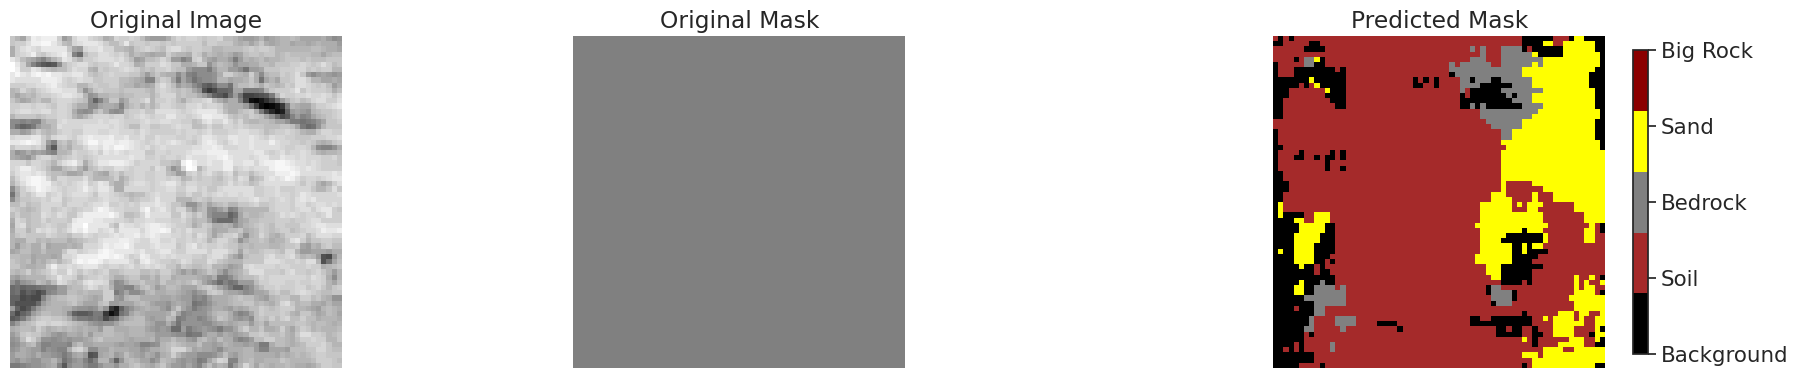

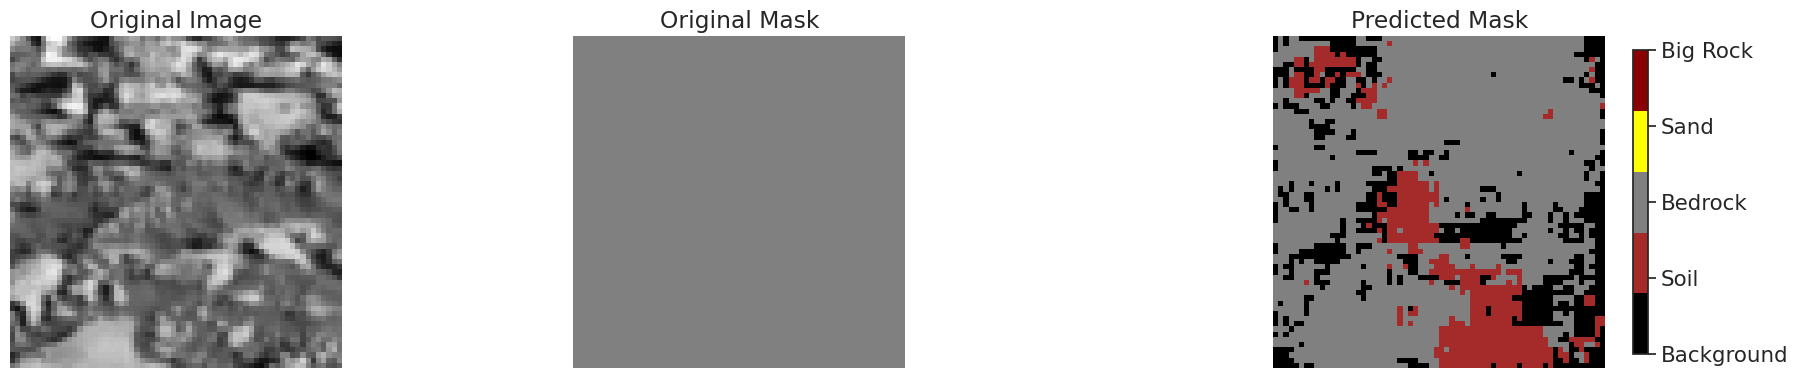

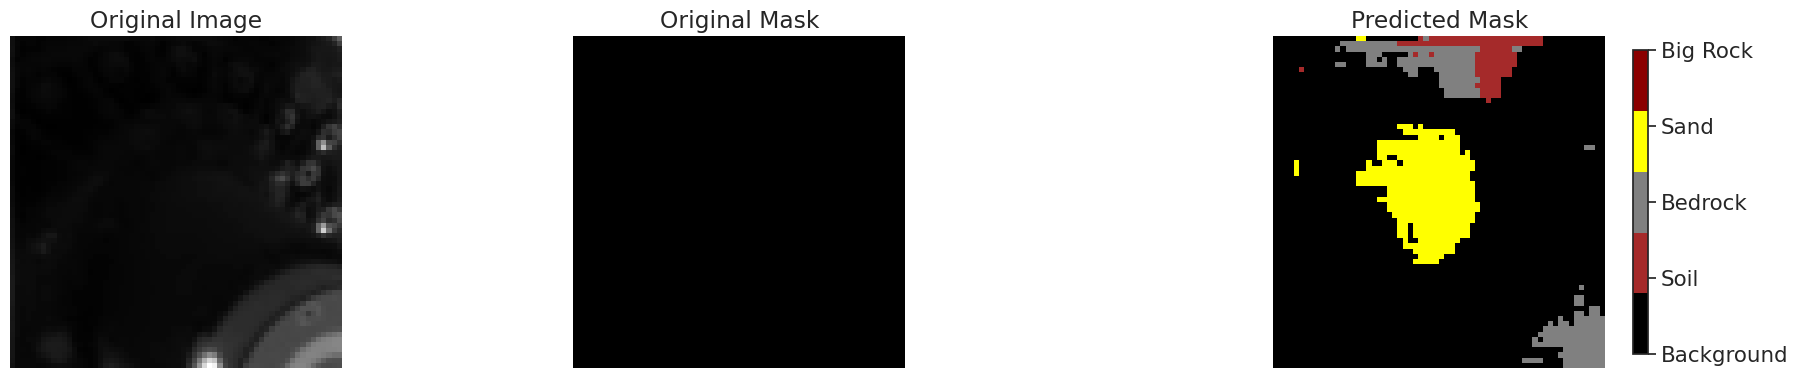

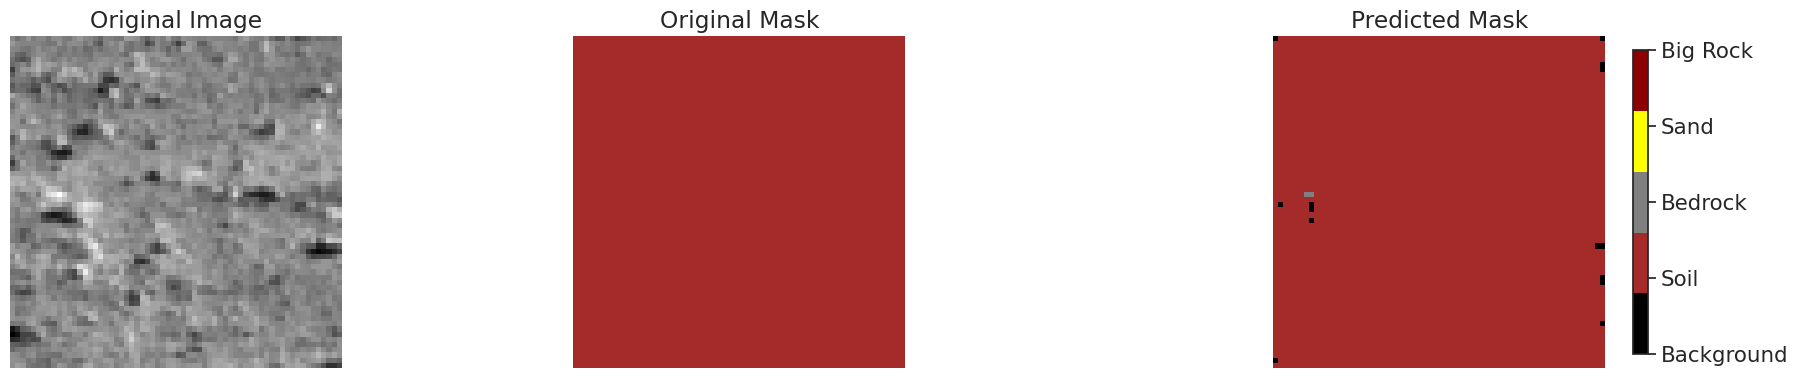

In [ ]:
# Load model
model = tfk.models.load_model(model_filename, compile=False)
model.compile()
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(train_dataset, model, num_samples=30)

In [ ]:
#compute predictions
preds = model.predict(X_final_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


In [ ]:
#to pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Attention Decoder

In [ ]:
def unet_trial2(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block_bottleneck(d2, 128, name='bottleneck')

    # Upsampling path with attention gates
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = attention_gate(down_block_2, u1, 64, 'attention1')
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = attention_gate(down_block_1, u2, 32, 'attention2')
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_Trial2')
    return model

In [ ]:
training, model_filename = train_unet(
    model=unet_trial2(),
    loss_fn=loss,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name='attention_decoder'
)

Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step - accuracy: 0.2391 - loss: 0.3038 - mean_iou: 0.1100 - val_accuracy: 0.2266 - val_loss: 0.2728 - val_mean_iou: 0.0716 - learning_rate: 1.0000e-05
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.4011 - loss: 0.2284 - mean_iou: 0.1930 - val_accuracy: 0.5056 - val_loss: 0.2010 - val_mean_iou: 0.2652 - learning_rate: 1.0000e-05
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.5033 - loss: 0.1937 - mean_iou: 0.2593 - val_accuracy: 0.5767 - val_loss: 0.1721 - val_mean_iou: 0.3152 - learning_rate: 1.0000e-05
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.5522 - loss: 0.1738 - mean_iou: 0.2909 - val_accuracy: 0.6097 - val_loss: 0.1559 - val_mean_iou: 0.3423 - learning_rate: 1.0000e-05
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.5779 - loss: 0.1619 - mean_iou: 0.3075 - val_accuracy: 0.6243 - val_loss: 0.1463 - val_mean_iou: 0.3490 - learning_rate: 1.0000e-05

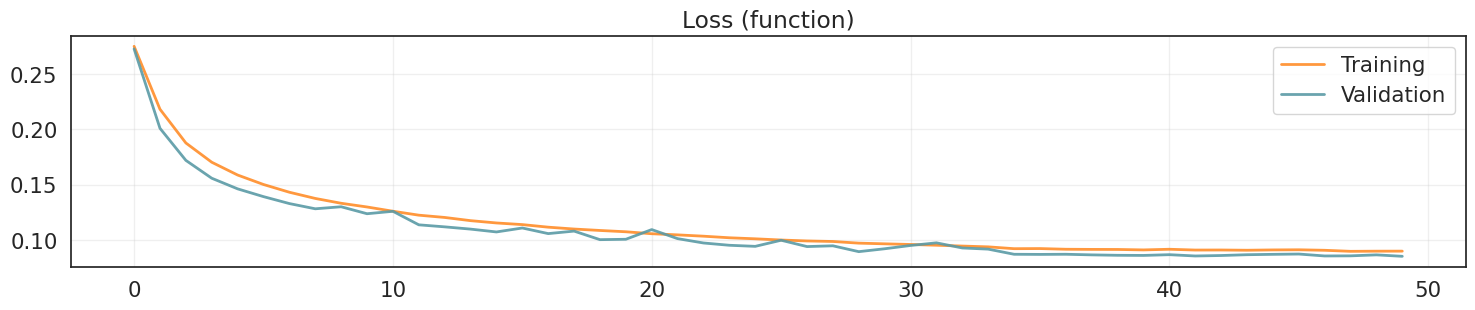

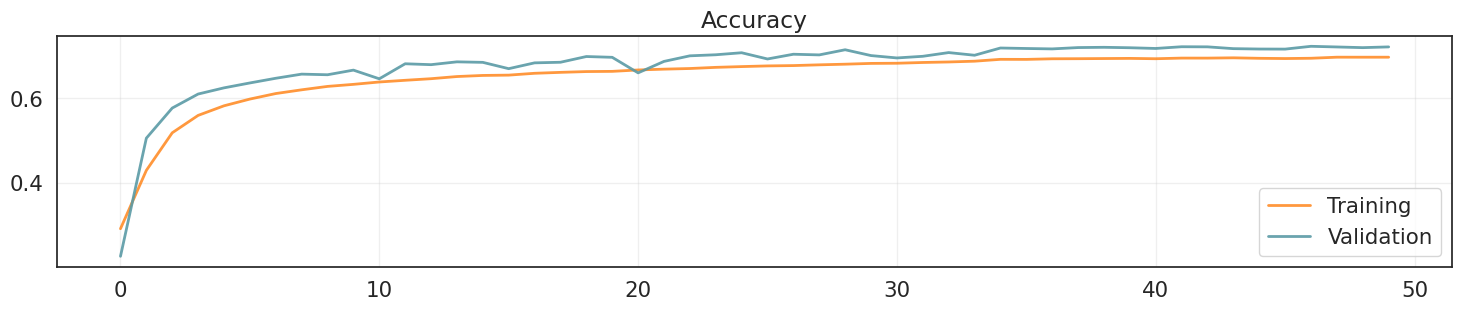

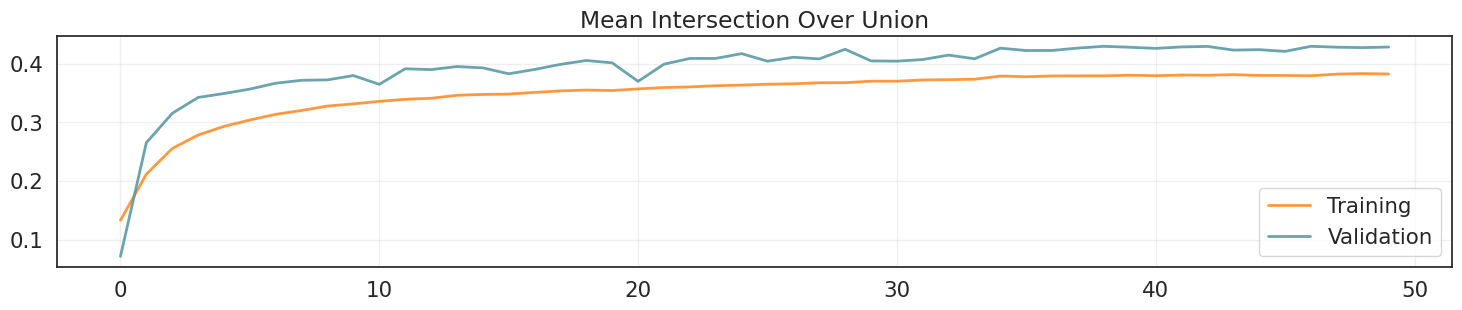

In [ ]:
plot_history(training, loss)

Test Accuracy: 0.7026
Test Mean Intersection over Union: 0.4101


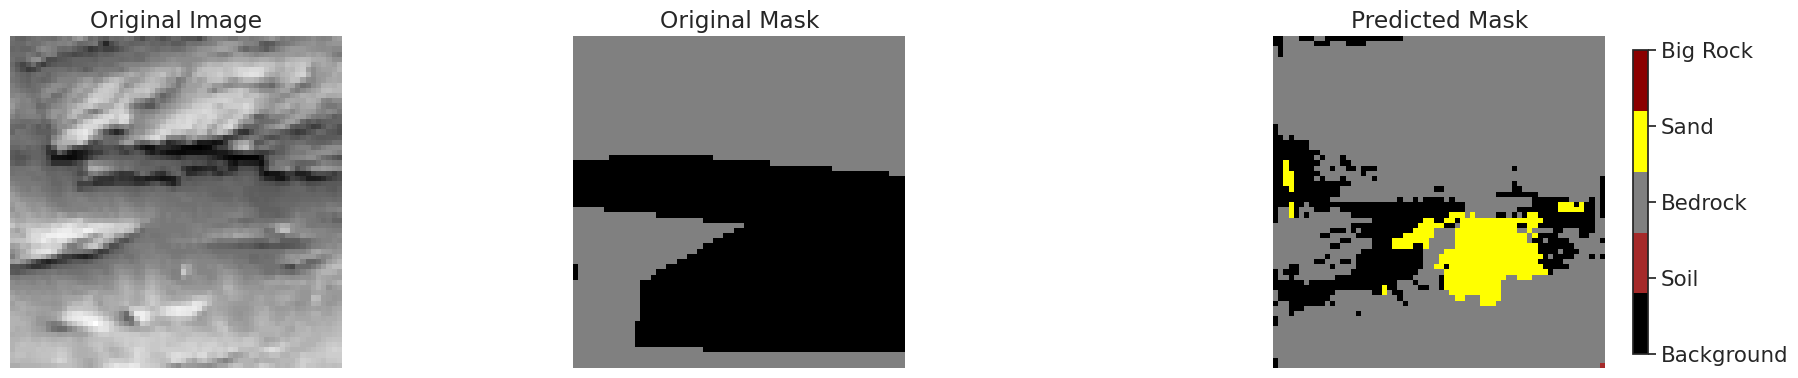

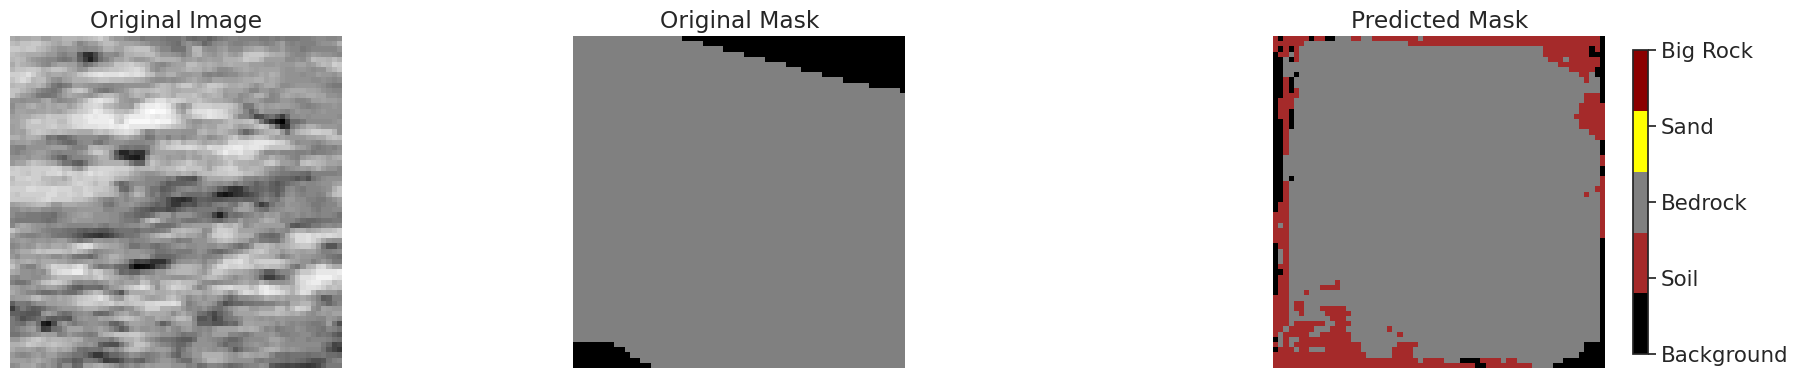

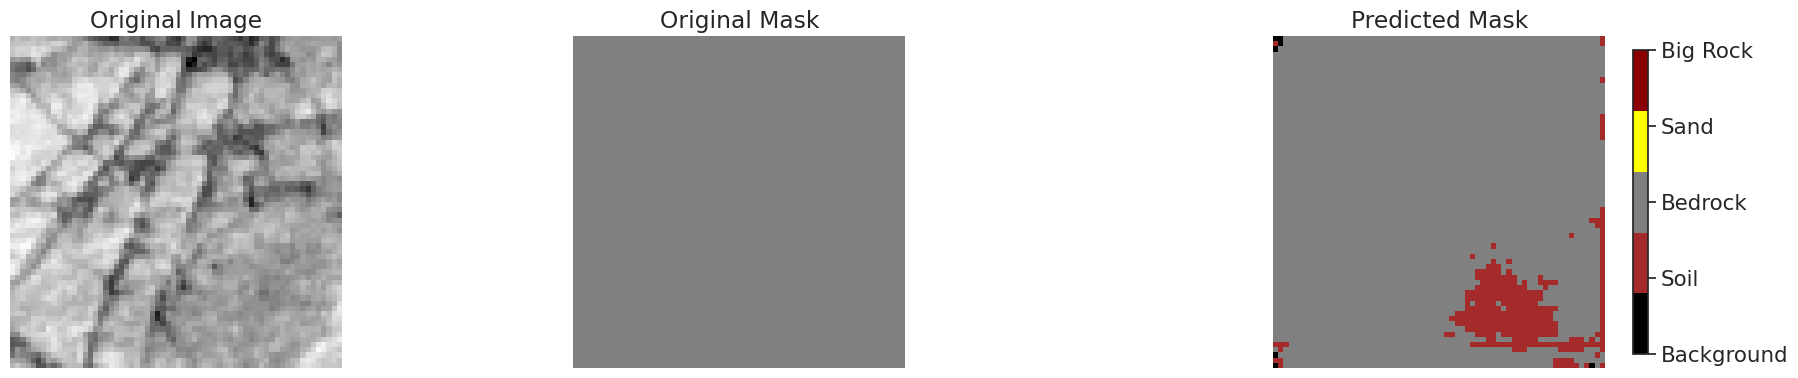

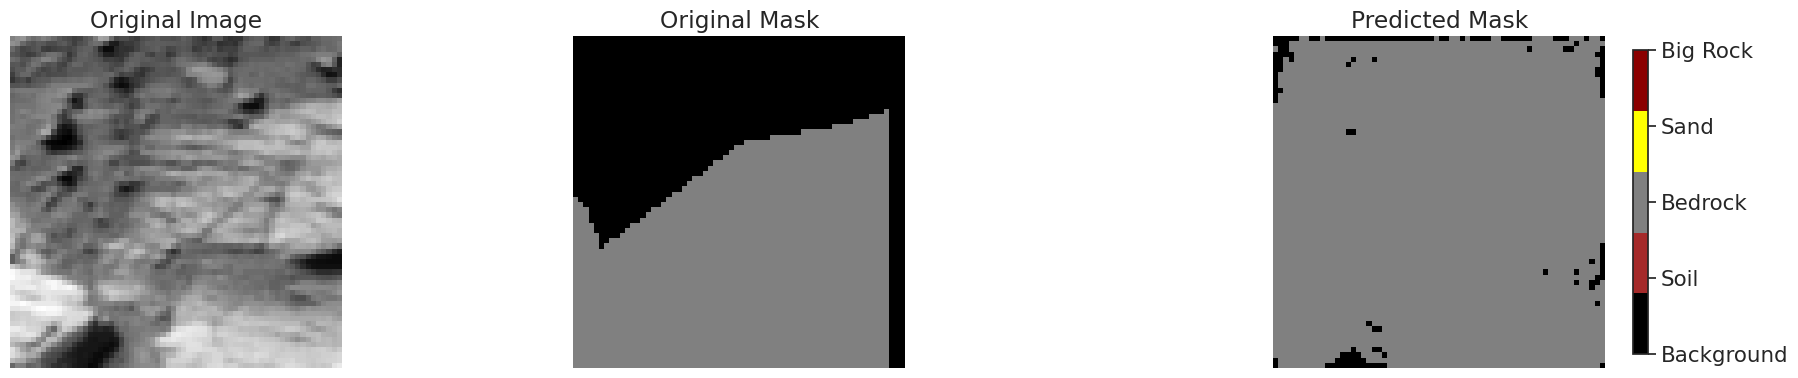

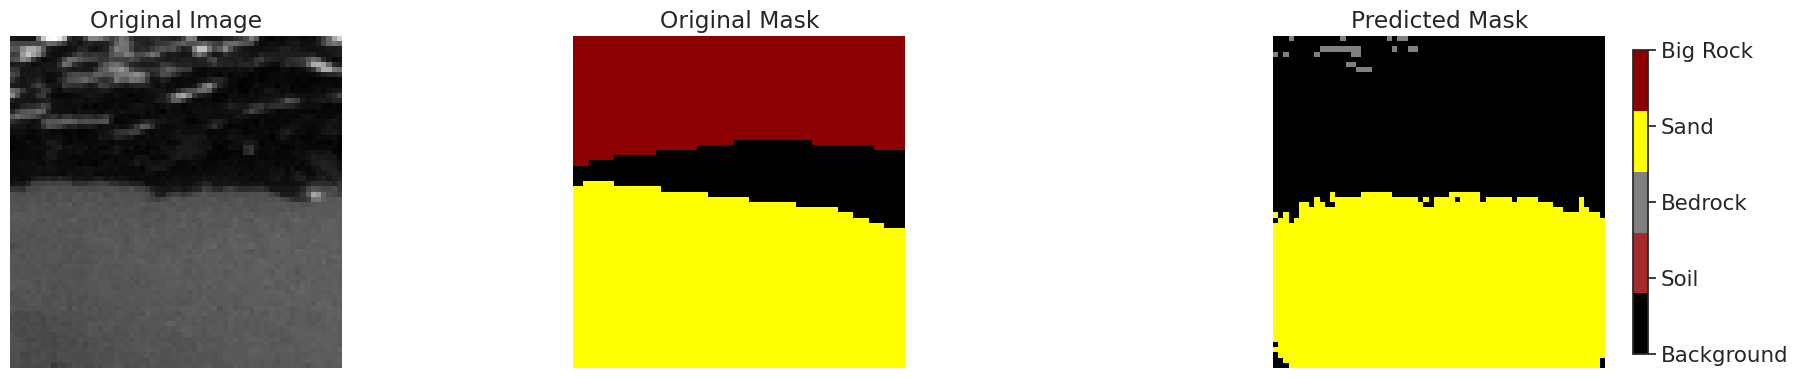

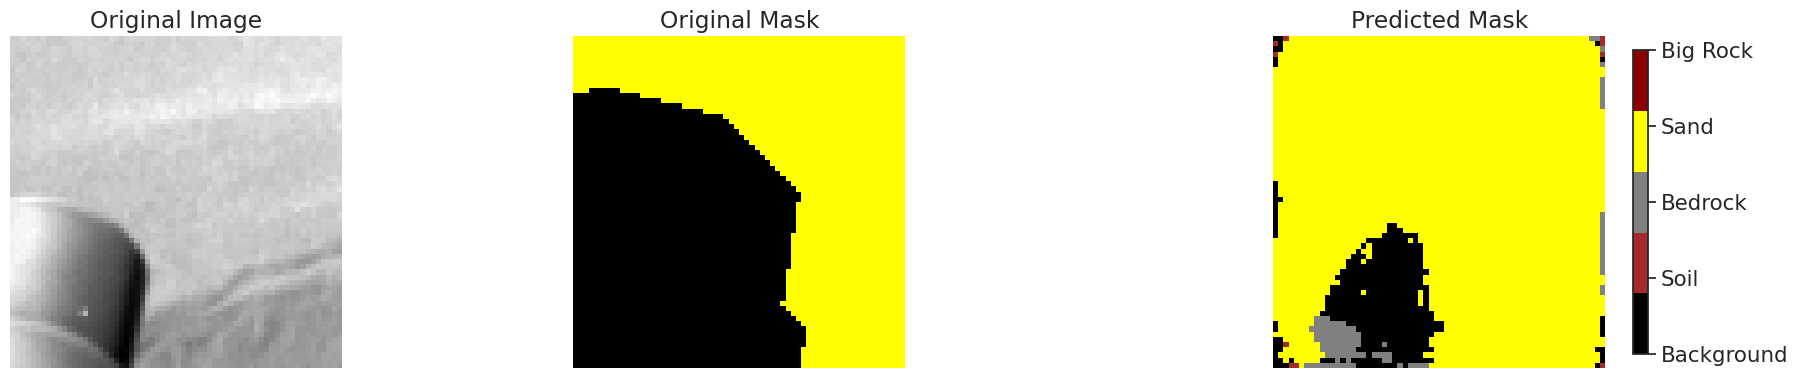

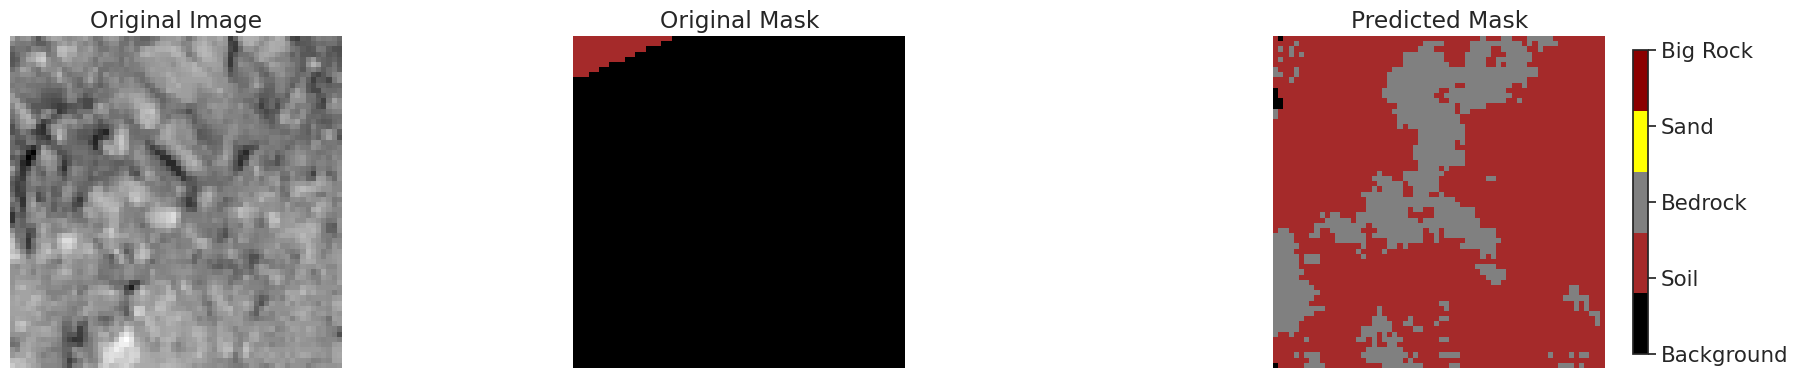

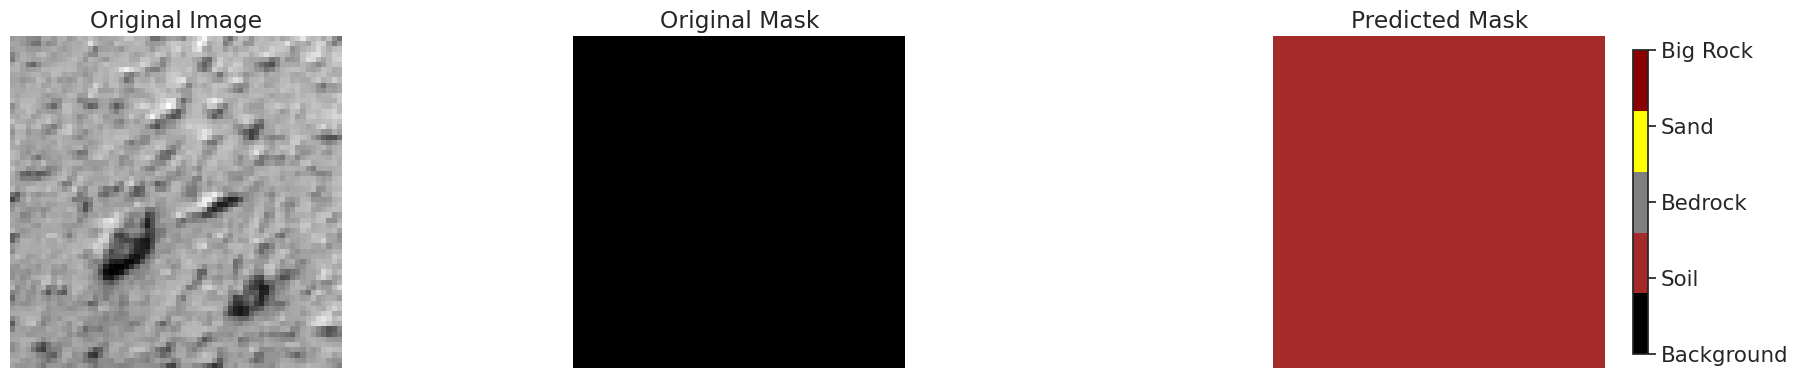

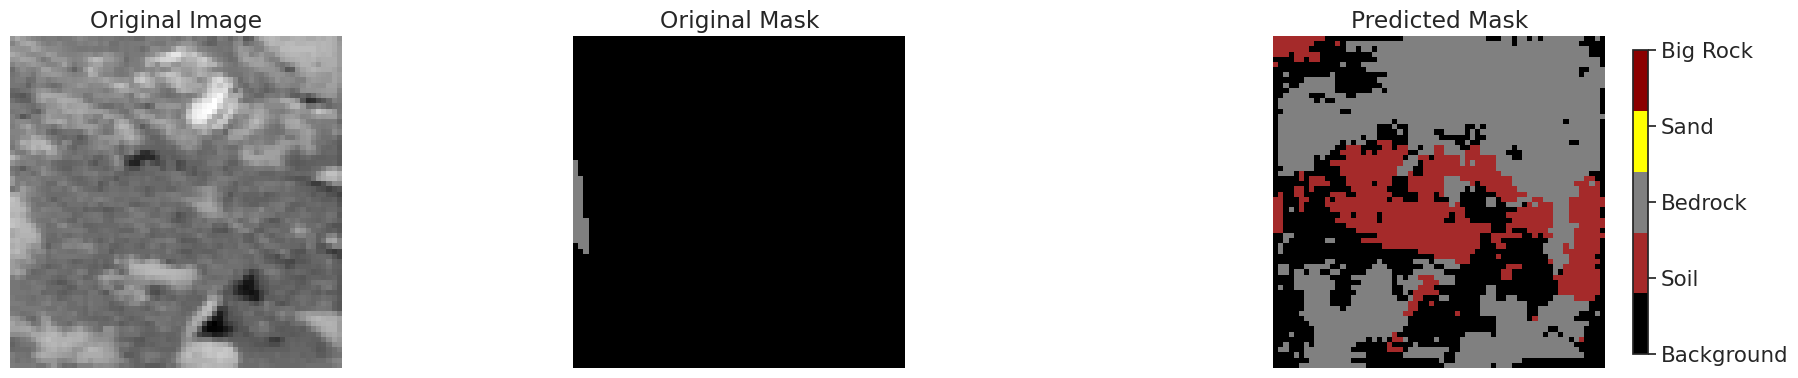

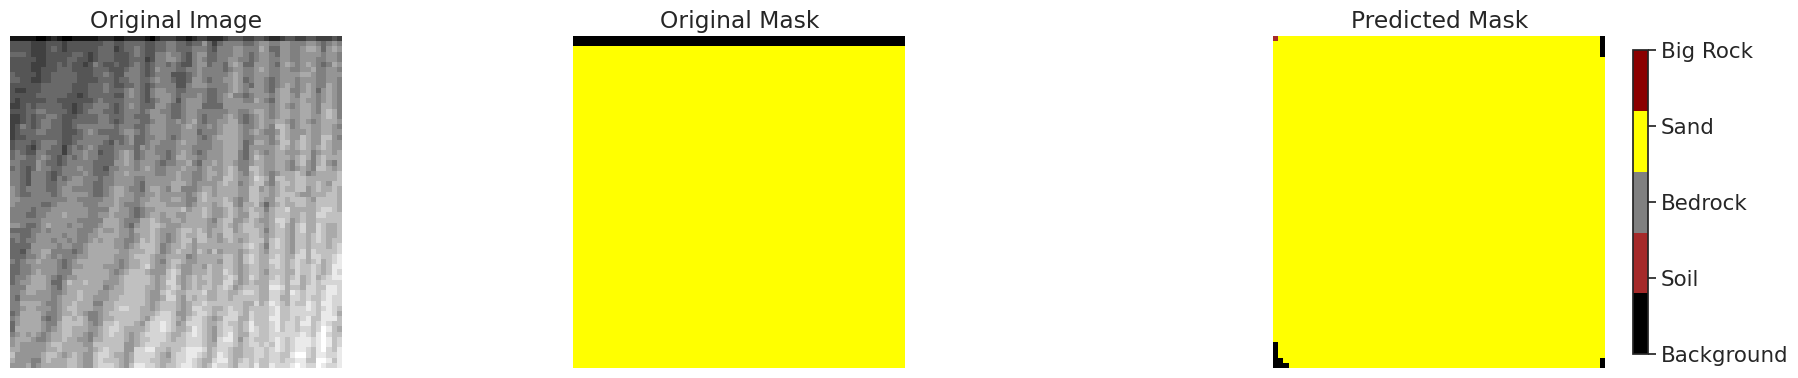

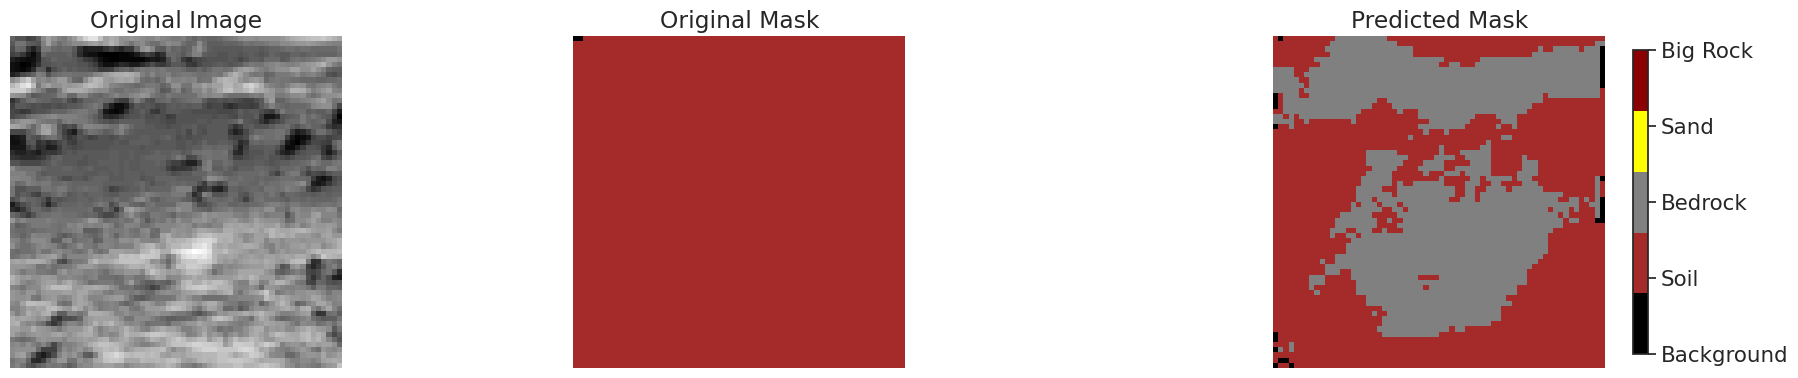

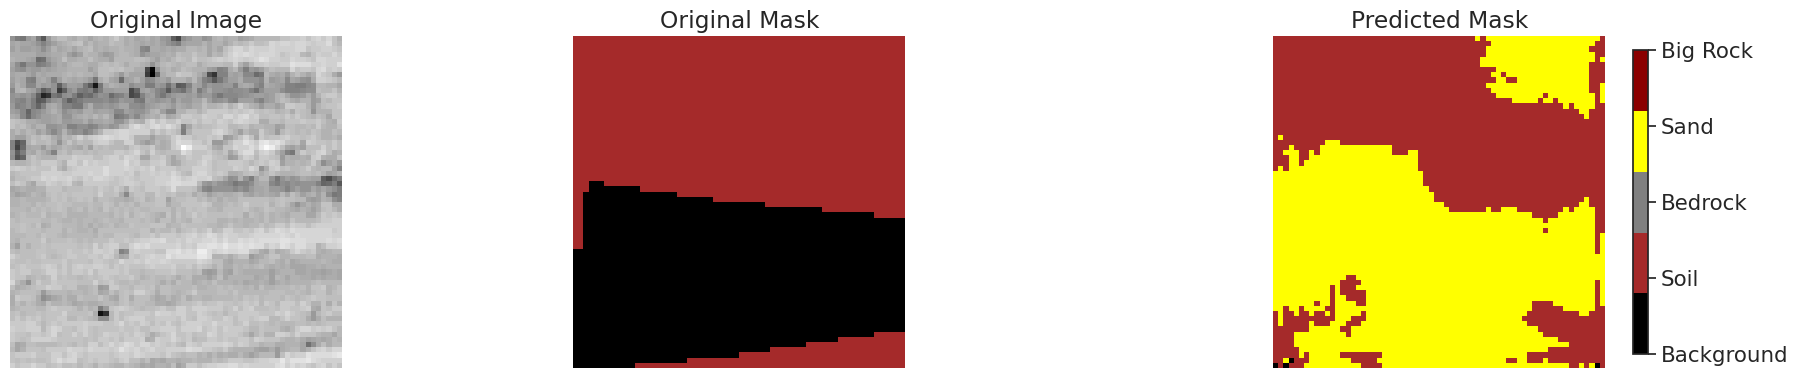

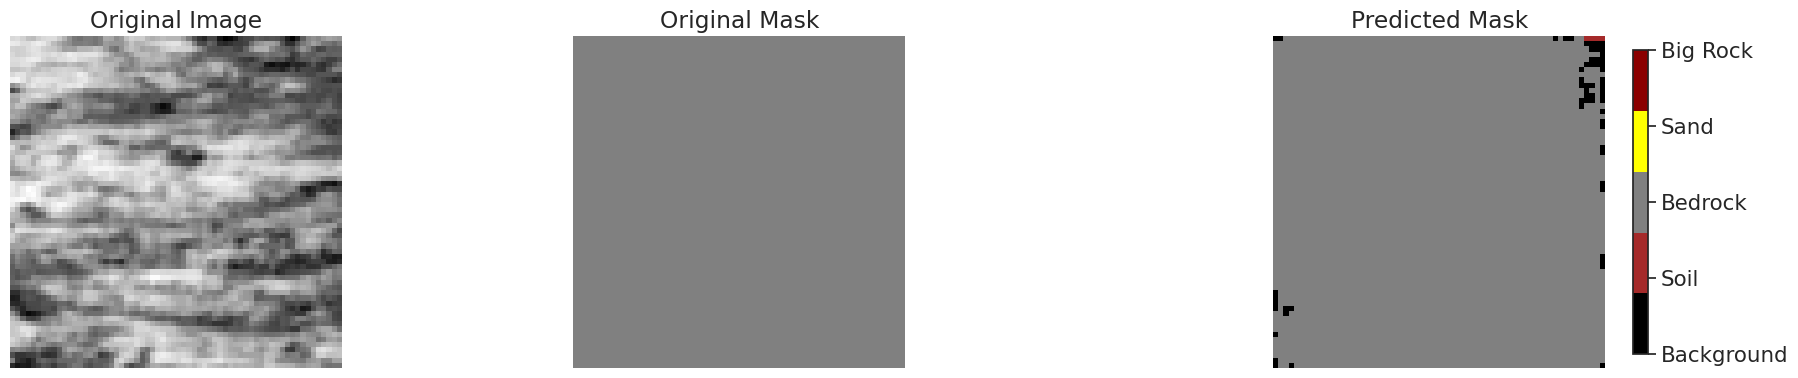

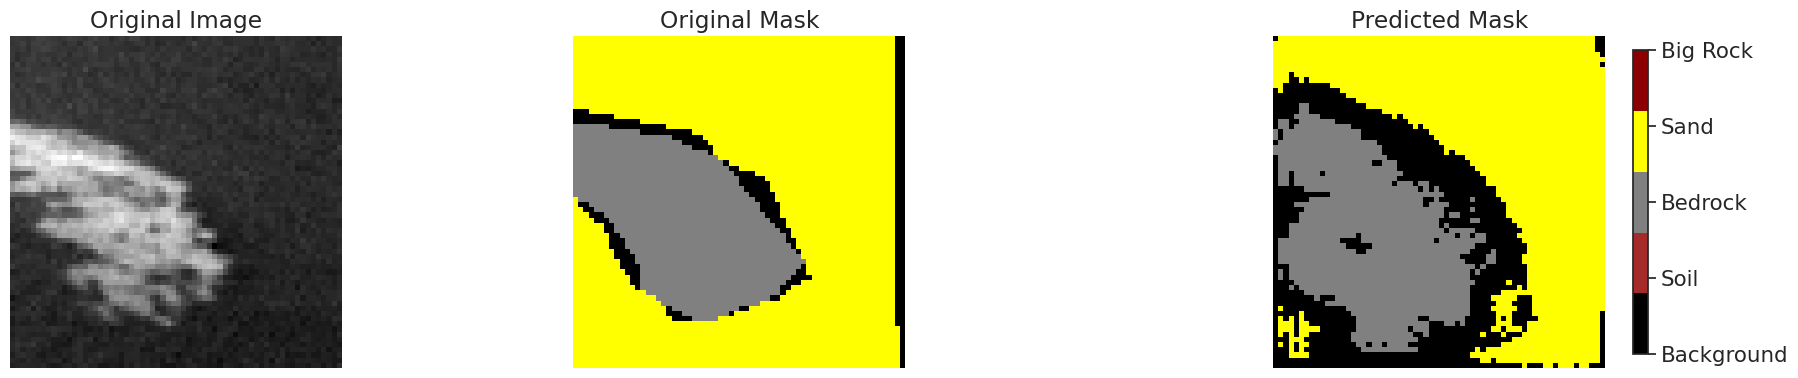

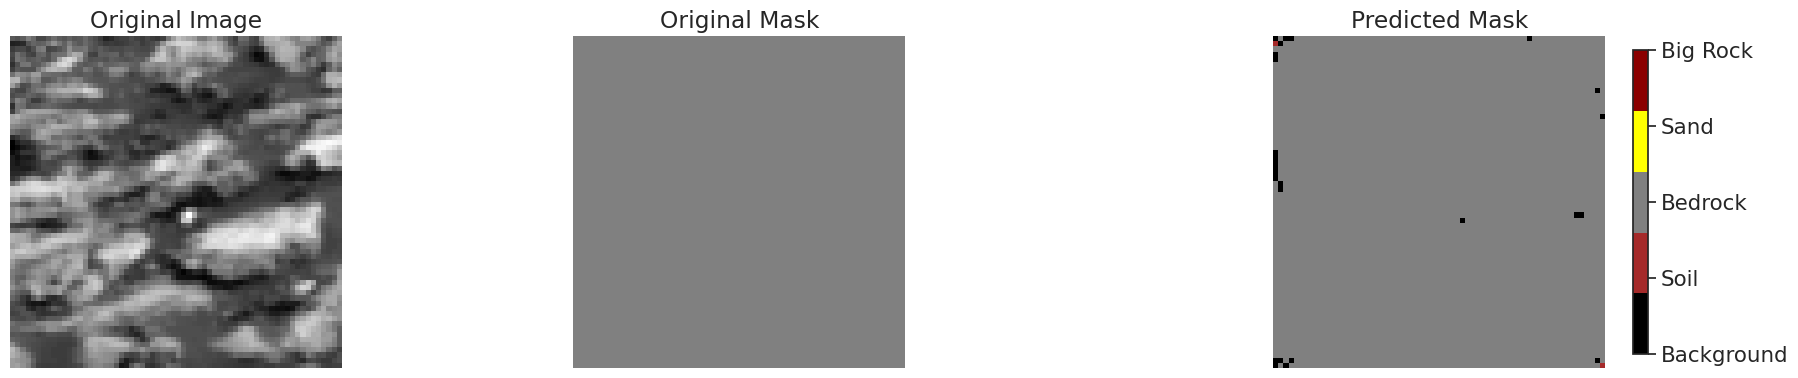

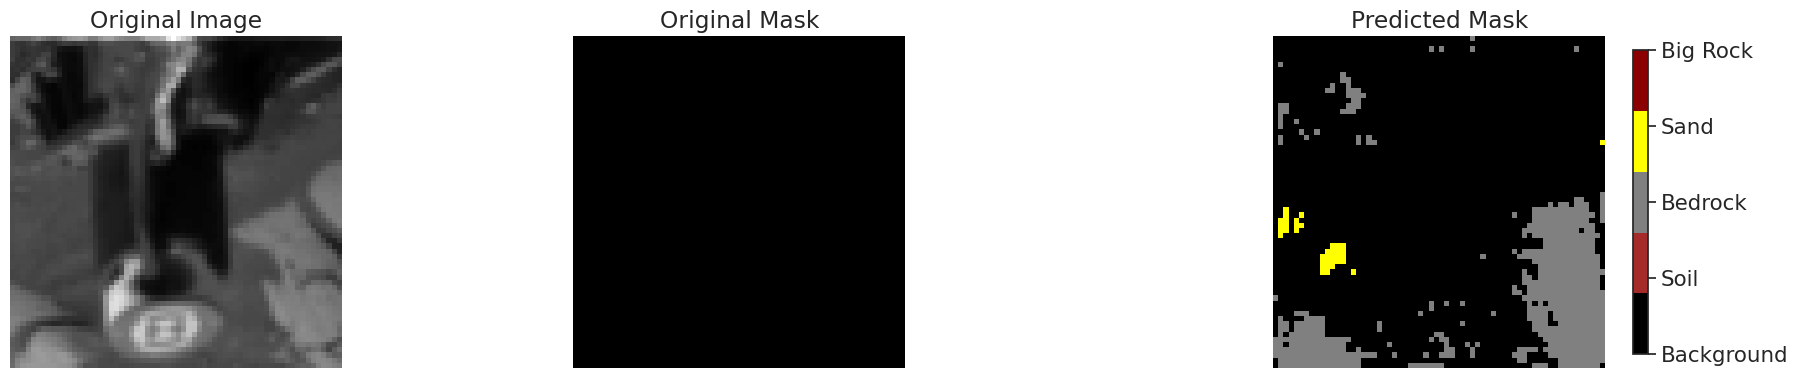

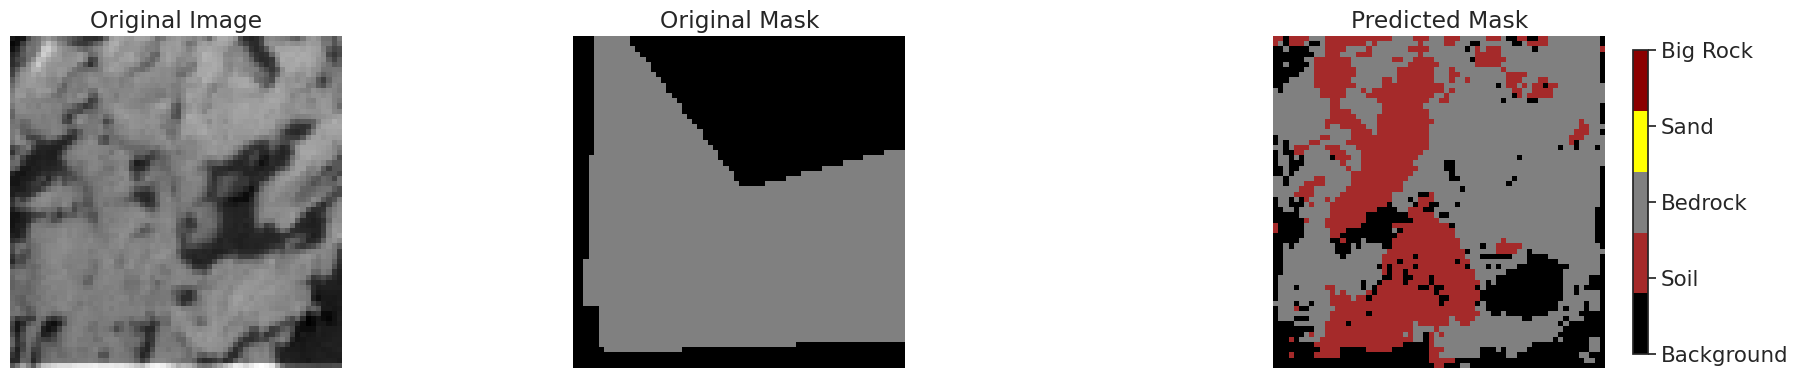

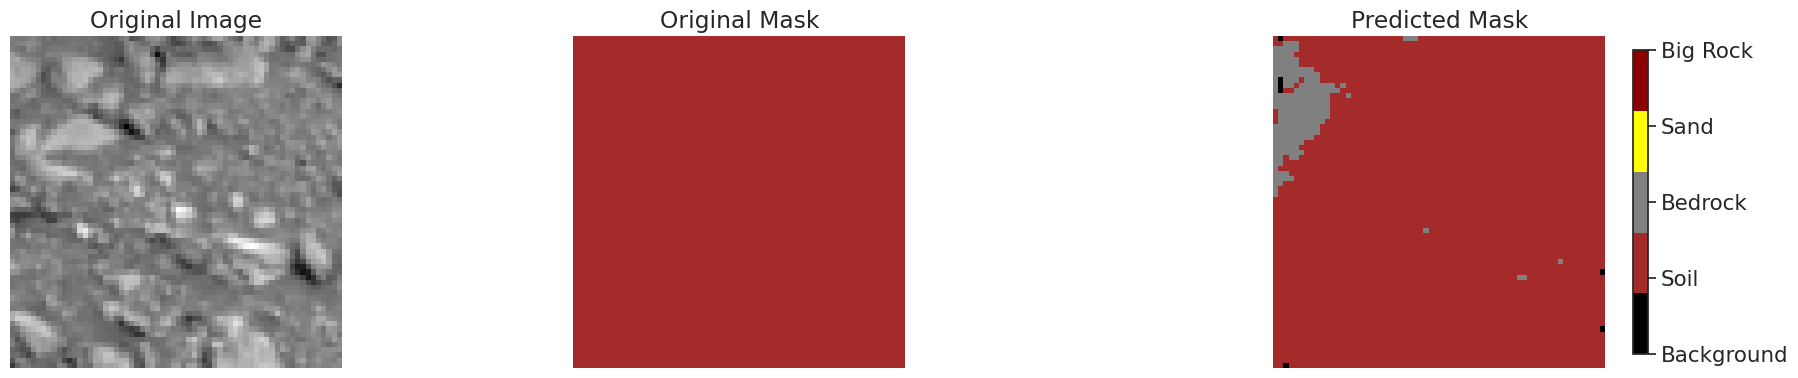

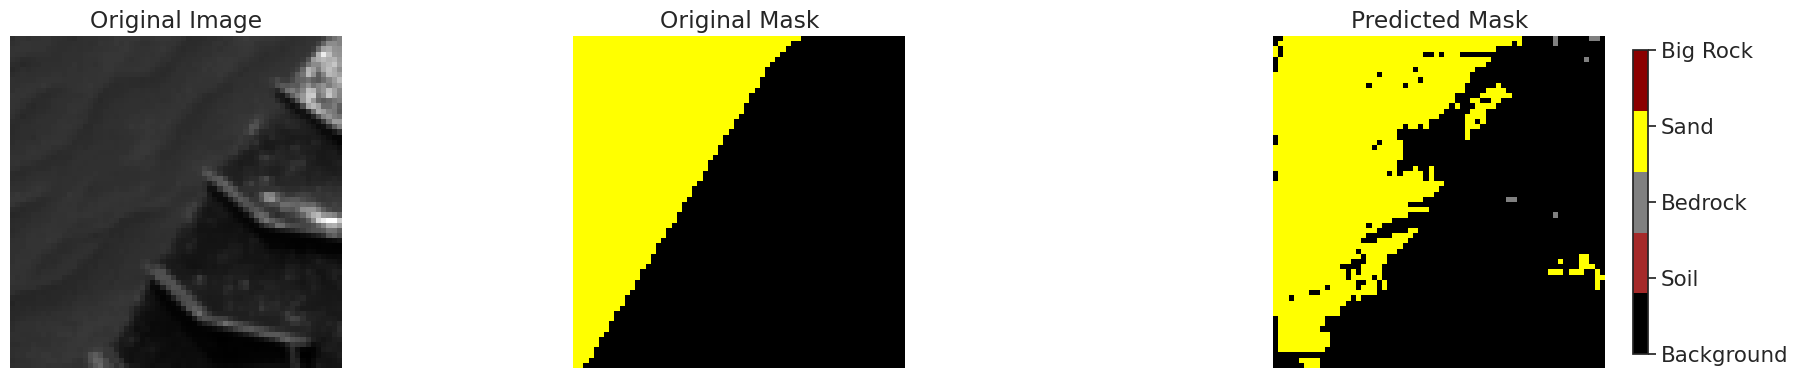

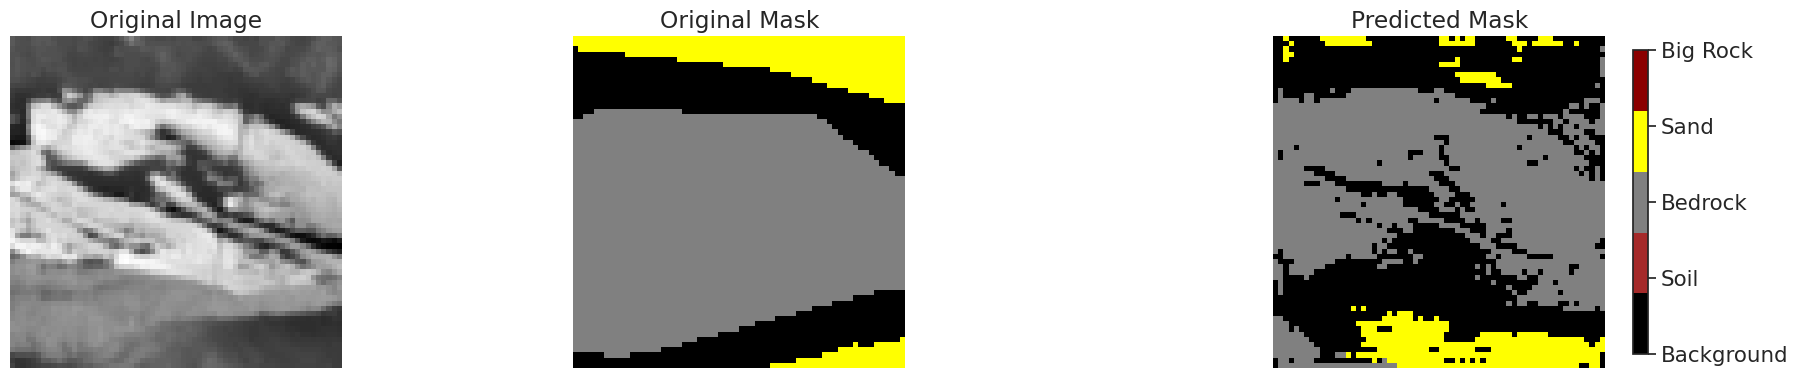

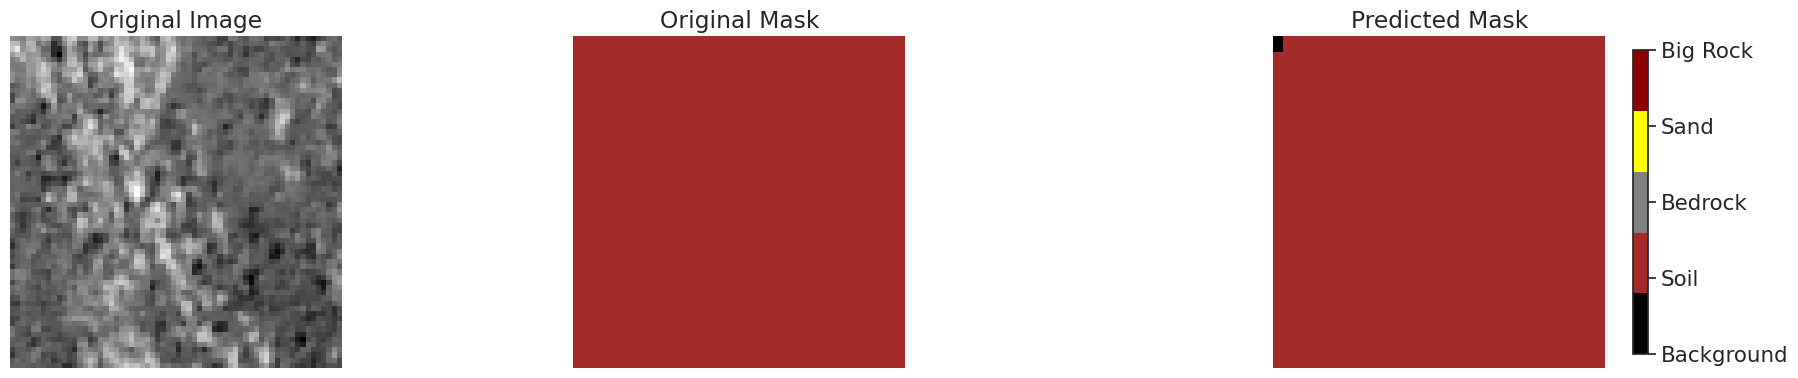

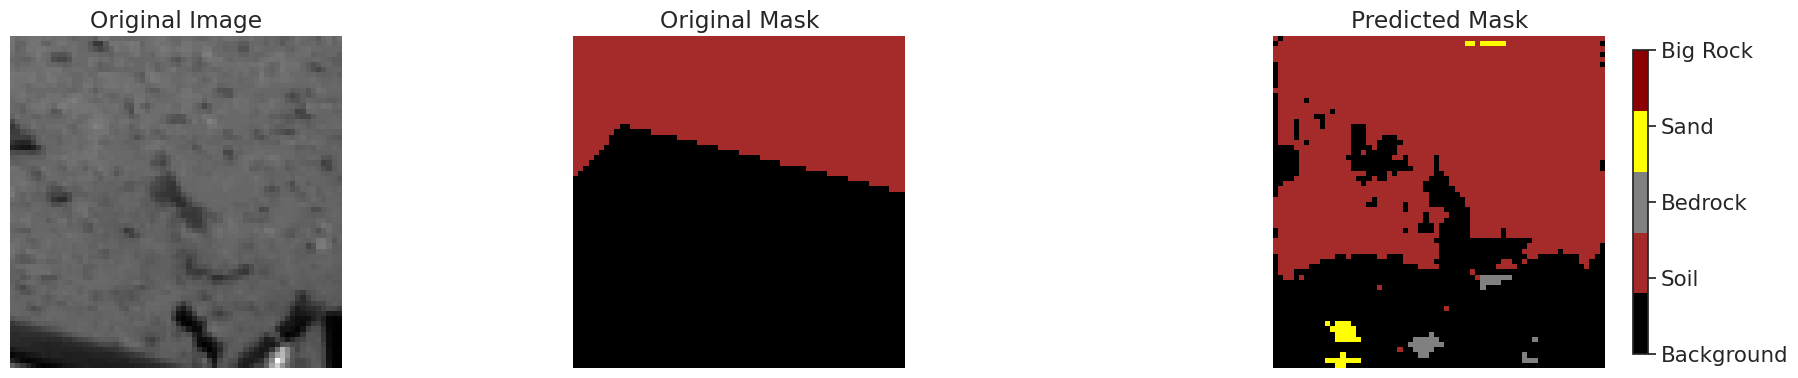

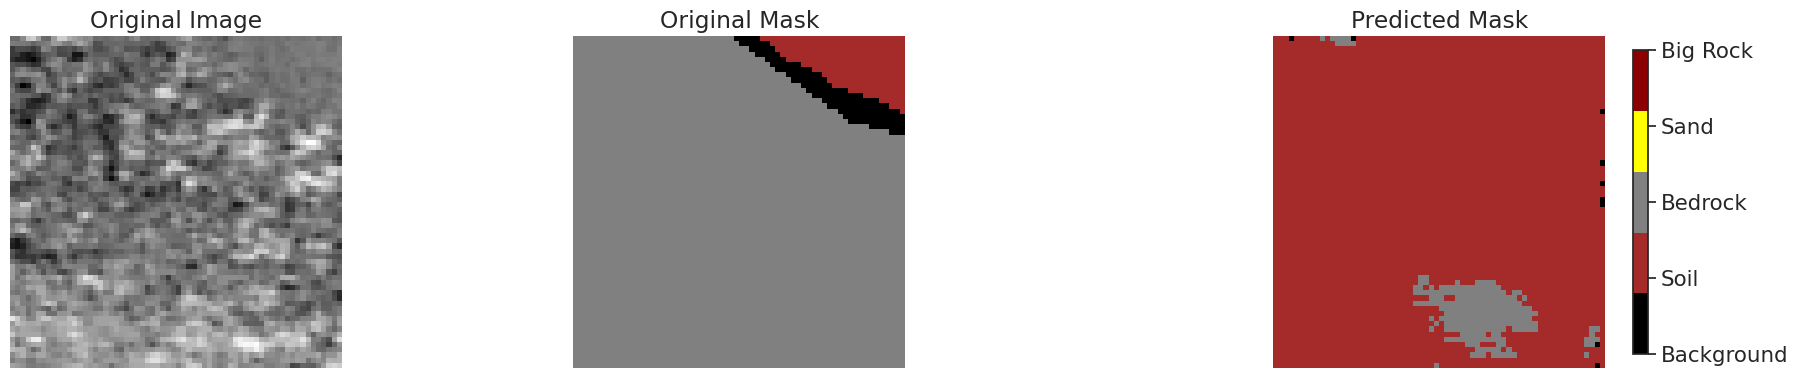

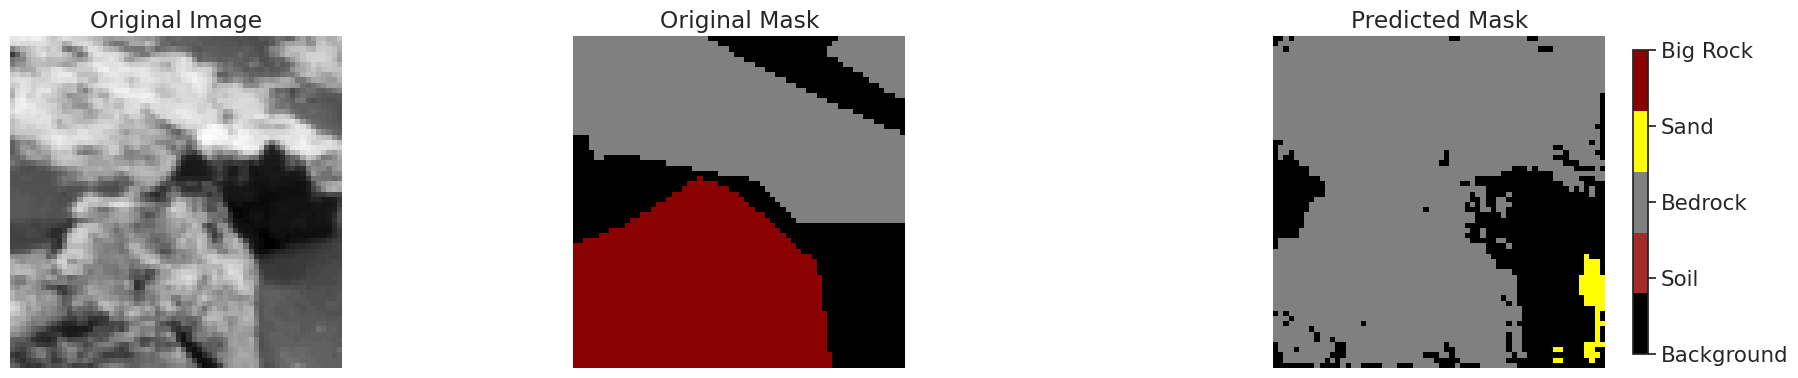

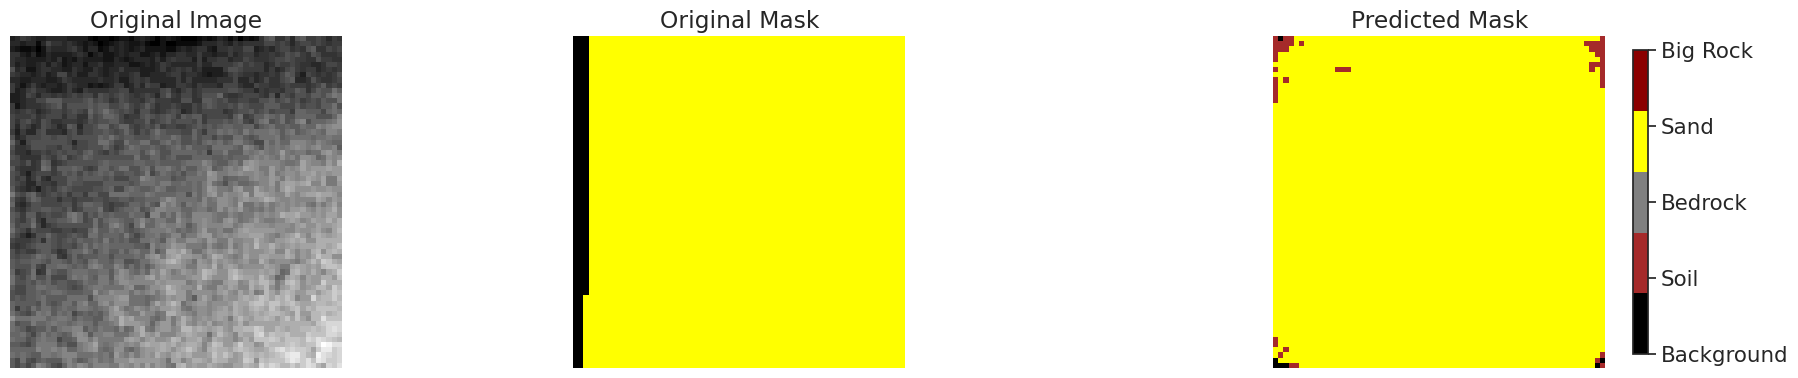

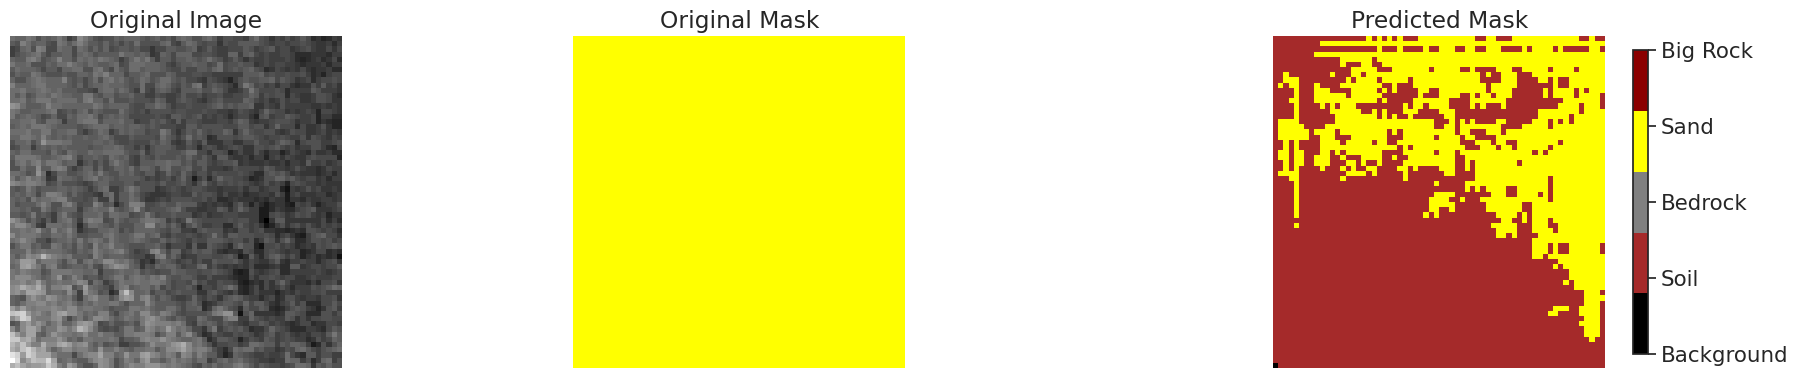

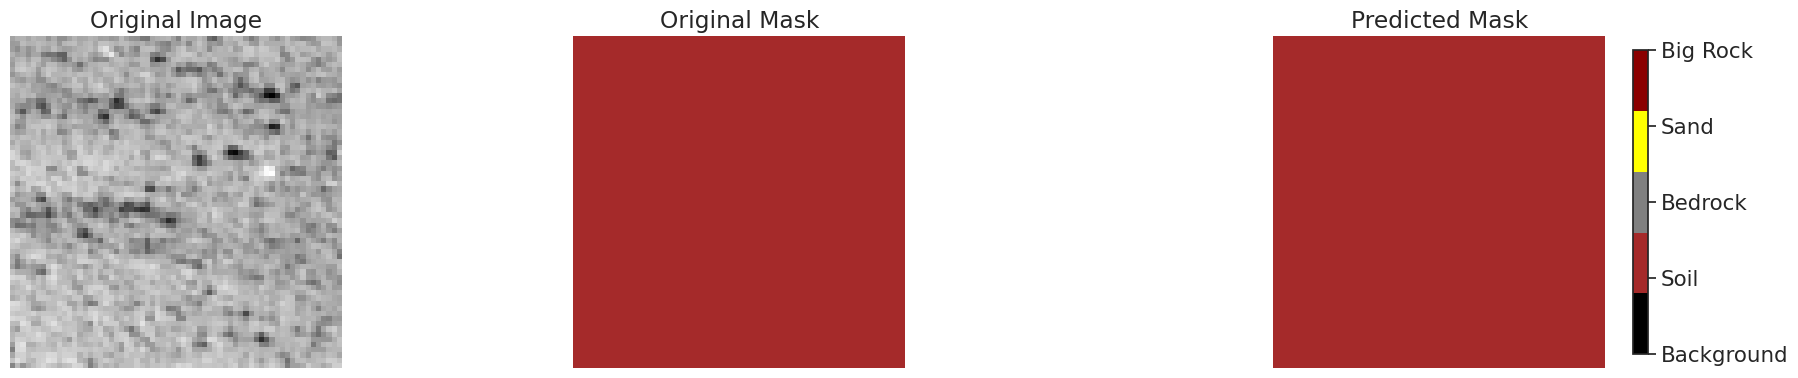

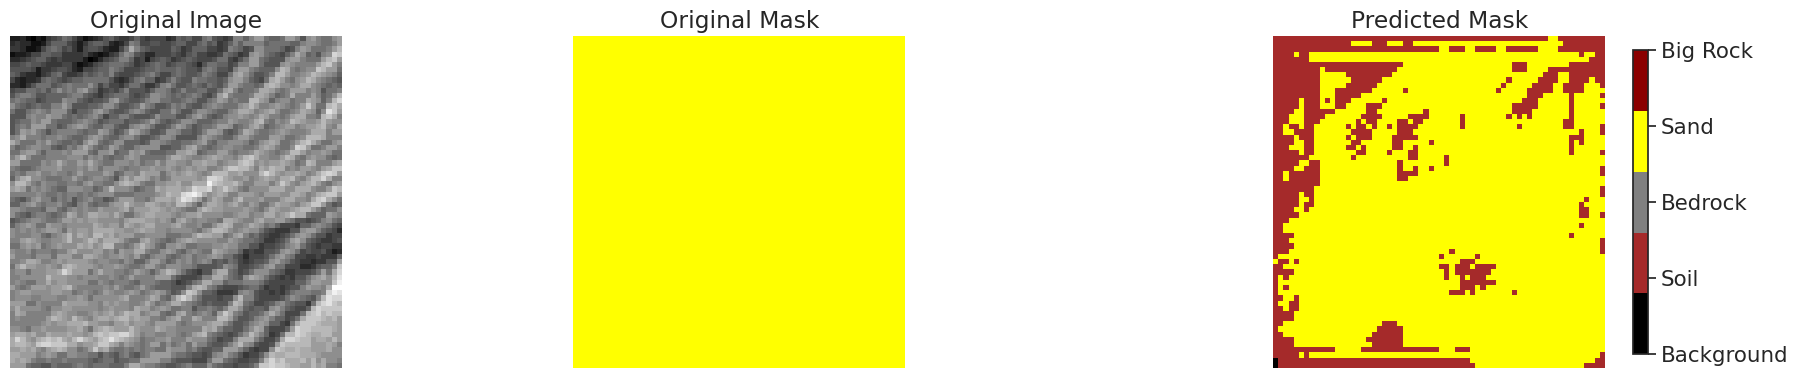

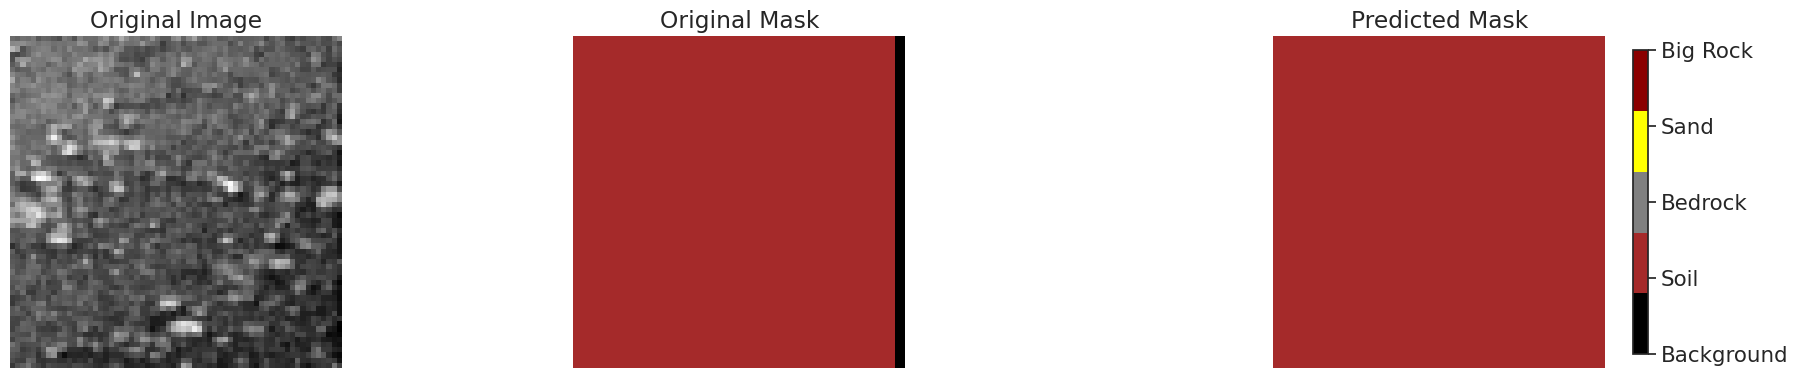

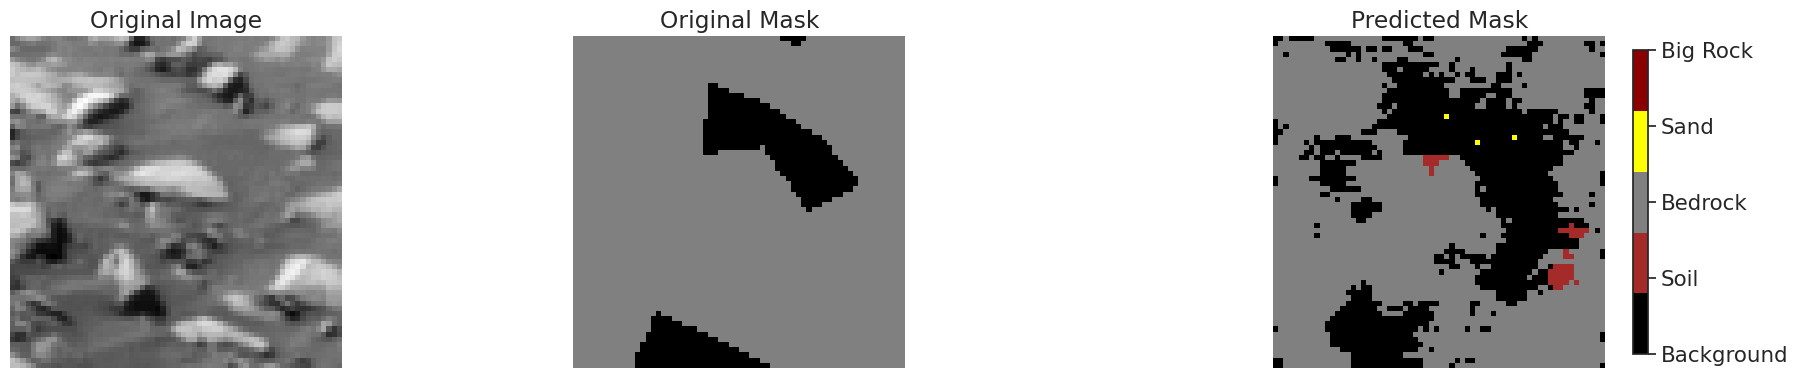

In [ ]:
# Load model
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(train_dataset, model, num_samples=30)

In [ ]:
#compute predictions
preds = model.predict(X_final_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


In [ ]:
#to pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gated Skip Connection

In [ ]:
def unet_trial1(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block_bottleneck(d2, 128, name='bottleneck')

    # Upsampling path with gated skip connections
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = gated_skip_connection(down_block_2, u1, 64, 'gate1')
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = gated_skip_connection(down_block_1, u2, 32, 'gate2')
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_Trial1')
    return model

In [ ]:
training, model_filename = train_unet(
    model=unet_trial1(),
    loss_fn=loss,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name='gated_skip'
)

Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 76s 104ms/step - accuracy: 0.2391 - loss: 0.3038 - mean_iou: 0.1100 - val_accuracy: 0.2266 - val_loss: 0.2728 - val_mean_iou: 0.0716 - learning_rate: 1.0000e-05
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.4011 - loss: 0.2284 - mean_iou: 0.1930 - val_accuracy: 0.5054 - val_loss: 0.2011 - val_mean_iou: 0.2651 - learning_rate: 1.0000e-05
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.5033 - loss: 0.1937 - mean_iou: 0.2593 - val_accuracy: 0.5765 - val_loss: 0.1721 - val_mean_iou: 0.3150 - learning_rate: 1.0000e-05
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.5522 - loss: 0.1738 - mean_iou: 0.2909 - val_accuracy: 0.6098 - val_loss: 0.1559 - val_mean_iou: 0.3422 - learning_rate: 1.0000e-05
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.5779 - loss: 0.1619 - mean_iou: 0.3075 - val_accuracy: 0.6250 - val_loss: 0.1461 - val_mean_iou: 0.3499 - learning_rate: 1.0000e-05

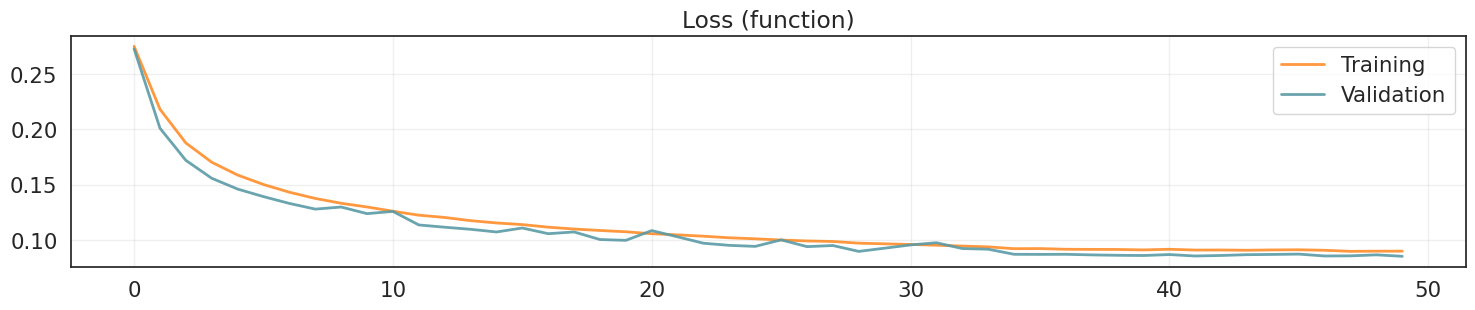

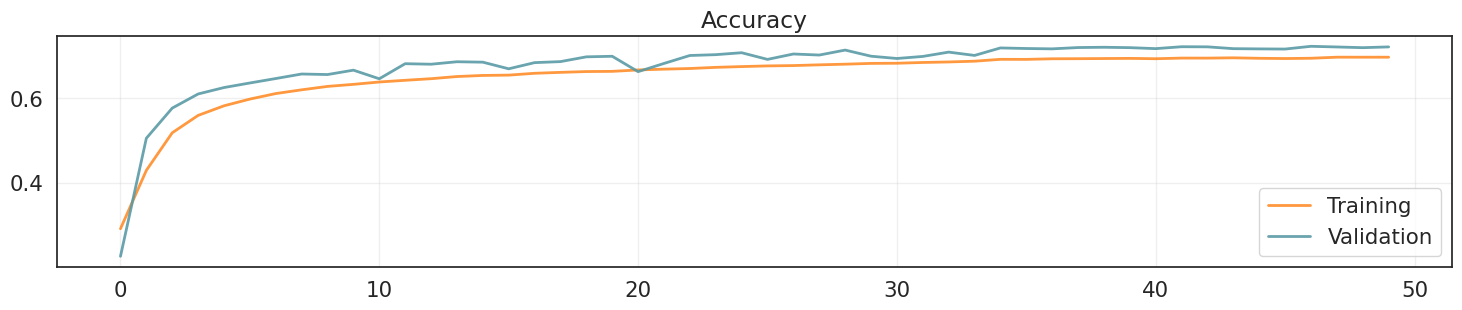

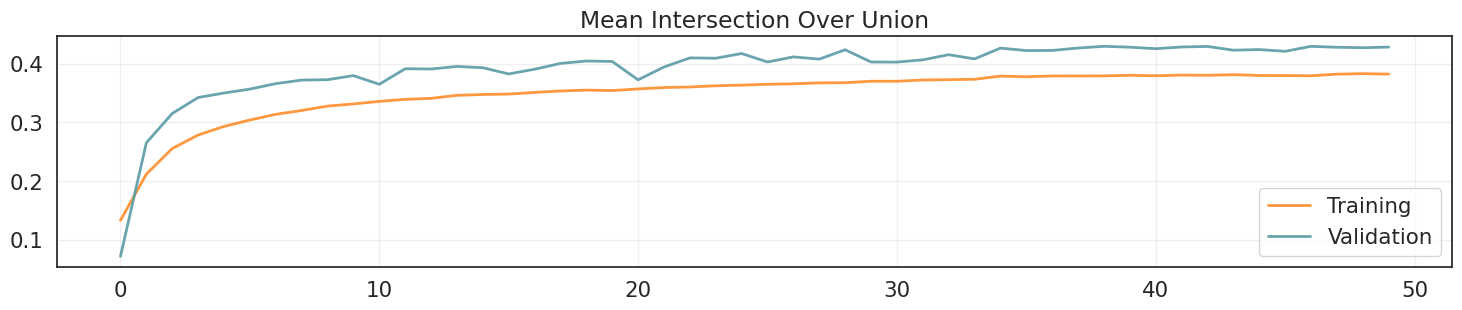

In [ ]:
plot_history(training, loss)

Test Accuracy: 0.7027
Test Mean Intersection over Union: 0.4102


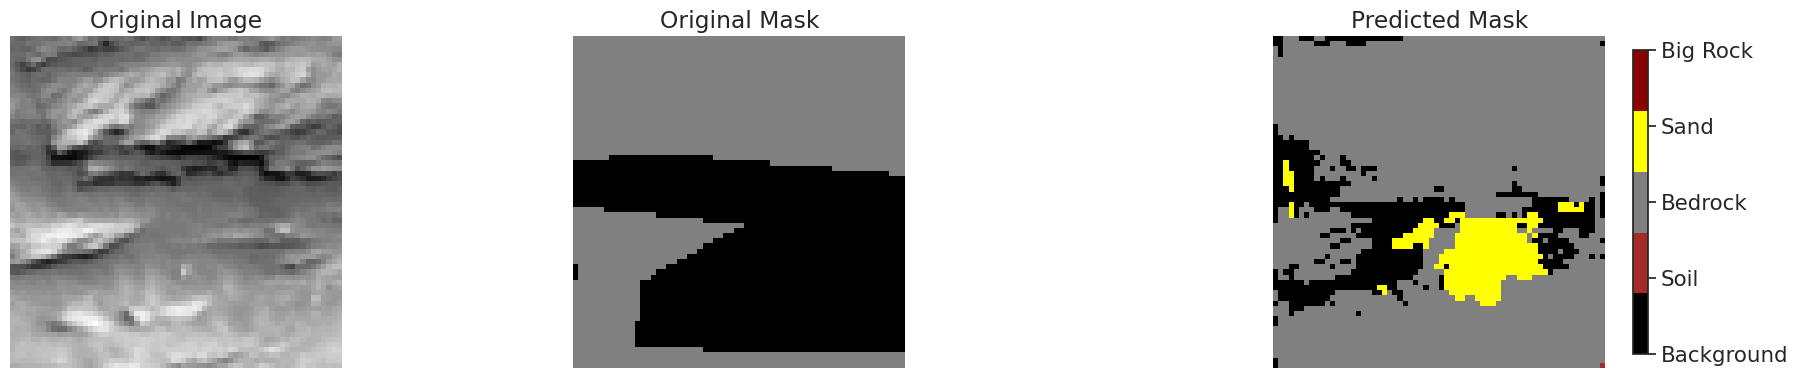

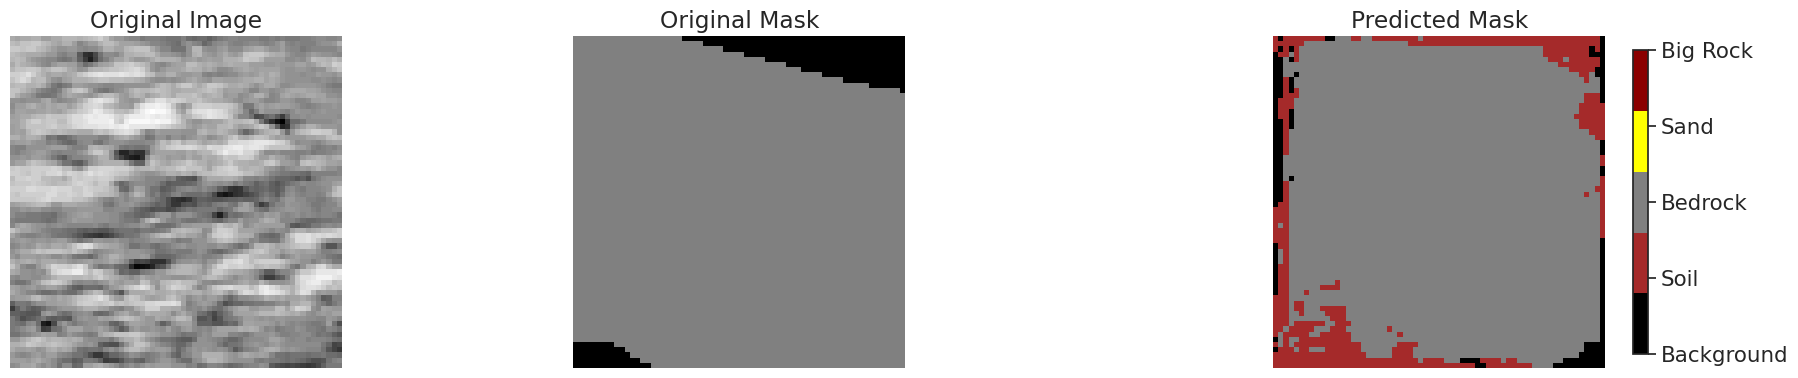

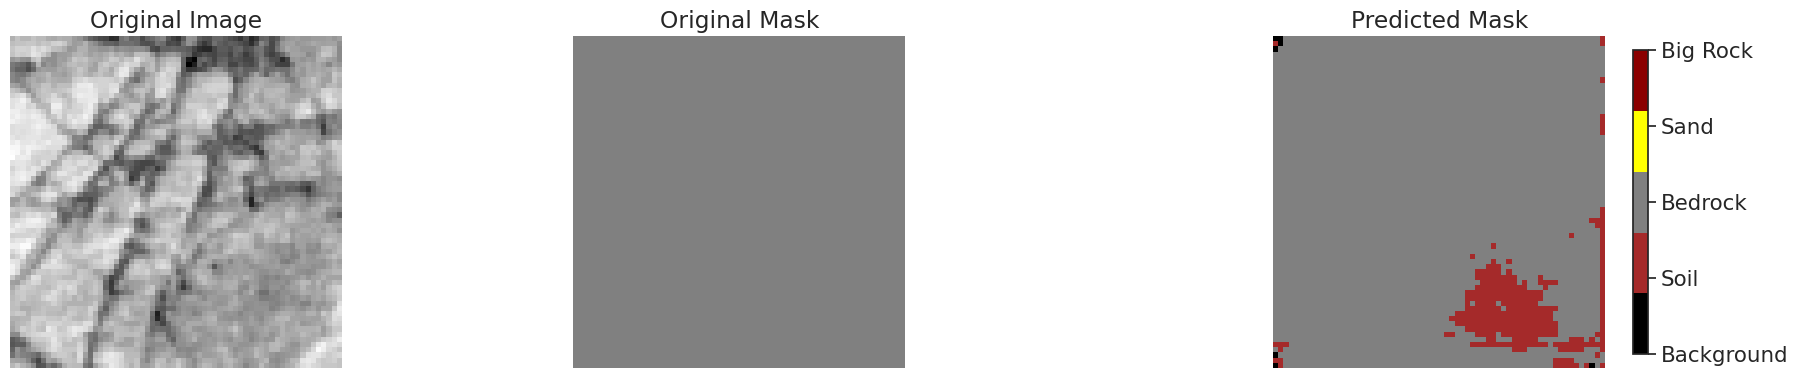

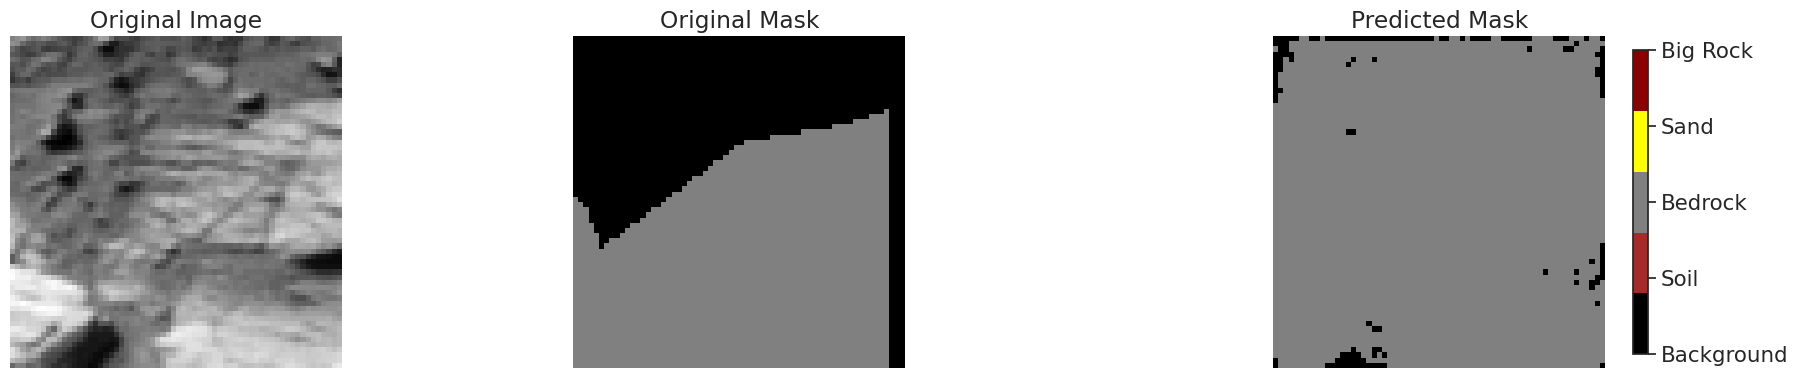

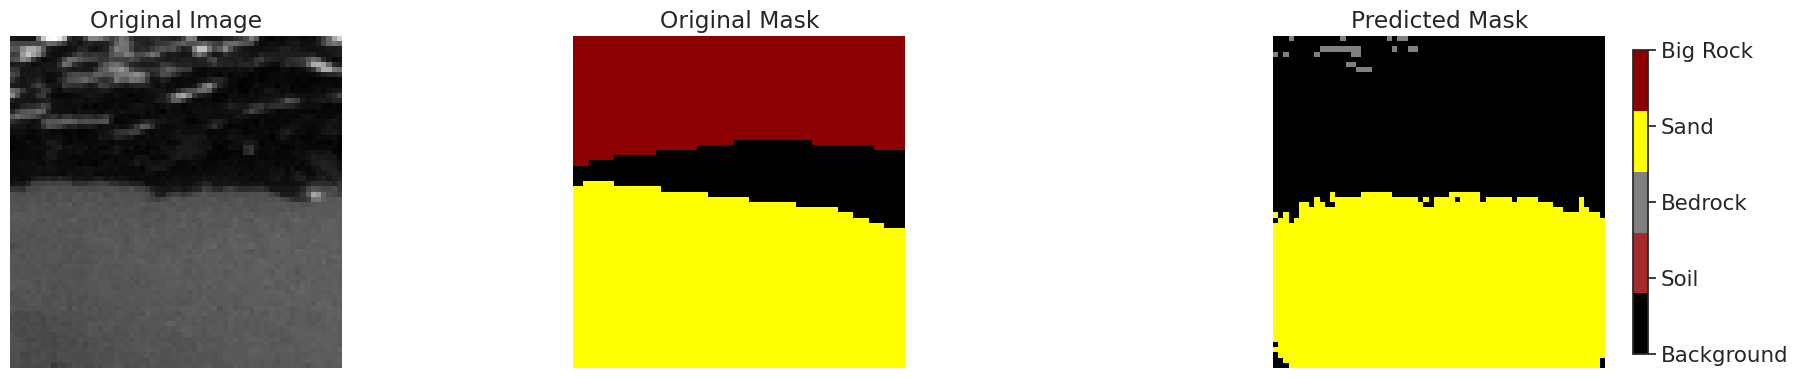

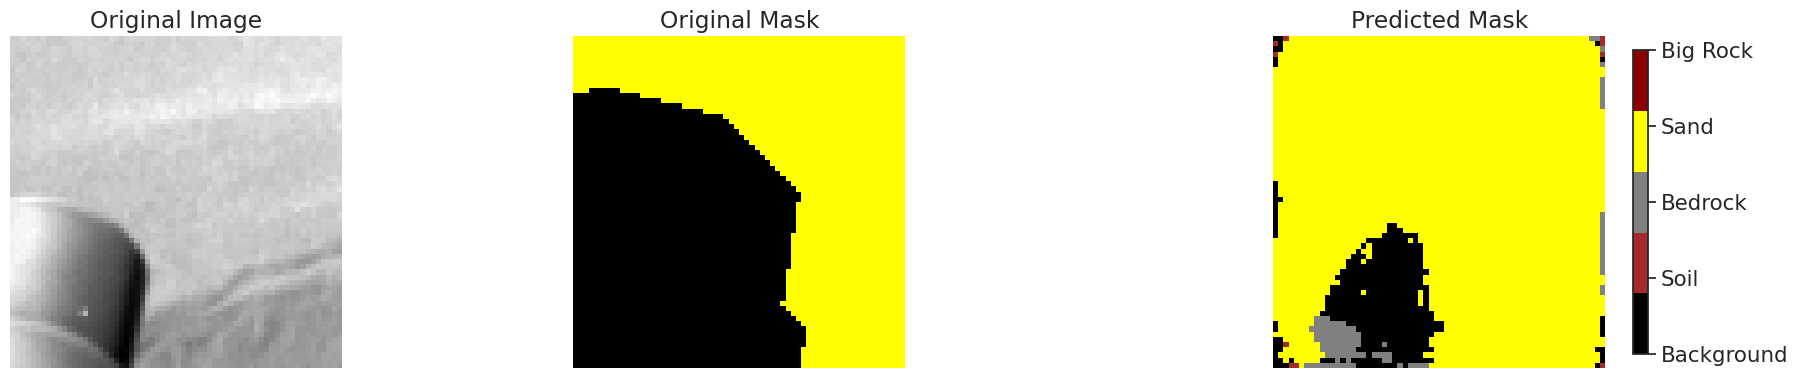

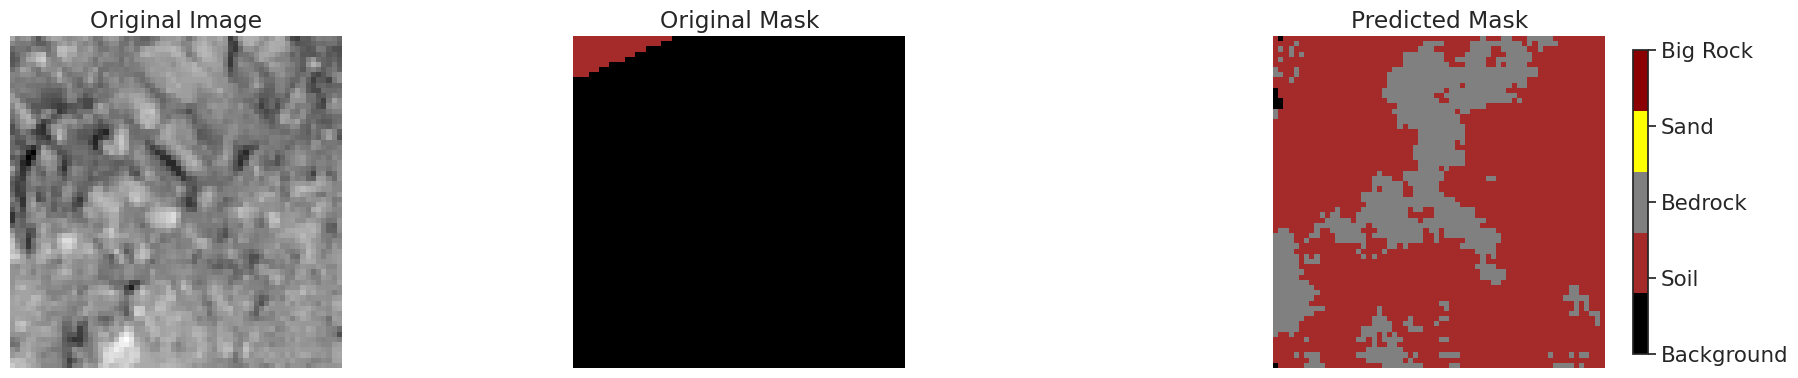

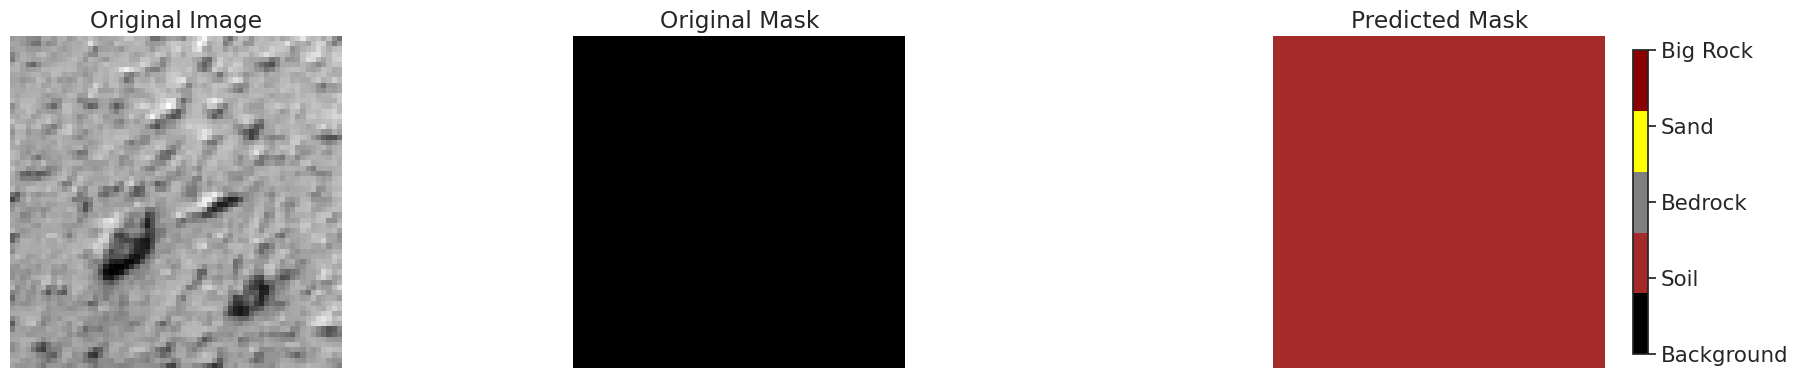

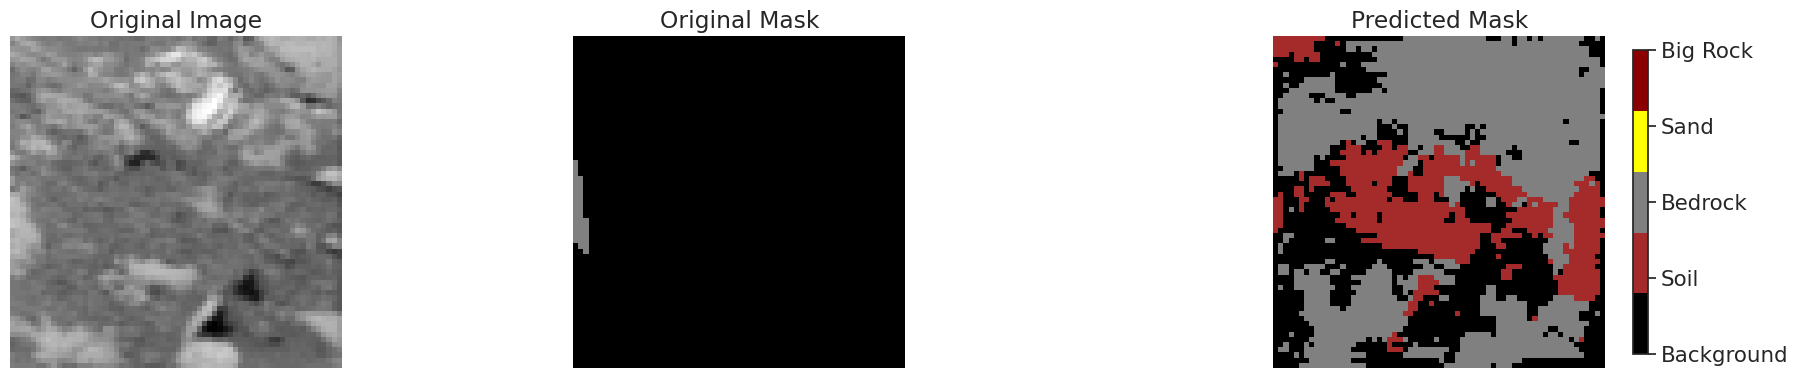

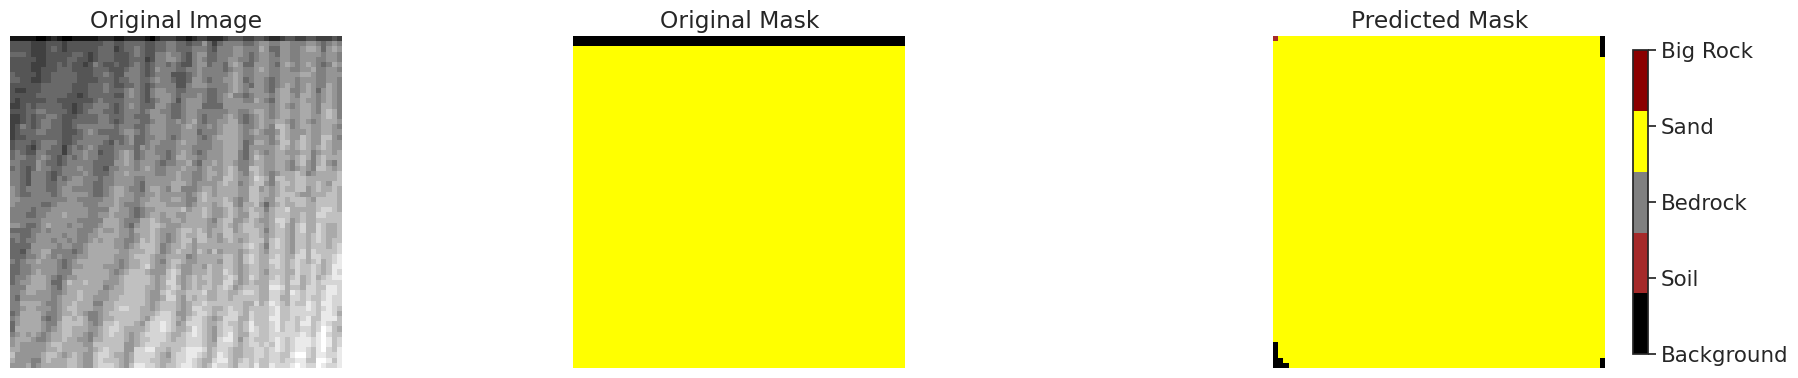

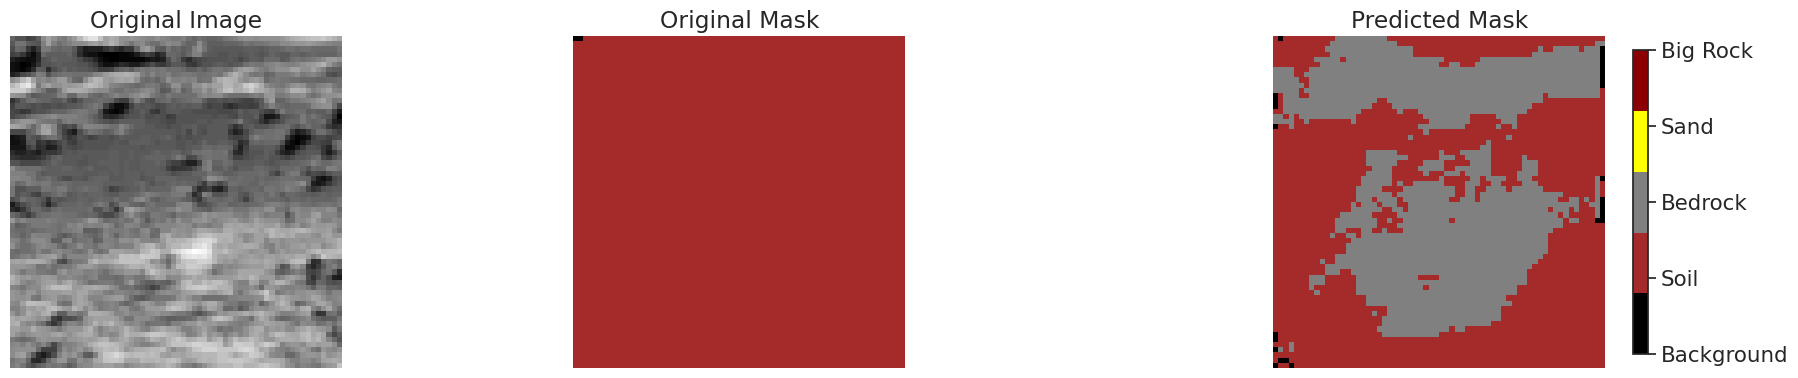

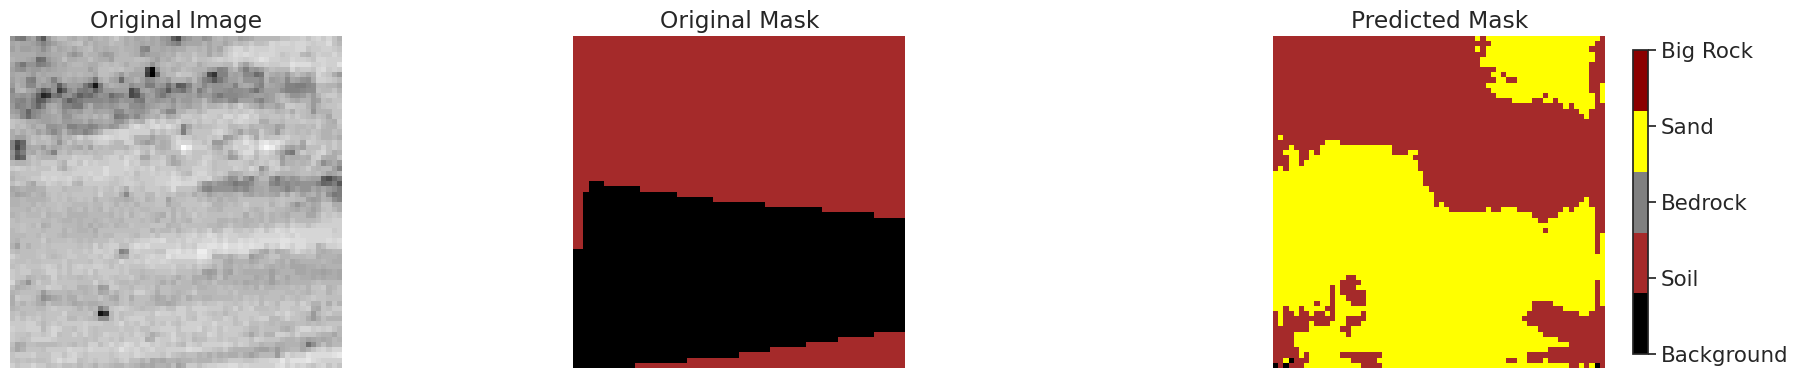

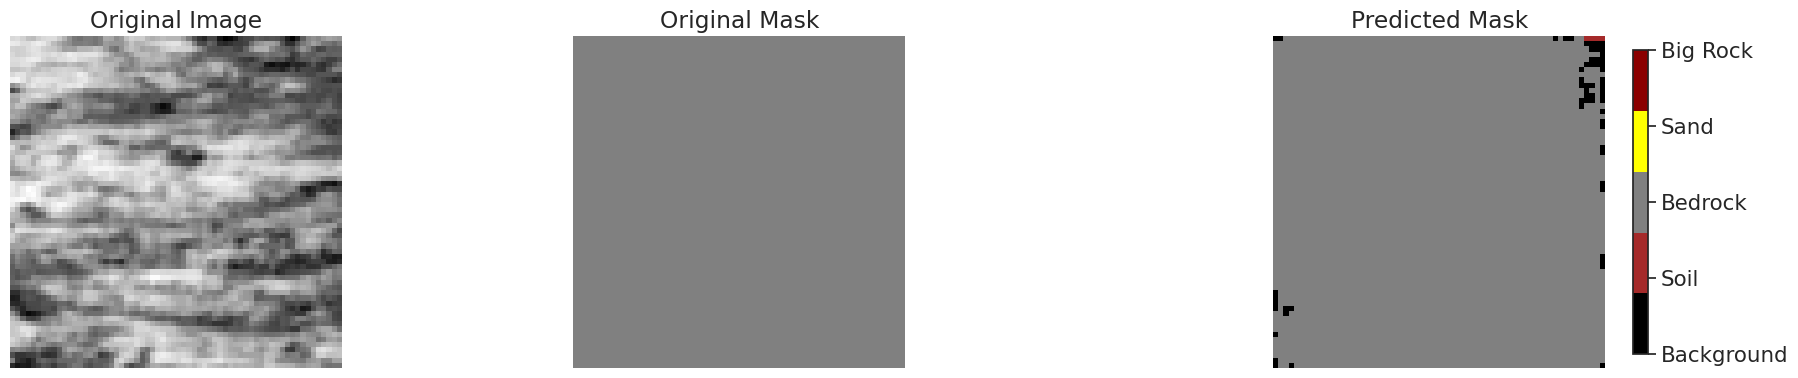

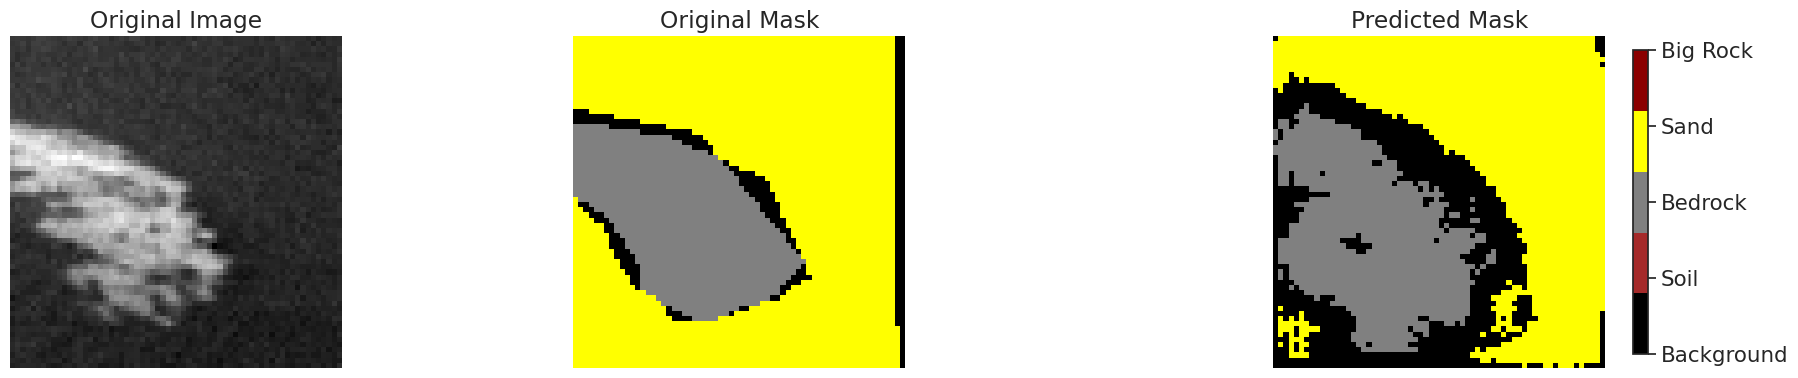

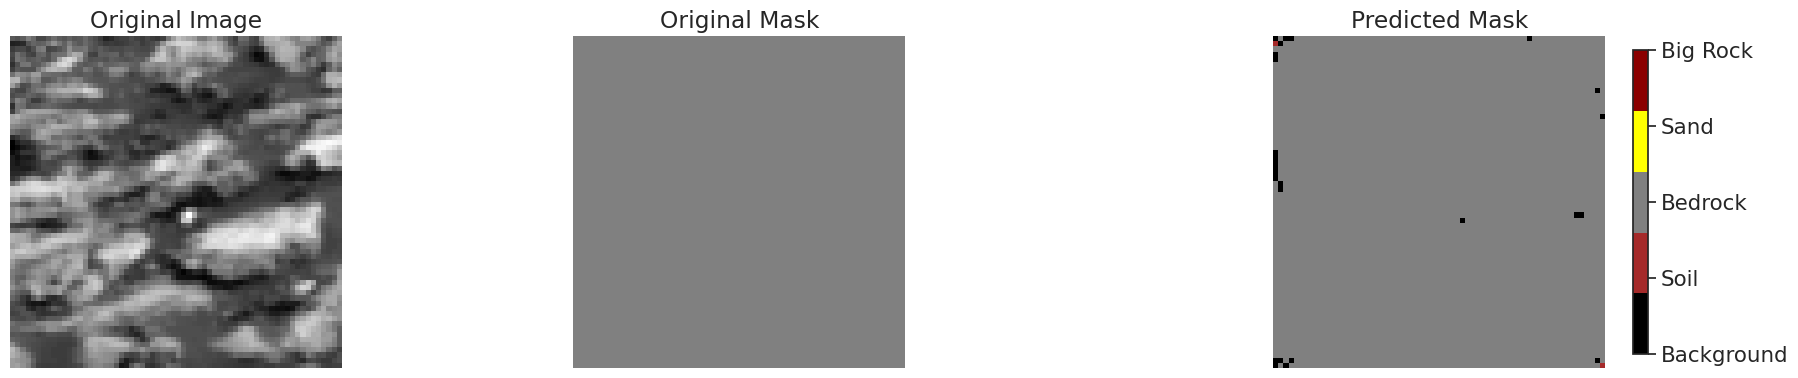

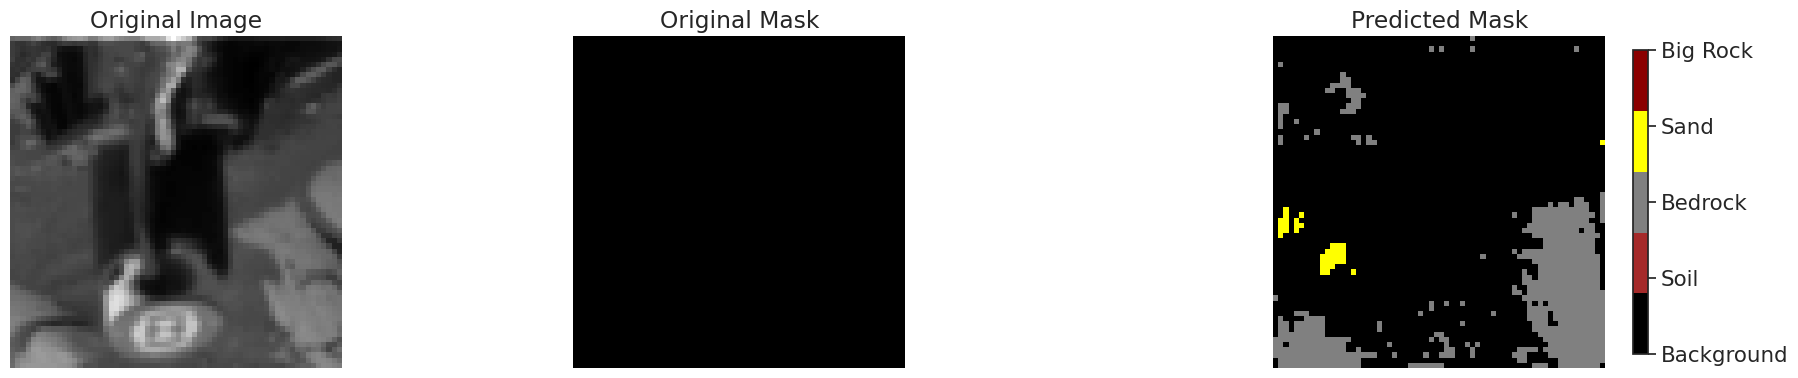

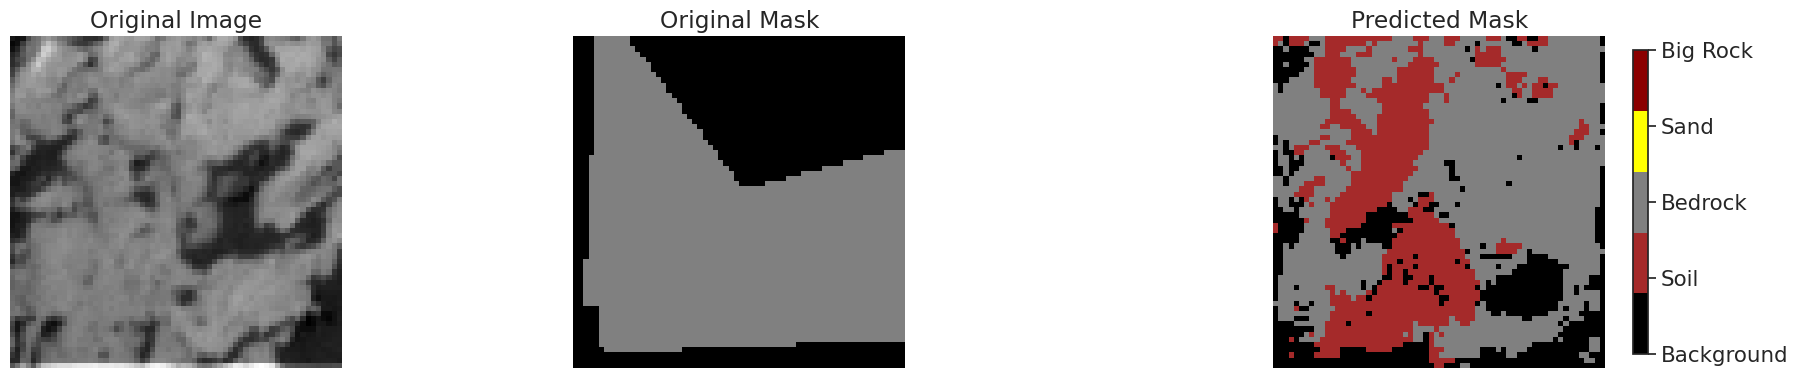

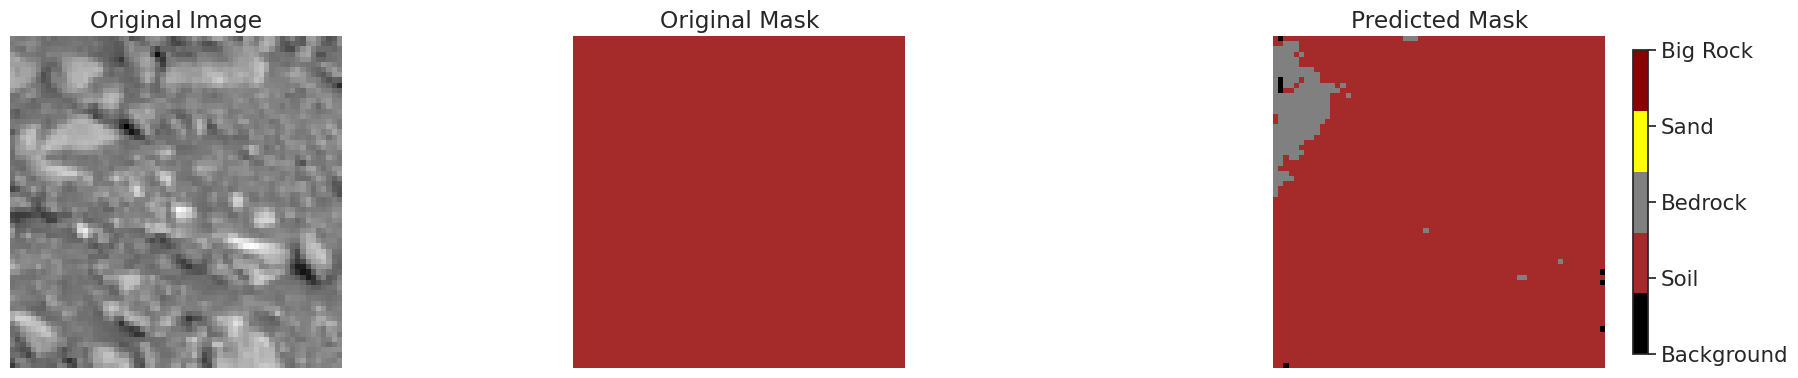

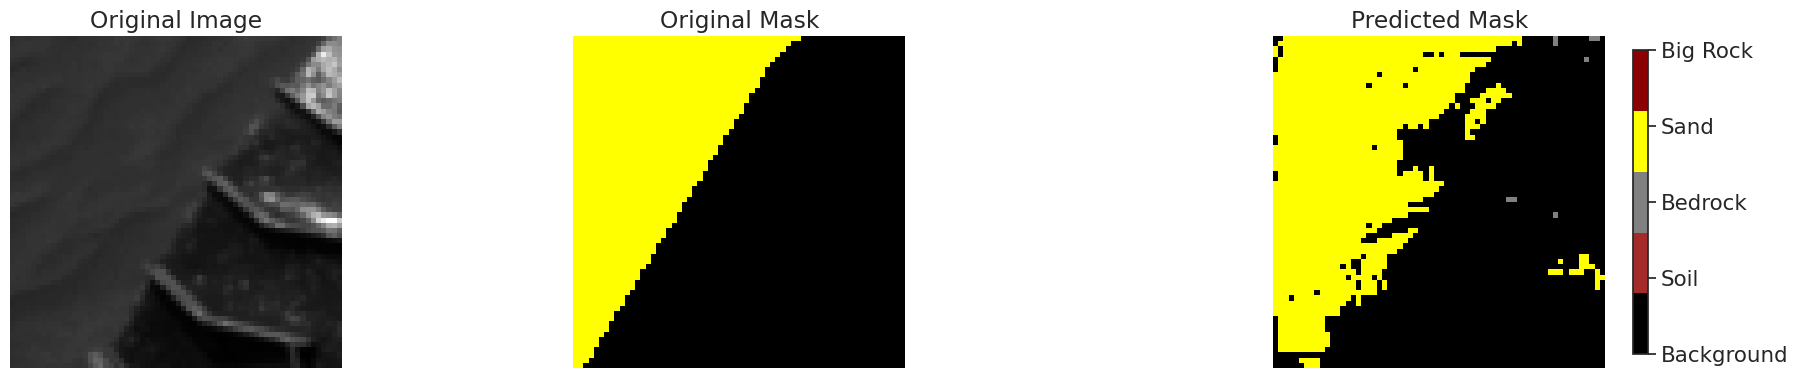

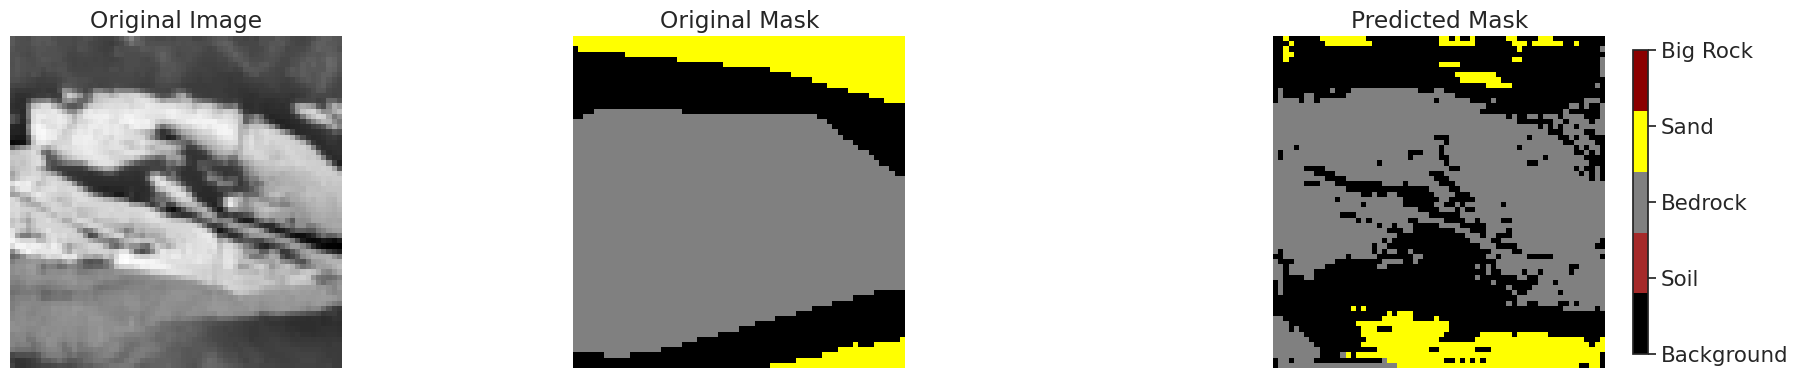

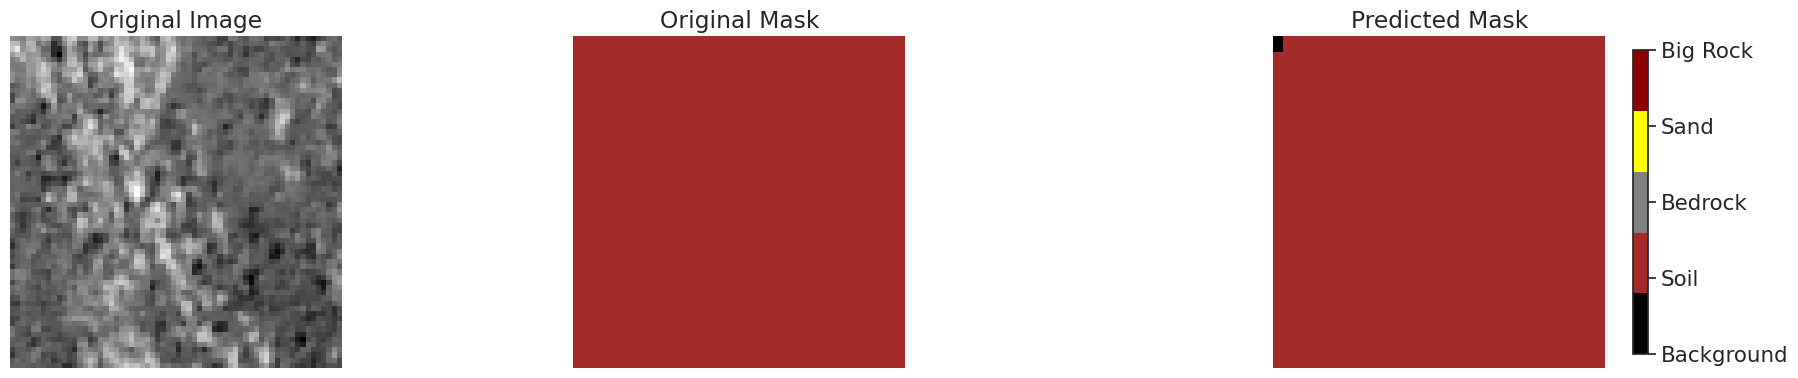

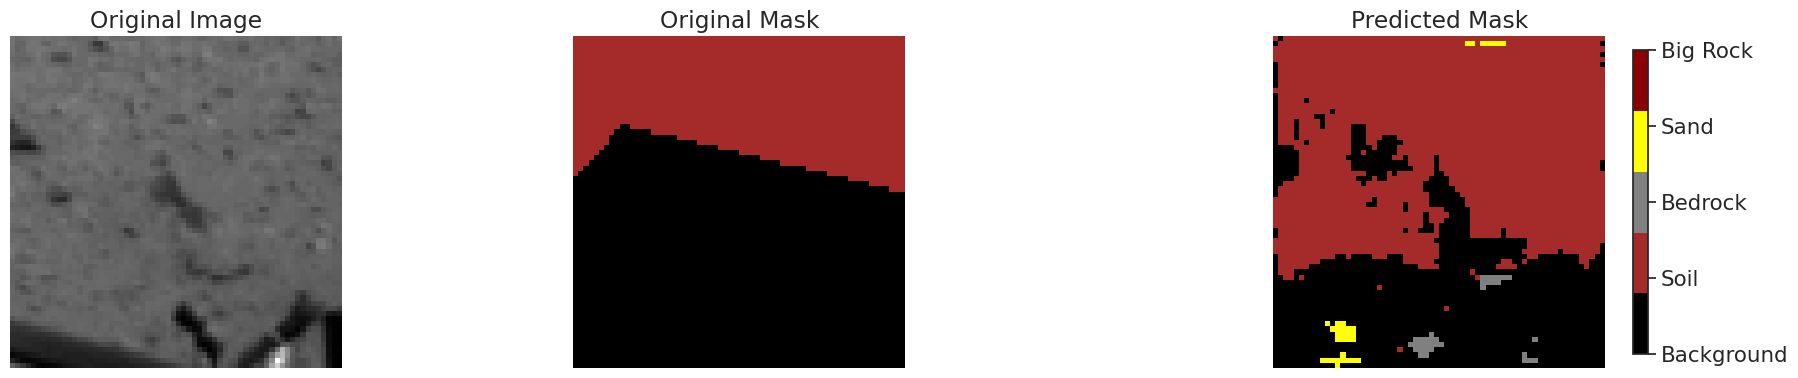

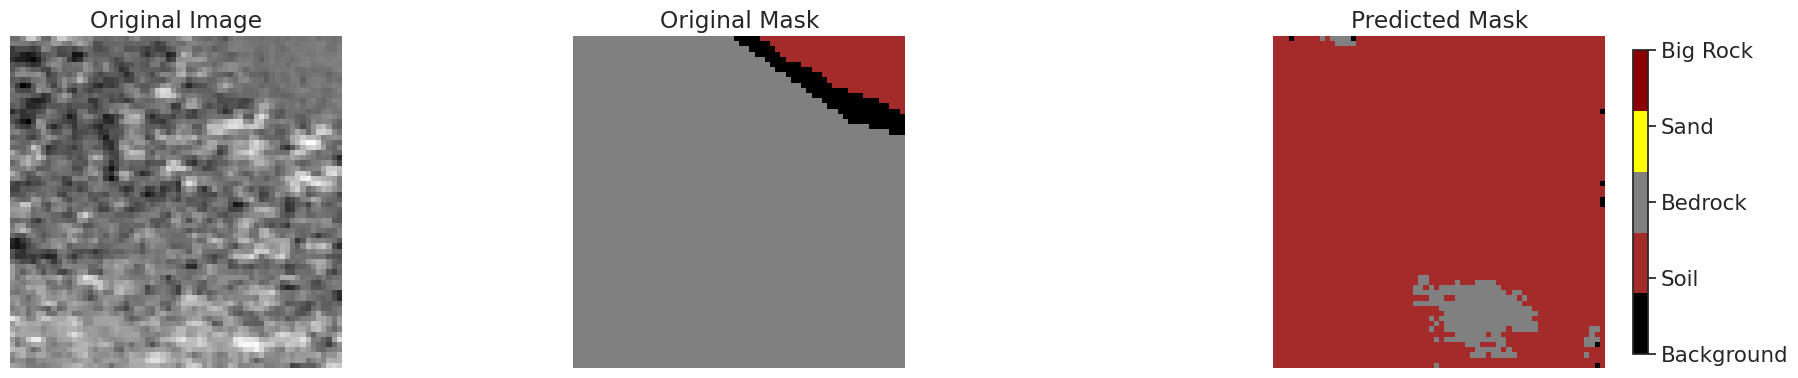

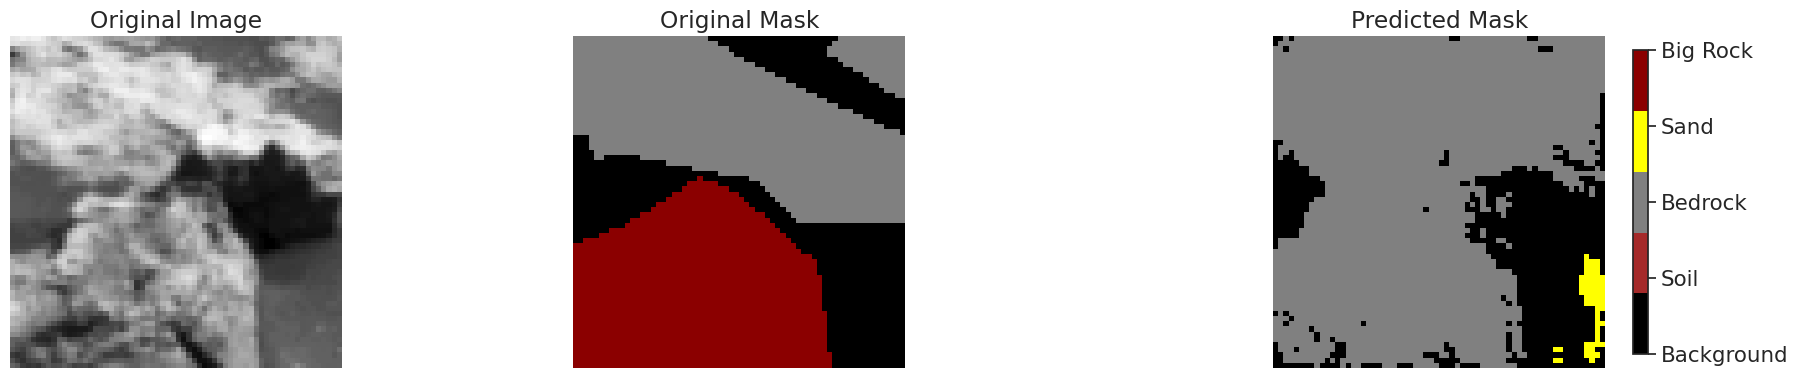

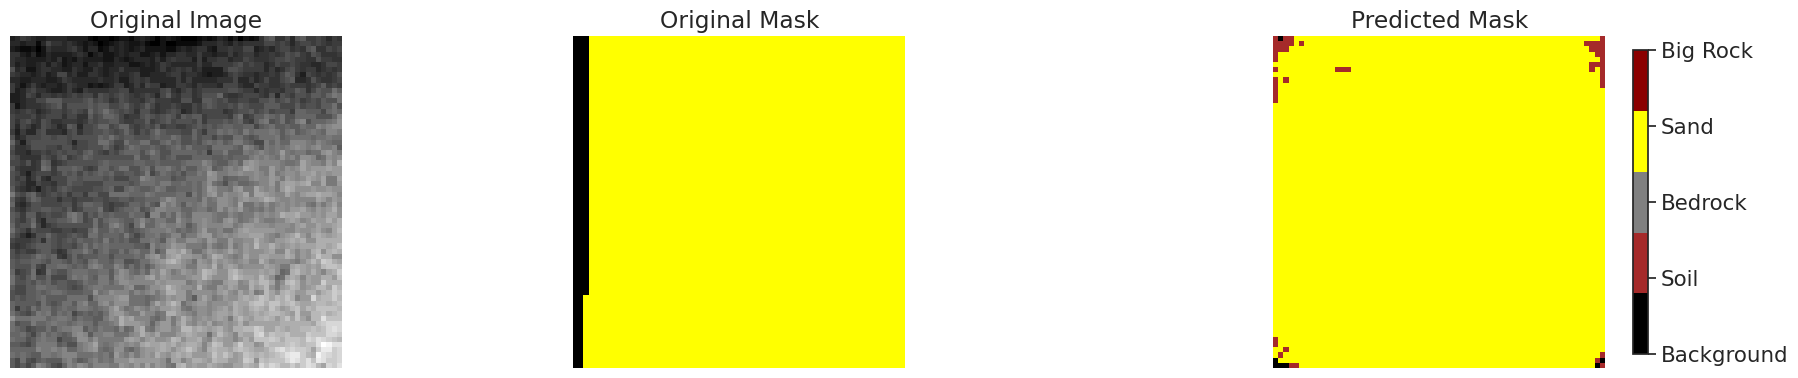

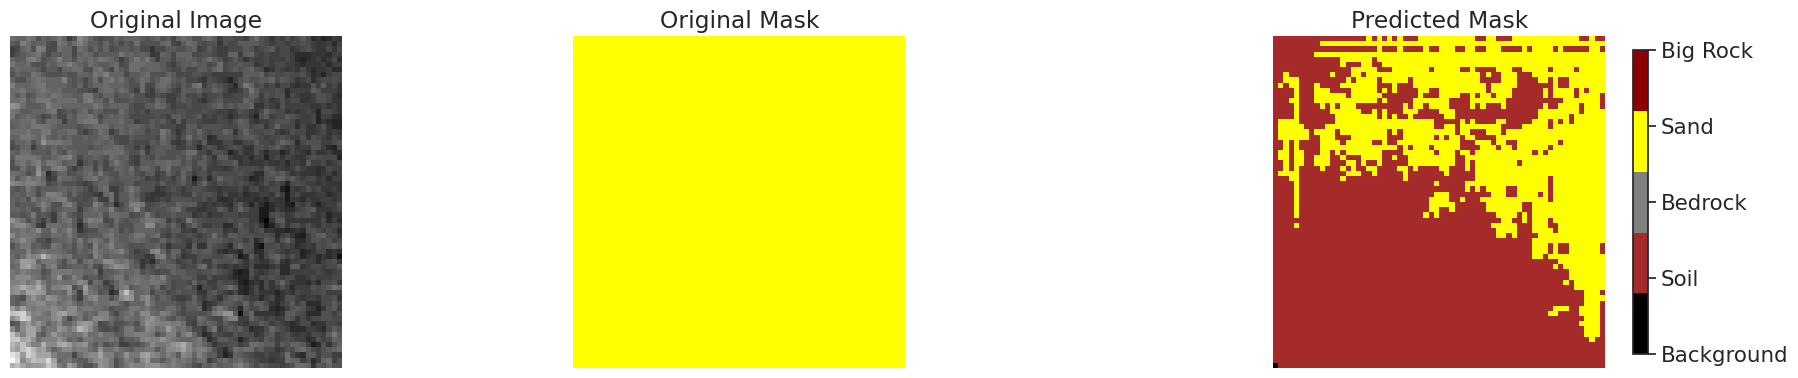

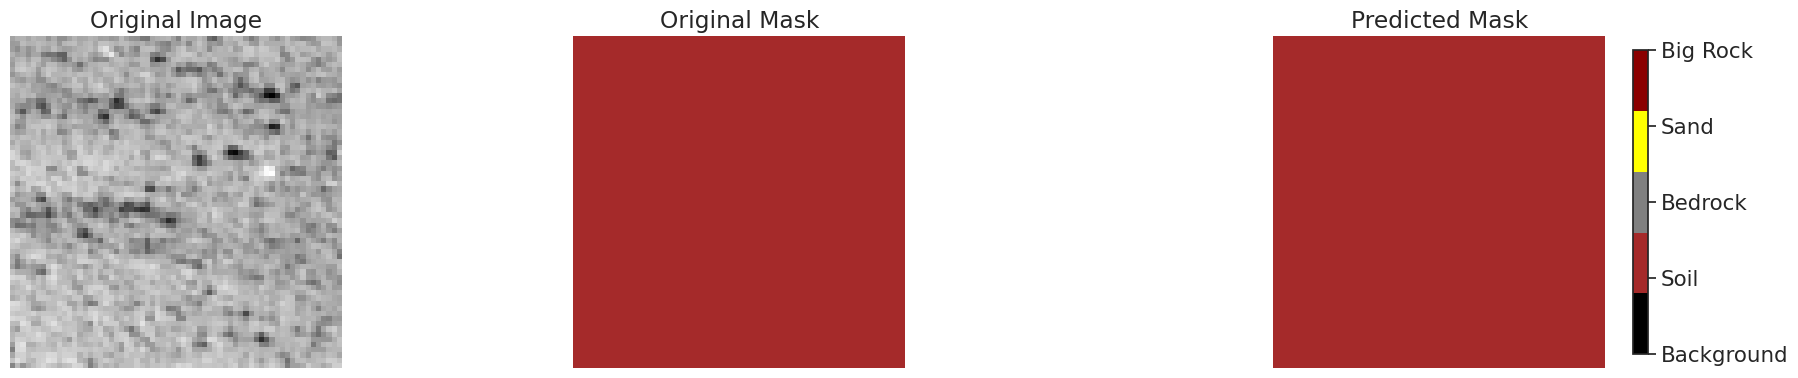

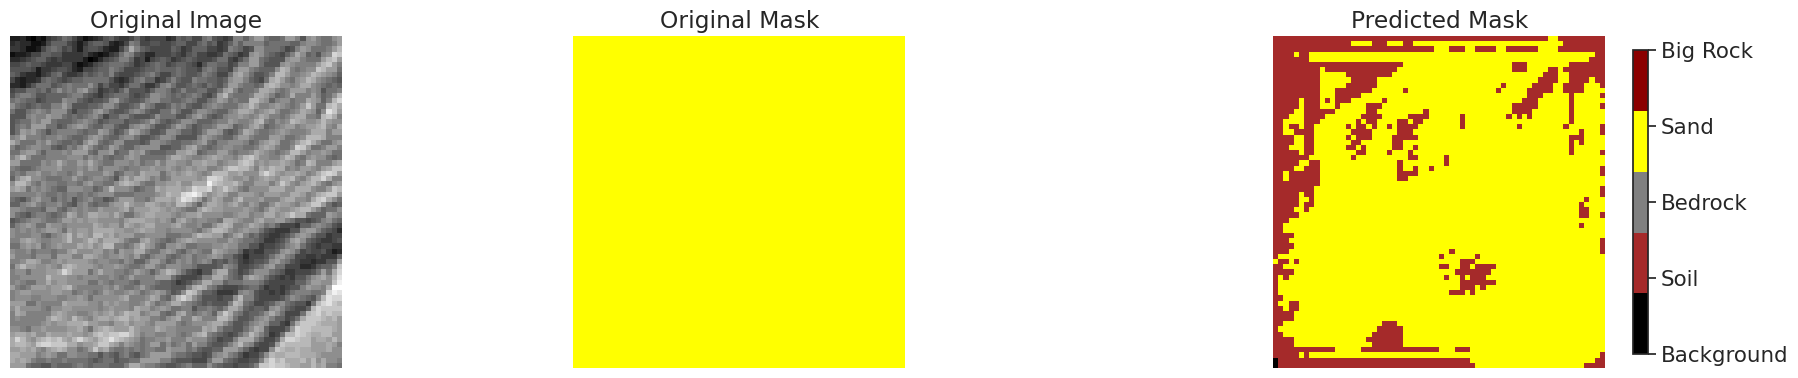

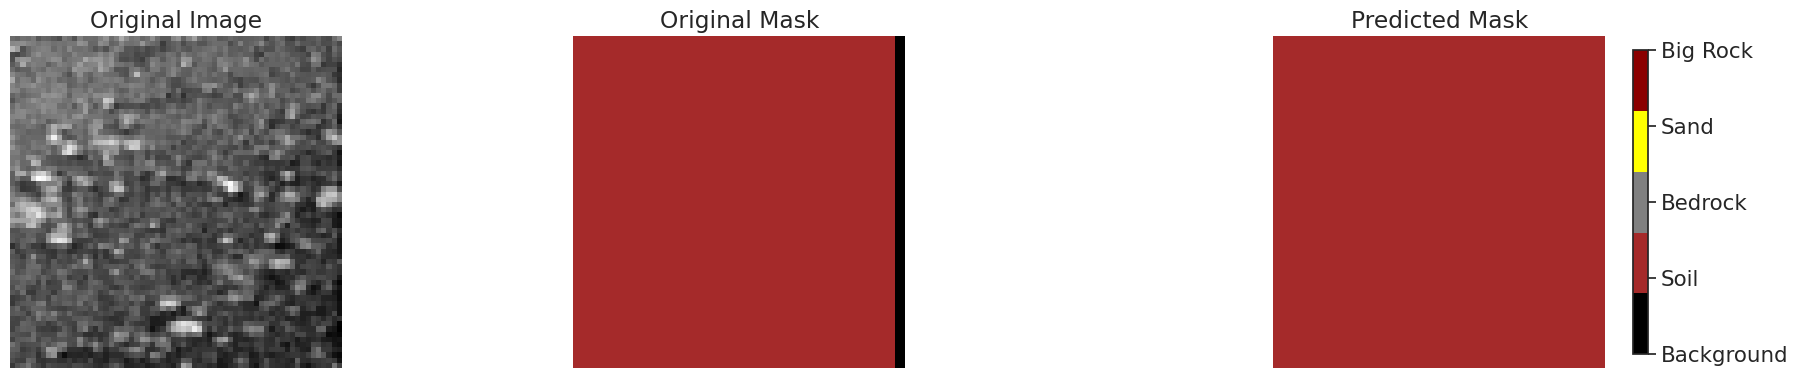

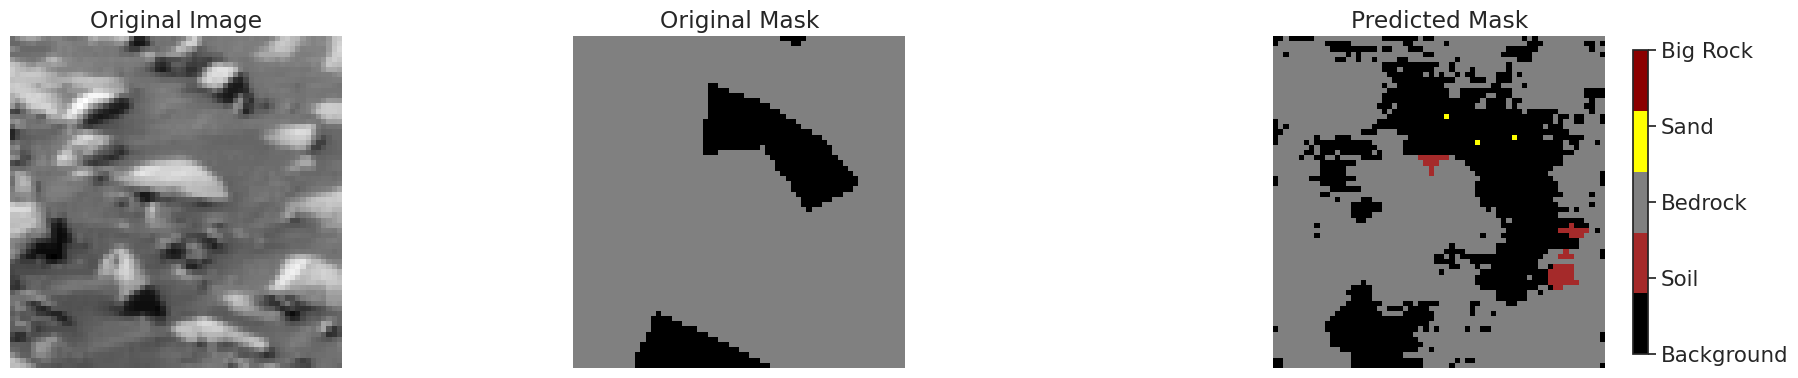

In [ ]:
# Load model
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(train_dataset, model, num_samples=30)

In [ ]:
#compute predictions
preds = model.predict(X_final_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


In [ ]:
#to pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>